# IMPORTS

In [1]:
import os
import math
import time
import torch
import warnings
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-besra'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BUILD DATASET & DATALOADERS

In [9]:
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [10]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [ ]:
def beta_score(predicted_prob_one, true_outcome, alpha_param=0.1, beta_param=3.0):
    epsilon = 1e-9
    # Clip probabilities to avoid log(0) or other numerical errors
    safe_prob = np.clip(predicted_prob_one, epsilon, 1.0 - epsilon)

    if true_outcome == 1:
        # Arguments for the betaln function when the true outcome is 1
        arg1 = alpha_param
        arg2 = beta_param + 1
        arg3 = alpha_param + safe_prob
        arg4 = beta_param + 1 - safe_prob
        if not (arg1 > 0 and arg2 > 0 and arg3 > 0 and arg4 > 0):
            return -1e9
        return -betaln(arg1, arg2) + betaln(arg3, arg4)
    elif true_outcome == 0:
        # Arguments for the betaln function when the true outcome is 0
        arg1 = alpha_param + 1
        arg2 = beta_param
        arg3 = alpha_param + 1 - safe_prob
        arg4 = beta_param + safe_prob
        if not (arg1 > 0 and arg2 > 0 and arg3 > 0 and arg4 > 0):
            return -1e9
        return -betaln(arg1, arg2) + betaln(arg3, arg4)
    else:
        raise ValueError("Invalid label: true_outcome must be 0 or 1.")

def calculate_expected_beta_score(predicted_prob_one, alpha_param, beta_param):
    score_if_one = beta_score(predicted_prob_one, 1, alpha_param, beta_param)
    score_if_zero = beta_score(predicted_prob_one, 0, alpha_param, beta_param)
    # The expected score is the average of scores for each possible outcome,
    # weighted by the predicted probability of that outcome.
    expected_score = predicted_prob_one * score_if_one + (1.0 - predicted_prob_one) * score_if_zero
    return expected_score

def get_ensemble_predictions_for_batch(ensemble_models, input_ids, attention_mask, device):
    individual_model_probs_list = []
    with torch.no_grad():
        for model_instance in ensemble_models:
            model_instance.eval()
            model_instance.to(device)
            outputs = model_instance(input_ids.to(device), attention_mask=attention_mask.to(device))
            probs = torch.sigmoid(outputs.logits)
            individual_model_probs_list.append(probs)

        if not individual_model_probs_list:
            return torch.empty(0, device=device), []

        individual_probs_tensor = torch.stack(individual_model_probs_list)
        average_probs = torch.mean(individual_probs_tensor, dim=0)

    return average_probs, individual_model_probs_list

def besra_sampling(
    ensemble_models,
    unlabeled_data,
    train_indices,
    remaining_indices,
    estimation_data,
    tokenizer,
    num_classes,
    sampling_dur,
    new_samples,
    trials,
    alpha_param=0.1,
    beta_param=3.0,
    n_clusters=100, # min_increment
):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    unlabeled_dataset = NetifierDataset(unlabeled_data,
                                        np.zeros((len(unlabeled_data), num_classes)),
                                        tokenizer,
                                        max_length=256) # sequence_length
    unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=32, num_workers=4, pin_memory=True) #batch_size

    current_train_size = len(train_indices)

    estimation_dataset = NetifierDataset(estimation_data,
                                        np.zeros((len(estimation_data), num_classes)),
                                        tokenizer,
                                        max_length=256) # sequence_length
    estimation_dataloader = DataLoader(estimation_dataset, batch_size=len(estimation_dataset), num_workers=4, pin_memory=True)
    estimation_dataloader, unlabeled_dataloader = accelerator.prepare(estimation_dataloader, unlabeled_dataloader)

    for model in ensemble_models:
        model.to(device)
        model.eval()

    start_time = time.time()
    candidate_scores = []
    all_estimation_avg_probs = []
    all_estimation_individual_probs_by_model = []
    all_candidate_avg_probs = []
    all_candidate_individual_probs_by_model = []

    # --- Pre-computation: Get predictions for all estimation and candidate samples ---
    for est_batch in estimation_dataloader:
        est_input_ids = est_batch['input_ids']
        est_attention_mask = est_batch['attention_mask']
        est_avg_probs_batch, est_indiv_probs_batch = get_ensemble_predictions_for_batch(ensemble_models, est_input_ids, est_attention_mask, device)
        all_estimation_avg_probs.append(accelerator.gather_for_metrics(est_avg_probs_batch))

        if not all_estimation_individual_probs_by_model:
            all_estimation_individual_probs_by_model = [[] for _ in est_indiv_probs_batch]
        for model_idx, probs in enumerate(est_indiv_probs_batch):
            all_estimation_individual_probs_by_model[model_idx].append(accelerator.gather_for_metrics(probs))

    for cand_batch in unlabeled_dataloader:
        cand_input_ids = cand_batch['input_ids']
        cand_attention_mask = cand_batch['attention_mask']
        cand_avg_probs_batch, cand_indiv_probs_batch = get_ensemble_predictions_for_batch(ensemble_models, cand_input_ids, cand_attention_mask, device)
        all_candidate_avg_probs.append(accelerator.gather_for_metrics(cand_avg_probs_batch))

        if not all_candidate_individual_probs_by_model:
             all_candidate_individual_probs_by_model = [[] for _ in cand_indiv_probs_batch]
        for model_idx, probs in enumerate(cand_indiv_probs_batch):
            all_candidate_individual_probs_by_model[model_idx].append(accelerator.gather_for_metrics(probs))

    # Concatenate all batch predictions into single tensors
    all_estimation_avg_probs = torch.cat(all_estimation_avg_probs, dim=0)
    all_estimation_individual_probs = [torch.cat(model_probs, dim=0) for model_probs in all_estimation_individual_probs_by_model]
    all_candidate_avg_probs = torch.cat(all_candidate_avg_probs, dim=0)
    all_candidate_individual_probs = [torch.cat(model_probs, dim=0) for model_probs in all_candidate_individual_probs_by_model]

    accelerator.wait_for_everyone()

    # Equation 2: Change in Quality Score ΔQ(x|L)
    # This section calculates the core acquisition score for each candidate sample 'x'.
    # It estimates the expected improvement to the model by looping through all
    # estimation samples 'x_prime' and all possible labels 'y' for the candidate.
    for candidate_index in range(len(all_candidate_avg_probs)):
        candidate_avg_probs_for_sample = all_candidate_avg_probs[candidate_index]
        candidate_individual_probs_for_sample = [m_probs[candidate_index] for m_probs in all_candidate_individual_probs]
        candidate_delta_q_score = 0.0

        for estimation_index in range(len(all_estimation_avg_probs)):
            estimation_avg_probs_for_sample = all_estimation_avg_probs[estimation_index]
            estimation_individual_probs_for_sample = [m_probs[estimation_index] for m_probs in all_estimation_individual_probs]

            # Calculate the initial expected score on the estimation sample before any update
            initial_expected_score_on_estimation_sample = 0.0
            for estimation_class_index in range(num_classes):
                prob_one_avg_for_est_class = estimation_avg_probs_for_sample[estimation_class_index].item()
                initial_expected_score_on_estimation_sample += calculate_expected_beta_score(prob_one_avg_for_est_class, alpha_param, beta_param)

            delta_q_for_one_estimation_sample = 0.0
            for candidate_class_index in range(num_classes):
                expected_score_after_update = 0.0
                for hypothetical_candidate_label in [0, 1]:
                    prob_one_avg_for_candidate_class = candidate_avg_probs_for_sample[candidate_class_index].item()
                    prob_of_hypothetical_label_avg = prob_one_avg_for_candidate_class if hypothetical_candidate_label == 1 else (1.0 - prob_one_avg_for_candidate_class)

                    # Equations 4 & 3: Bayesian Update and New Prediction
                    # This inner block performs the Bayesian update. It re-weights the ensemble
                    # models based on how well they predict the hypothetical label for the
                    # candidate sample (Eq. 4) and then computes a new, updated prediction
                    # for the estimation sample using these weights (Eq. 3).
                    model_weights = []
                    for model_index in range(len(ensemble_models)):
                        prob_one_individual_for_candidate_class = candidate_individual_probs_for_sample[model_index][candidate_class_index].item()
                        prob_of_hypothetical_label_individual = prob_one_individual_for_candidate_class if hypothetical_candidate_label == 1 else (1.0 - prob_one_individual_for_candidate_class)
                        model_weights.append(prob_of_hypothetical_label_individual)

                    sum_model_weights = sum(model_weights)
                    if sum_model_weights < 1e-9:
                        normalized_model_weights = [1.0 / len(ensemble_models)] * len(ensemble_models)
                    else:
                        normalized_model_weights = [w / sum_model_weights for w in model_weights]

                    reweighted_prob_one_for_est_class = 0.0
                    for model_index in range(len(ensemble_models)):
                        prob_one_individual_for_est_class = estimation_individual_probs_for_sample[model_index][candidate_class_index].item()
                        reweighted_prob_one_for_est_class += normalized_model_weights[model_index] * prob_one_individual_for_est_class

                    updated_expected_score_on_estimation_sample = calculate_expected_beta_score(reweighted_prob_one_for_est_class, alpha_param, beta_param)
                    expected_score_after_update += prob_of_hypothetical_label_avg * updated_expected_score_on_estimation_sample

                delta_q_for_one_estimation_sample += (expected_score_after_update - initial_expected_score_on_estimation_sample)
            candidate_delta_q_score += delta_q_for_one_estimation_sample
        candidate_scores.append(candidate_delta_q_score)
                
    # K-Means Clustering and Selection
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        candidate_scores = np.array(candidate_scores)
        candidate_scores = candidate_scores.reshape(-1, 1)
    
        accelerator.print(f"BESRA Uncertainty Score Threshold {np.percentile(candidate_scores, 90)}")
    
        target_samples = math.ceil(0.1 * len(unlabeled_data)) 
        collected_indices = set()
        thresholds = []
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size
    
        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
    
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(candidate_scores)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(candidate_scores[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)
    
            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])
    
            # threshold_data = pd.DataFrame({
            #     'Threshold': thresholds
            # })
            # threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(model_accuracies), 4)}, F1 Micro: {round(np.mean(model_f1_micros), 4)}, F1 Macro: {round(np.mean(model_f1_macros), 4)}")

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        models = []
        for j in range(3):
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}-{percentage}')
            models.append(model)
    
        # Perform query strategy to select new samples
        estimation_pool_indices = np.random.choice(remaining_indices, size=min(32, int(0.1 * len(remaining_indices))), replace=False).tolist()
        estimation_pool_data = [X_train[i] for i in estimation_pool_indices]
        new_samples = manager.list()
        sampling_args = (
            models, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            estimation_pool_data,
            tokenizer, 
            4,
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(model_accuracies), 4)}, F1 Micro: {round(np.mean(model_f1_micros), 4)}, F1 Macro: {round(np.mean(model_f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [[50, 67, 42], [81, 90, 11], [14, 61, 33], [3, 44, 85], [94, 21, 5]]

## RUN 1

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.592, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4486, Accuracy: 0.7886, F1 Micro: 0.0174, F1 Macro: 0.0157
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3911, Accuracy: 0.8078, F1 Micro: 0.18, F1 Macro: 0.1337
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.381, Accuracy: 0.8263, F1 Micro: 0.3293, F1 Macro: 0.2231
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3204, Accuracy: 0.8355, F1 Micro: 0.416, F1 Macro: 0.3338
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.281, Accuracy: 0.8527, F1 Micro: 0.5464, F1 Macro: 0.5219
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2621, Accuracy: 0.8564, F1 Micro: 0.5767, F1 Macro: 0.5589
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2083, Accuracy: 0.8581, F1 Micro: 0.5979, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1662, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5474, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4335, Accuracy: 0.7931, F1 Micro: 0.0583, F1 Macro: 0.0499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3767, Accuracy: 0.8175, F1 Micro: 0.2561, F1 Macro: 0.1748
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3582, Accuracy: 0.8288, F1 Micro: 0.3613, F1 Macro: 0.2669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2972, Accuracy: 0.8455, F1 Micro: 0.5013, F1 Macro: 0.467
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2541, Accuracy: 0.855, F1 Micro: 0.5739, F1 Macro: 0.5572
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2294, Accuracy: 0.8559, F1 Micro: 0.582, F1 Macro: 0.5669
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1796, Accuracy: 0.8684, F1 Micro: 0.6509, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1463, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5779, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.456, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4117, Accuracy: 0.7941, F1 Micro: 0.0666, F1 Macro: 0.0564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3928, Accuracy: 0.8244, F1 Micro: 0.3237, F1 Macro: 0.2387
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3221, Accuracy: 0.8383, F1 Micro: 0.4396, F1 Macro: 0.4025
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2818, Accuracy: 0.8533, F1 Micro: 0.5802, F1 Macro: 0.5753
Epoch 7/10, Train Loss: 0.2525, Accuracy: 0.8531, F1 Micro: 0.5528, F1 Macro: 0.53
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1925, Accuracy: 0.8631, F1 Micro: 0.6244, F1 Macro: 0.6175
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1636, Accuracy: 0.8678, F1 Micro: 0.6672, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.532, Accuracy: 0.7981, F1 Micro: 0.1015, F1 Macro: 0.0824
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4118, Accuracy: 0.8308, F1 Micro: 0.3843, F1 Macro: 0.2879
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3471, Accuracy: 0.8617, F1 Micro: 0.5972, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2774, Accuracy: 0.8712, F1 Micro: 0.637, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2288, Accuracy: 0.8834, F1 Micro: 0.7065, F1 Macro: 0.7004
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1799, Accuracy: 0.8867, F1 Micro: 0.7372, F1 Macro: 0.7354
Epoch 7/10, Train Loss: 0.1401, Accuracy: 0.8877, F1 Micro: 0.7123, F1 Macro: 0.7076
Epoch 8/10, Train Loss: 0.1011, Accuracy: 0.888, F1 Micro: 0.731, F1 Macro: 0.7266
Epoch 9/10, Train Loss: 0.0878, Accuracy: 0.8873, F1 Micro: 0.7193, F1 Macro: 0.7118
Epoch 10/10, Train Loss: 0.0623, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5074, Accuracy: 0.8017, F1 Micro: 0.1314, F1 Macro: 0.103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3926, Accuracy: 0.84, F1 Micro: 0.4459, F1 Macro: 0.3691
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.325, Accuracy: 0.8633, F1 Micro: 0.6006, F1 Macro: 0.5828
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.258, Accuracy: 0.8809, F1 Micro: 0.6856, F1 Macro: 0.6724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2017, Accuracy: 0.8842, F1 Micro: 0.7265, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.8902, F1 Micro: 0.735, F1 Macro: 0.7342
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.8883, F1 Micro: 0.7264, F1 Macro: 0.725
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.8886, F1 Micro: 0.7327, F1 Macro: 0.7262
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.892, F1 Micro: 0.7486, F1 Macro: 0.7476
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5398, Accuracy: 0.788, F1 Micro: 0.0117, F1 Macro: 0.0106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4263, Accuracy: 0.8305, F1 Micro: 0.3922, F1 Macro: 0.3092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3489, Accuracy: 0.8575, F1 Micro: 0.5714, F1 Macro: 0.5505
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2725, Accuracy: 0.8761, F1 Micro: 0.6647, F1 Macro: 0.6564
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2218, Accuracy: 0.8823, F1 Micro: 0.7224, F1 Macro: 0.7241
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.173, Accuracy: 0.8873, F1 Micro: 0.7364, F1 Macro: 0.7354
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1271, Accuracy: 0.8884, F1 Micro: 0.7369, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.8872, F1 Micro: 0.7395, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5184, Accuracy: 0.8231, F1 Micro: 0.3172, F1 Macro: 0.212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3901, Accuracy: 0.8675, F1 Micro: 0.6251, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3058, Accuracy: 0.8836, F1 Micro: 0.7229, F1 Macro: 0.7205
Epoch 4/10, Train Loss: 0.243, Accuracy: 0.8886, F1 Micro: 0.7192, F1 Macro: 0.7087
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1946, Accuracy: 0.8939, F1 Micro: 0.7544, F1 Macro: 0.7499
Epoch 6/10, Train Loss: 0.1627, Accuracy: 0.8872, F1 Micro: 0.7148, F1 Macro: 0.708
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.8953, F1 Micro: 0.7493, F1 Macro: 0.7442
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.8919, F1 Micro: 0.7511, F1 Macro: 0.7464
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.8888, F1 Micro: 0.7323, F1 Macro: 0.73
Epoch 10/10, Train Loss: 0.0564, Accuracy: 0.8898, F1 Micro: 0.7458, F1 Macro: 0.7443
Model 1 - Iteration 14

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4966, Accuracy: 0.8278, F1 Micro: 0.344, F1 Macro: 0.2355
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3697, Accuracy: 0.8673, F1 Micro: 0.6659, F1 Macro: 0.6652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2927, Accuracy: 0.885, F1 Micro: 0.7385, F1 Macro: 0.7336
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2283, Accuracy: 0.8916, F1 Micro: 0.7563, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1785, Accuracy: 0.8959, F1 Micro: 0.7652, F1 Macro: 0.7606
Epoch 6/10, Train Loss: 0.1483, Accuracy: 0.8938, F1 Micro: 0.734, F1 Macro: 0.7265
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.8956, F1 Micro: 0.7487, F1 Macro: 0.747
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.8934, F1 Micro: 0.7533, F1 Macro: 0.7505
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.8931, F1 Micro: 0.7524, F1 Macro: 0.7473
Epoch 10/10, Train Loss: 0.0497, Accuracy: 0.8878, F1 Micro: 0.7484, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5285, Accuracy: 0.8086, F1 Micro: 0.2081, F1 Macro: 0.1581
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3965, Accuracy: 0.8639, F1 Micro: 0.6342, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3045, Accuracy: 0.8816, F1 Micro: 0.7182, F1 Macro: 0.7134
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.245, Accuracy: 0.8877, F1 Micro: 0.7221, F1 Macro: 0.7144
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1945, Accuracy: 0.8947, F1 Micro: 0.756, F1 Macro: 0.7515
Epoch 6/10, Train Loss: 0.1627, Accuracy: 0.8892, F1 Micro: 0.7225, F1 Macro: 0.7143
Epoch 7/10, Train Loss: 0.1164, Accuracy: 0.8942, F1 Micro: 0.7411, F1 Macro: 0.7367
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.8914, F1 Micro: 0.7366, F1 Macro: 0.7353
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.8892, F1 Micro: 0.7389, F1 Macro: 0.7359
Epoch 10/10, Train Loss: 0.0497, Accuracy: 0.8884, F1 Micro: 0.7413, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.483, Accuracy: 0.8456, F1 Micro: 0.5517, F1 Macro: 0.4861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.347, Accuracy: 0.87, F1 Micro: 0.6408, F1 Macro: 0.636
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2779, Accuracy: 0.8881, F1 Micro: 0.7143, F1 Macro: 0.7047
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2336, Accuracy: 0.8922, F1 Micro: 0.7669, F1 Macro: 0.7681
Epoch 5/10, Train Loss: 0.1925, Accuracy: 0.9, F1 Micro: 0.7603, F1 Macro: 0.7557
Epoch 6/10, Train Loss: 0.1511, Accuracy: 0.8959, F1 Micro: 0.7642, F1 Macro: 0.7573
Epoch 7/10, Train Loss: 0.1232, Accuracy: 0.8956, F1 Micro: 0.7628, F1 Macro: 0.7583
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.8973, F1 Micro: 0.7562, F1 Macro: 0.7507
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.8959, F1 Micro: 0.7524, F1 Macro: 0.748
Epoch 10/10, Train Loss: 0.0539, Accuracy: 0.8972, F1 Micro: 0.7665, F1 Macro: 0.7611
Model 1 - Iteration 1969: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4646, Accuracy: 0.8517, F1 Micro: 0.6218, F1 Macro: 0.6175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3336, Accuracy: 0.8777, F1 Micro: 0.6969, F1 Macro: 0.7015
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2619, Accuracy: 0.8916, F1 Micro: 0.7272, F1 Macro: 0.7142
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2166, Accuracy: 0.8903, F1 Micro: 0.763, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1779, Accuracy: 0.8994, F1 Micro: 0.7632, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1337, Accuracy: 0.8969, F1 Micro: 0.7663, F1 Macro: 0.7629
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.8964, F1 Micro: 0.7551, F1 Macro: 0.7491
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.8945, F1 Micro: 0.7562, F1 Macro: 0.7454
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.8966, F1 Micro: 0.7469, F1 Macro: 0.741
Epoch 10/10, Train Loss: 0.0461, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4907, Accuracy: 0.8431, F1 Micro: 0.5742, F1 Macro: 0.578
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3475, Accuracy: 0.8695, F1 Micro: 0.6602, F1 Macro: 0.6631
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2774, Accuracy: 0.8884, F1 Micro: 0.7189, F1 Macro: 0.7121
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2261, Accuracy: 0.8913, F1 Micro: 0.7565, F1 Macro: 0.7545
Epoch 5/10, Train Loss: 0.187, Accuracy: 0.8969, F1 Micro: 0.7489, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1412, Accuracy: 0.8958, F1 Micro: 0.7654, F1 Macro: 0.7626
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.8948, F1 Micro: 0.7521, F1 Macro: 0.7476
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.8934, F1 Micro: 0.7554, F1 Macro: 0.7479
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.8956, F1 Micro: 0.7519, F1 Macro: 0.7474
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0.8992, F1 Micro: 0.7624, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4721, Accuracy: 0.8483, F1 Micro: 0.5069, F1 Macro: 0.4375
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3348, Accuracy: 0.875, F1 Micro: 0.6619, F1 Macro: 0.6496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2589, Accuracy: 0.8913, F1 Micro: 0.7205, F1 Macro: 0.7049
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2155, Accuracy: 0.8995, F1 Micro: 0.7598, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1772, Accuracy: 0.9002, F1 Micro: 0.7735, F1 Macro: 0.7733
Epoch 6/10, Train Loss: 0.1369, Accuracy: 0.8981, F1 Micro: 0.7631, F1 Macro: 0.7582
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.902, F1 Micro: 0.7679, F1 Macro: 0.7645
Epoch 8/10, Train Loss: 0.0771, Accuracy: 0.8958, F1 Micro: 0.772, F1 Macro: 0.7702
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.8992, F1 Micro: 0.7598, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0481, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4564, Accuracy: 0.8562, F1 Micro: 0.5784, F1 Macro: 0.5512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3207, Accuracy: 0.8814, F1 Micro: 0.7055, F1 Macro: 0.7051
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2498, Accuracy: 0.8948, F1 Micro: 0.737, F1 Macro: 0.7294
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2077, Accuracy: 0.8964, F1 Micro: 0.7501, F1 Macro: 0.7473
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1608, Accuracy: 0.8992, F1 Micro: 0.7674, F1 Macro: 0.7684
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.8956, F1 Micro: 0.7553, F1 Macro: 0.7515
Epoch 7/10, Train Loss: 0.093, Accuracy: 0.8972, F1 Micro: 0.7567, F1 Macro: 0.7511
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.8991, F1 Micro: 0.7637, F1 Macro: 0.761
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.8959, F1 Micro: 0.7585, F1 Macro: 0.7518
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.8967, F1 Micro: 0.7514, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4877, Accuracy: 0.8502, F1 Micro: 0.5396, F1 Macro: 0.5233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3332, Accuracy: 0.8761, F1 Micro: 0.6775, F1 Macro: 0.6755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2594, Accuracy: 0.8923, F1 Micro: 0.7365, F1 Macro: 0.7281
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2117, Accuracy: 0.8941, F1 Micro: 0.7487, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1709, Accuracy: 0.8995, F1 Micro: 0.7699, F1 Macro: 0.7654
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.9005, F1 Micro: 0.7662, F1 Macro: 0.7612
Epoch 7/10, Train Loss: 0.0931, Accuracy: 0.8988, F1 Micro: 0.7674, F1 Macro: 0.7664
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.8961, F1 Micro: 0.7677, F1 Macro: 0.7665
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.8952, F1 Micro: 0.7566, F1 Macro: 0.749
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.8989, F1 Micro: 0.762, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4609, Accuracy: 0.8455, F1 Micro: 0.5154, F1 Macro: 0.4297
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2995, Accuracy: 0.8791, F1 Micro: 0.7012, F1 Macro: 0.7013
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2542, Accuracy: 0.8942, F1 Micro: 0.758, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2155, Accuracy: 0.9003, F1 Micro: 0.7765, F1 Macro: 0.7746
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.8992, F1 Micro: 0.7705, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.8992, F1 Micro: 0.7769, F1 Macro: 0.7763
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.9009, F1 Micro: 0.7734, F1 Macro: 0.7711
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.8933, F1 Micro: 0.7659, F1 Macro: 0.767
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.8995, F1 Micro: 0.7675, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0467, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4411, Accuracy: 0.8544, F1 Micro: 0.5817, F1 Macro: 0.5043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2854, Accuracy: 0.8853, F1 Micro: 0.7211, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2434, Accuracy: 0.8928, F1 Micro: 0.755, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2007, Accuracy: 0.9019, F1 Micro: 0.7789, F1 Macro: 0.7788
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.8998, F1 Micro: 0.7606, F1 Macro: 0.7557
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.8981, F1 Micro: 0.7696, F1 Macro: 0.7685
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.8978, F1 Micro: 0.7661, F1 Macro: 0.7604
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.8977, F1 Micro: 0.7619, F1 Macro: 0.7569
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.897, F1 Micro: 0.7569, F1 Macro: 0.7453
Epoch 10/10, Train Loss: 0.0421, Accuracy: 0.8992, F1 Micro: 0.7563, F1 Macro: 0.7522
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4683, Accuracy: 0.8453, F1 Micro: 0.5434, F1 Macro: 0.4694
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3002, Accuracy: 0.882, F1 Micro: 0.7091, F1 Macro: 0.7104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2511, Accuracy: 0.8945, F1 Micro: 0.7562, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.207, Accuracy: 0.8998, F1 Micro: 0.776, F1 Macro: 0.7745
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.8989, F1 Micro: 0.7645, F1 Macro: 0.7613
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.8973, F1 Micro: 0.774, F1 Macro: 0.7761
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.8964, F1 Micro: 0.7665, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.8969, F1 Micro: 0.7639, F1 Macro: 0.7602
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.8978, F1 Micro: 0.7611, F1 Macro: 0.7593
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.8955, F1 Micro: 0.7608, F1 Macro: 0.7624
Model 3 - Iteration 277

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4619, Accuracy: 0.8542, F1 Micro: 0.5521, F1 Macro: 0.529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3064, Accuracy: 0.8894, F1 Micro: 0.7328, F1 Macro: 0.7295
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2499, Accuracy: 0.8942, F1 Micro: 0.7632, F1 Macro: 0.7629
Epoch 4/10, Train Loss: 0.2013, Accuracy: 0.8984, F1 Micro: 0.7596, F1 Macro: 0.7516
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.9003, F1 Micro: 0.758, F1 Macro: 0.7466
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9027, F1 Micro: 0.7569, F1 Macro: 0.7511
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9013, F1 Micro: 0.7611, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9028, F1 Micro: 0.7706, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9019, F1 Micro: 0.7706, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9003, F1 Micro: 0.7653, F1 Macro: 0.7599
Model 1 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4429, Accuracy: 0.86, F1 Micro: 0.6018, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.293, Accuracy: 0.8863, F1 Micro: 0.7245, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2407, Accuracy: 0.8959, F1 Micro: 0.7621, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1885, Accuracy: 0.9014, F1 Micro: 0.7674, F1 Macro: 0.7623
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.8956, F1 Micro: 0.7345, F1 Macro: 0.7102
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1231, Accuracy: 0.9045, F1 Micro: 0.7707, F1 Macro: 0.7679
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.8984, F1 Micro: 0.7687, F1 Macro: 0.7634
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9023, F1 Micro: 0.7688, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.8998, F1 Micro: 0.7718, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4671, Accuracy: 0.8564, F1 Micro: 0.5743, F1 Macro: 0.569
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3065, Accuracy: 0.8903, F1 Micro: 0.7375, F1 Macro: 0.7343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2491, Accuracy: 0.8938, F1 Micro: 0.7663, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1971, Accuracy: 0.8984, F1 Micro: 0.7677, F1 Macro: 0.7626
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9011, F1 Micro: 0.7646, F1 Macro: 0.7556
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9033, F1 Micro: 0.7626, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.8989, F1 Micro: 0.7708, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.8984, F1 Micro: 0.7662, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9008, F1 Micro: 0.7754, F1 Macro: 0.7733
Epoch 10/10, Train Loss: 0.0429, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4437, Accuracy: 0.8558, F1 Micro: 0.5548, F1 Macro: 0.5182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2962, Accuracy: 0.893, F1 Micro: 0.7451, F1 Macro: 0.7351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2362, Accuracy: 0.8986, F1 Micro: 0.7594, F1 Macro: 0.7558
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.9009, F1 Micro: 0.7589, F1 Macro: 0.7541
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.9003, F1 Micro: 0.7572, F1 Macro: 0.7596
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1115, Accuracy: 0.9056, F1 Micro: 0.7719, F1 Macro: 0.7687
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9022, F1 Micro: 0.769, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.9013, F1 Micro: 0.7768, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9036, F1 Micro: 0.7796, F1 Macro: 0.7784
Epoch 10/10, Train Loss: 0.037, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4303, Accuracy: 0.8573, F1 Micro: 0.5825, F1 Macro: 0.5505
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2849, Accuracy: 0.897, F1 Micro: 0.7505, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2263, Accuracy: 0.8973, F1 Micro: 0.7525, F1 Macro: 0.7485
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.8995, F1 Micro: 0.7471, F1 Macro: 0.7377
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.9019, F1 Micro: 0.7522, F1 Macro: 0.7498
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9038, F1 Micro: 0.7805, F1 Macro: 0.7807
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9039, F1 Micro: 0.775, F1 Macro: 0.7729
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9022, F1 Micro: 0.7719, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.8995, F1 Micro: 0.7722, F1 Macro: 0.7682
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.9019, F1 Micro: 0.7683, F1 Macro: 0.7622
Model 2 - Iteration 34

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4496, Accuracy: 0.8527, F1 Micro: 0.5546, F1 Macro: 0.522
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2998, Accuracy: 0.8941, F1 Micro: 0.7453, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2359, Accuracy: 0.8991, F1 Micro: 0.7623, F1 Macro: 0.7585
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9019, F1 Micro: 0.7614, F1 Macro: 0.7534
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.8983, F1 Micro: 0.7579, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.8984, F1 Micro: 0.7688, F1 Macro: 0.7678
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9008, F1 Micro: 0.7626, F1 Macro: 0.7559
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.8944, F1 Micro: 0.762, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.8986, F1 Micro: 0.7741, F1 Macro: 0.7731
Epoch 10/10, Train Loss: 0.0381, Accuracy: 0.9022, F1 Micro: 0.7659, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4404, Accuracy: 0.8691, F1 Micro: 0.6703, F1 Macro: 0.6722
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2909, Accuracy: 0.8953, F1 Micro: 0.7419, F1 Macro: 0.7277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2355, Accuracy: 0.9017, F1 Micro: 0.7769, F1 Macro: 0.7714
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.8977, F1 Micro: 0.7723, F1 Macro: 0.7712
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9005, F1 Micro: 0.7439, F1 Macro: 0.7302
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1186, Accuracy: 0.9014, F1 Micro: 0.7788, F1 Macro: 0.7762
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9033, F1 Micro: 0.7693, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.903, F1 Micro: 0.7796, F1 Macro: 0.7779
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9023, F1 Micro: 0.7749, F1 Macro: 0.7728
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.9034, F1 Micro: 0.7733, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.427, Accuracy: 0.8692, F1 Micro: 0.6574, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2834, Accuracy: 0.8934, F1 Micro: 0.7243, F1 Macro: 0.709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2329, Accuracy: 0.8959, F1 Micro: 0.7758, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1814, Accuracy: 0.9033, F1 Micro: 0.7781, F1 Macro: 0.7741
Epoch 5/10, Train Loss: 0.1472, Accuracy: 0.9, F1 Micro: 0.7358, F1 Macro: 0.718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.8988, F1 Micro: 0.7782, F1 Macro: 0.7761
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9016, F1 Micro: 0.7661, F1 Macro: 0.7635
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.8978, F1 Micro: 0.7731, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.9002, F1 Micro: 0.7684, F1 Macro: 0.7645
Epoch 10/10, Train Loss: 0.0361, Accuracy: 0.8995, F1 Micro: 0.7647, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4484, Accuracy: 0.8677, F1 Micro: 0.6434, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2955, Accuracy: 0.8928, F1 Micro: 0.7252, F1 Macro: 0.712
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2359, Accuracy: 0.8945, F1 Micro: 0.772, F1 Macro: 0.7707
Epoch 4/10, Train Loss: 0.1897, Accuracy: 0.9034, F1 Micro: 0.7691, F1 Macro: 0.7607
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9003, F1 Micro: 0.7421, F1 Macro: 0.7223
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.8983, F1 Micro: 0.7786, F1 Macro: 0.7781
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9, F1 Micro: 0.7669, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.8992, F1 Micro: 0.7701, F1 Macro: 0.7691
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9003, F1 Micro: 0.7628, F1 Macro: 0.7569
Epoch 10/10, Train Loss: 0.0361, Accuracy: 0.9023, F1 Micro: 0.7753, F1 Macro: 0.774
Model 3 - Iteration 371

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4359, Accuracy: 0.8719, F1 Micro: 0.6626, F1 Macro: 0.6591
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2771, Accuracy: 0.8947, F1 Micro: 0.7522, F1 Macro: 0.7455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2358, Accuracy: 0.8991, F1 Micro: 0.767, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.9038, F1 Micro: 0.7715, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1491, Accuracy: 0.9042, F1 Micro: 0.7805, F1 Macro: 0.7778
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.8978, F1 Micro: 0.7791, F1 Macro: 0.779
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.8995, F1 Micro: 0.7683, F1 Macro: 0.7647
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9028, F1 Micro: 0.7746, F1 Macro: 0.7706
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9031, F1 Micro: 0.7775, F1 Macro: 0.7722
Epoch 10/10, Train Loss: 0.0432, Accuracy: 0.9022, F1 Micro: 0.779, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4214, Accuracy: 0.8773, F1 Micro: 0.6797, F1 Macro: 0.6752
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.268, Accuracy: 0.8955, F1 Micro: 0.7558, F1 Macro: 0.7503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2279, Accuracy: 0.903, F1 Micro: 0.7739, F1 Macro: 0.772
Epoch 4/10, Train Loss: 0.1847, Accuracy: 0.9041, F1 Micro: 0.7638, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9039, F1 Micro: 0.7769, F1 Macro: 0.7696
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.8964, F1 Micro: 0.7744, F1 Macro: 0.7727
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.8991, F1 Micro: 0.776, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9033, F1 Micro: 0.7784, F1 Macro: 0.7752
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.9002, F1 Micro: 0.7759, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0372, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4465, Accuracy: 0.8733, F1 Micro: 0.6664, F1 Macro: 0.6608
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2773, Accuracy: 0.8942, F1 Micro: 0.7473, F1 Macro: 0.7402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2325, Accuracy: 0.8989, F1 Micro: 0.7629, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1902, Accuracy: 0.905, F1 Micro: 0.767, F1 Macro: 0.7574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9033, F1 Micro: 0.7735, F1 Macro: 0.768
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.8906, F1 Micro: 0.7726, F1 Macro: 0.7737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.087, Accuracy: 0.9053, F1 Micro: 0.7796, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9023, F1 Micro: 0.7706, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.8998, F1 Micro: 0.7747, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4225, Accuracy: 0.8702, F1 Micro: 0.6325, F1 Macro: 0.6175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2825, Accuracy: 0.8975, F1 Micro: 0.7569, F1 Macro: 0.75
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.8969, F1 Micro: 0.7304, F1 Macro: 0.7152
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1871, Accuracy: 0.9047, F1 Micro: 0.7696, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9041, F1 Micro: 0.7833, F1 Macro: 0.7828
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.8964, F1 Micro: 0.7393, F1 Macro: 0.7307
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9061, F1 Micro: 0.7768, F1 Macro: 0.7742
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9038, F1 Micro: 0.7677, F1 Macro: 0.7632
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9008, F1 Micro: 0.7698, F1 Macro: 0.7654
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.9027, F1 Micro: 0.7653, F1 Macro: 0.7575
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4079, Accuracy: 0.8739, F1 Micro: 0.6392, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2749, Accuracy: 0.8986, F1 Micro: 0.7561, F1 Macro: 0.7473
Epoch 3/10, Train Loss: 0.216, Accuracy: 0.9003, F1 Micro: 0.7504, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1855, Accuracy: 0.9047, F1 Micro: 0.777, F1 Macro: 0.7681
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9009, F1 Micro: 0.7737, F1 Macro: 0.7735
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9016, F1 Micro: 0.7623, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9034, F1 Micro: 0.7783, F1 Macro: 0.7754
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9028, F1 Micro: 0.7733, F1 Macro: 0.7715
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.8994, F1 Micro: 0.7644, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9033, F1 Micro: 0.7787, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4288, Accuracy: 0.8691, F1 Micro: 0.6279, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2814, Accuracy: 0.8986, F1 Micro: 0.7658, F1 Macro: 0.7593
Epoch 3/10, Train Loss: 0.219, Accuracy: 0.8967, F1 Micro: 0.7346, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.9038, F1 Micro: 0.7742, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9031, F1 Micro: 0.7763, F1 Macro: 0.7746
Epoch 6/10, Train Loss: 0.1103, Accuracy: 0.9002, F1 Micro: 0.7658, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9016, F1 Micro: 0.7766, F1 Macro: 0.7734
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9005, F1 Micro: 0.7673, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.8994, F1 Micro: 0.7643, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0353, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4168, Accuracy: 0.872, F1 Micro: 0.6456, F1 Macro: 0.6244
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2807, Accuracy: 0.8966, F1 Micro: 0.7624, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2293, Accuracy: 0.9011, F1 Micro: 0.7824, F1 Macro: 0.781
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.9014, F1 Micro: 0.7755, F1 Macro: 0.7724
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.8875, F1 Micro: 0.7685, F1 Macro: 0.7716
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.8992, F1 Micro: 0.7712, F1 Macro: 0.7677
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.902, F1 Micro: 0.767, F1 Macro: 0.7614
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9002, F1 Micro: 0.7672, F1 Macro: 0.7585
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9044, F1 Micro: 0.7687, F1 Macro: 0.7626
Epoch 10/10, Train Loss: 0.0382, Accuracy: 0.9038, F1 Micro: 0.7745, F1 Macro: 0.7719
Model 1 - Iteration 4330: Accuracy: 0.9011, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3997, Accuracy: 0.8808, F1 Micro: 0.6952, F1 Macro: 0.6685
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2732, Accuracy: 0.8984, F1 Micro: 0.7633, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2245, Accuracy: 0.9002, F1 Micro: 0.7796, F1 Macro: 0.7766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.9027, F1 Micro: 0.7822, F1 Macro: 0.7815
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.8973, F1 Micro: 0.7789, F1 Macro: 0.7827
Epoch 6/10, Train Loss: 0.1049, Accuracy: 0.8959, F1 Micro: 0.7779, F1 Macro: 0.7772
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9028, F1 Micro: 0.7669, F1 Macro: 0.761
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.8998, F1 Micro: 0.7634, F1 Macro: 0.7603
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.9059, F1 Micro: 0.782, F1 Macro: 0.7795
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9005, F1 Micro: 0.7748, F1 Macro: 0.7711
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4188, Accuracy: 0.8764, F1 Micro: 0.6741, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2804, Accuracy: 0.8986, F1 Micro: 0.7634, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2258, Accuracy: 0.8992, F1 Micro: 0.7783, F1 Macro: 0.7765
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9058, F1 Micro: 0.7819, F1 Macro: 0.7767
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.8964, F1 Micro: 0.7758, F1 Macro: 0.7754
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.8966, F1 Micro: 0.7751, F1 Macro: 0.7721
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9014, F1 Micro: 0.7814, F1 Macro: 0.7813
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.9019, F1 Micro: 0.7711, F1 Macro: 0.7652
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9, F1 Micro: 0.7659, F1 Macro: 0.7606
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0.9005, F1 Micro: 0.7755, F1 Macro: 0.7731
Model 3 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.414, Accuracy: 0.8722, F1 Micro: 0.712, F1 Macro: 0.7098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2756, Accuracy: 0.893, F1 Micro: 0.7594, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.221, Accuracy: 0.9038, F1 Micro: 0.7681, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.9006, F1 Micro: 0.7805, F1 Macro: 0.7801
Epoch 5/10, Train Loss: 0.1387, Accuracy: 0.9013, F1 Micro: 0.7743, F1 Macro: 0.7697
Epoch 6/10, Train Loss: 0.1103, Accuracy: 0.9028, F1 Micro: 0.7759, F1 Macro: 0.7737
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9005, F1 Micro: 0.7703, F1 Macro: 0.7655
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9, F1 Micro: 0.7787, F1 Macro: 0.7787
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9003, F1 Micro: 0.7731, F1 Macro: 0.7692
Epoch 10/10, Train Loss: 0.038, Accuracy: 0.9047, F1 Micro: 0.7769, F1 Macro: 0.774
Model 1 - Iteration 4530: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3979, Accuracy: 0.8778, F1 Micro: 0.7307, F1 Macro: 0.7276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2676, Accuracy: 0.8959, F1 Micro: 0.7703, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2181, Accuracy: 0.9038, F1 Micro: 0.7784, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.8963, F1 Micro: 0.7809, F1 Macro: 0.7801
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9014, F1 Micro: 0.7701, F1 Macro: 0.7599
Epoch 6/10, Train Loss: 0.1105, Accuracy: 0.9041, F1 Micro: 0.7788, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9053, F1 Micro: 0.7814, F1 Macro: 0.7724
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9016, F1 Micro: 0.7766, F1 Macro: 0.7756
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9038, F1 Micro: 0.7798, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.9008, F1 Micro: 0.7744, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4196, Accuracy: 0.8733, F1 Micro: 0.7131, F1 Macro: 0.7108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2785, Accuracy: 0.8938, F1 Micro: 0.7636, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2231, Accuracy: 0.9044, F1 Micro: 0.7737, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.8963, F1 Micro: 0.7806, F1 Macro: 0.7811
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9017, F1 Micro: 0.7687, F1 Macro: 0.7565
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9003, F1 Micro: 0.7688, F1 Macro: 0.7609
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.8981, F1 Micro: 0.7756, F1 Macro: 0.7732
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.8972, F1 Micro: 0.7768, F1 Macro: 0.7771
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9025, F1 Micro: 0.7804, F1 Macro: 0.7788
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0.903, F1 Micro: 0.7754, F1 Macro: 0.7679
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4095, Accuracy: 0.8794, F1 Micro: 0.6818, F1 Macro: 0.6785
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2672, Accuracy: 0.8969, F1 Micro: 0.76, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2142, Accuracy: 0.8977, F1 Micro: 0.7739, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.9005, F1 Micro: 0.7792, F1 Macro: 0.777
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.9038, F1 Micro: 0.776, F1 Macro: 0.7687
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.9013, F1 Micro: 0.774, F1 Macro: 0.7693
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.903, F1 Micro: 0.7748, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9052, F1 Micro: 0.7813, F1 Macro: 0.7808
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9036, F1 Micro: 0.7688, F1 Macro: 0.7682
Epoch 10/10, Train Loss: 0.035, Accuracy: 0.9044, F1 Micro: 0.7762, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.394, Accuracy: 0.8873, F1 Micro: 0.7158, F1 Macro: 0.7098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2624, Accuracy: 0.8991, F1 Micro: 0.7658, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.8989, F1 Micro: 0.7735, F1 Macro: 0.771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9017, F1 Micro: 0.7806, F1 Macro: 0.7768
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.9022, F1 Micro: 0.7676, F1 Macro: 0.7548
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.8997, F1 Micro: 0.7677, F1 Macro: 0.7644
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9022, F1 Micro: 0.7788, F1 Macro: 0.7772
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9016, F1 Micro: 0.7785, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9042, F1 Micro: 0.7688, F1 Macro: 0.7605
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.9031, F1 Micro: 0.7775, F1 Macro: 0.777
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4149, Accuracy: 0.8806, F1 Micro: 0.6817, F1 Macro: 0.6733
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2658, Accuracy: 0.8981, F1 Micro: 0.7587, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.8983, F1 Micro: 0.7692, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9011, F1 Micro: 0.7791, F1 Macro: 0.7762
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.8997, F1 Micro: 0.7596, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9013, F1 Micro: 0.7819, F1 Macro: 0.7815
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.8967, F1 Micro: 0.7704, F1 Macro: 0.7707
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.9044, F1 Micro: 0.7797, F1 Macro: 0.7799
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.8997, F1 Micro: 0.7681, F1 Macro: 0.7654
Epoch 10/10, Train Loss: 0.0384, Accuracy: 0.9048, F1 Micro: 0.7763, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3998, Accuracy: 0.8745, F1 Micro: 0.7253, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2656, Accuracy: 0.8936, F1 Micro: 0.726, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2163, Accuracy: 0.9034, F1 Micro: 0.7677, F1 Macro: 0.7585
Epoch 4/10, Train Loss: 0.1885, Accuracy: 0.9039, F1 Micro: 0.7643, F1 Macro: 0.7529
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9038, F1 Micro: 0.7567, F1 Macro: 0.7435
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.9058, F1 Micro: 0.7882, F1 Macro: 0.7858
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9033, F1 Micro: 0.7698, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9084, F1 Micro: 0.7907, F1 Macro: 0.7899
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9055, F1 Micro: 0.7763, F1 Macro: 0.7717
Epoch 10/10, Train Loss: 0.037, Accuracy: 0.9048, F1 Micro: 0.7873, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3855, Accuracy: 0.8806, F1 Micro: 0.7401, F1 Macro: 0.7356
Epoch 2/10, Train Loss: 0.2595, Accuracy: 0.8959, F1 Micro: 0.733, F1 Macro: 0.7255
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.21, Accuracy: 0.9047, F1 Micro: 0.7665, F1 Macro: 0.7575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.184, Accuracy: 0.9052, F1 Micro: 0.7679, F1 Macro: 0.7608
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.8998, F1 Micro: 0.7395, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9064, F1 Micro: 0.7835, F1 Macro: 0.7803
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.903, F1 Micro: 0.7697, F1 Macro: 0.7708
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9045, F1 Micro: 0.7812, F1 Macro: 0.7789
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9028, F1 Micro: 0.7696, F1 Macro: 0.7608
Epoch 10/10, Train Loss: 0.035, Accuracy: 0.9038, F1 Micro: 0.7823, F1 Macro: 0.7781
Model 2 - Iteration 486

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.407, Accuracy: 0.8734, F1 Micro: 0.726, F1 Macro: 0.7238
Epoch 2/10, Train Loss: 0.269, Accuracy: 0.8928, F1 Micro: 0.7175, F1 Macro: 0.7074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2158, Accuracy: 0.9069, F1 Micro: 0.7779, F1 Macro: 0.7709
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9009, F1 Micro: 0.7498, F1 Macro: 0.7302
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.898, F1 Micro: 0.732, F1 Macro: 0.717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9027, F1 Micro: 0.7822, F1 Macro: 0.7813
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.903, F1 Micro: 0.778, F1 Macro: 0.7756
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.9045, F1 Micro: 0.7806, F1 Macro: 0.7739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9041, F1 Micro: 0.783, F1 Macro: 0.7789
Epoch 10/10, Train Loss: 0.0363, Accuracy: 0.9005, F1 Micro: 0.7783, F1 Macro: 0.7769
Model 3 - Iteration 4863: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4048, Accuracy: 0.8778, F1 Micro: 0.6689, F1 Macro: 0.6637
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2641, Accuracy: 0.8991, F1 Micro: 0.7676, F1 Macro: 0.7608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2183, Accuracy: 0.902, F1 Micro: 0.7726, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.905, F1 Micro: 0.7819, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9002, F1 Micro: 0.7843, F1 Macro: 0.7866
Epoch 6/10, Train Loss: 0.0997, Accuracy: 0.9036, F1 Micro: 0.7808, F1 Macro: 0.7776
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9073, F1 Micro: 0.7793, F1 Macro: 0.776
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9045, F1 Micro: 0.7828, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.8964, F1 Micro: 0.7743, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.907, F1 Micro: 0.7839, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3921, Accuracy: 0.8811, F1 Micro: 0.6905, F1 Macro: 0.6837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.8983, F1 Micro: 0.7687, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.9031, F1 Micro: 0.7721, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9038, F1 Micro: 0.7771, F1 Macro: 0.7748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9036, F1 Micro: 0.7846, F1 Macro: 0.7826
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9045, F1 Micro: 0.7779, F1 Macro: 0.772
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.9025, F1 Micro: 0.777, F1 Macro: 0.7758
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9011, F1 Micro: 0.7717, F1 Macro: 0.7648
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9036, F1 Micro: 0.7727, F1 Macro: 0.7695
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.8991, F1 Micro: 0.7768, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4149, Accuracy: 0.8745, F1 Micro: 0.6587, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.268, Accuracy: 0.9003, F1 Micro: 0.776, F1 Macro: 0.7699
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.9, F1 Micro: 0.7679, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9056, F1 Micro: 0.7763, F1 Macro: 0.7683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.9011, F1 Micro: 0.7812, F1 Macro: 0.7821
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9045, F1 Micro: 0.7712, F1 Macro: 0.7608
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9048, F1 Micro: 0.7829, F1 Macro: 0.7819
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9038, F1 Micro: 0.782, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9036, F1 Micro: 0.7791, F1 Macro: 0.7748
Epoch 10/10, Train Loss: 0.0365, Accuracy: 0.8992, F1 Micro: 0.7801, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3921, Accuracy: 0.883, F1 Micro: 0.7038, F1 Macro: 0.6777
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2621, Accuracy: 0.8963, F1 Micro: 0.7741, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2215, Accuracy: 0.9017, F1 Micro: 0.7773, F1 Macro: 0.7716
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9044, F1 Micro: 0.773, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.9053, F1 Micro: 0.7834, F1 Macro: 0.7818
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9034, F1 Micro: 0.7809, F1 Macro: 0.7787
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.9013, F1 Micro: 0.7712, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9028, F1 Micro: 0.7808, F1 Macro: 0.7779
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.9052, F1 Micro: 0.7779, F1 Macro: 0.7754
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.9034, F1 Micro: 0.7636, F1 Macro: 0.756
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3815, Accuracy: 0.883, F1 Micro: 0.7036, F1 Macro: 0.6753
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2595, Accuracy: 0.8988, F1 Micro: 0.775, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9058, F1 Micro: 0.78, F1 Macro: 0.7771
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9023, F1 Micro: 0.7748, F1 Macro: 0.7706
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.9062, F1 Micro: 0.7773, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9059, F1 Micro: 0.7833, F1 Macro: 0.7782
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9009, F1 Micro: 0.7678, F1 Macro: 0.7624
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9053, F1 Micro: 0.7822, F1 Macro: 0.7783
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9083, F1 Micro: 0.782, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.0355, Accuracy: 0.9044, F1 Micro: 0.7778, F1 Macro: 0.7695
Model 2 - Iteration 5263

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3971, Accuracy: 0.8791, F1 Micro: 0.6926, F1 Macro: 0.6715
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2665, Accuracy: 0.8967, F1 Micro: 0.7746, F1 Macro: 0.7729
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2208, Accuracy: 0.9041, F1 Micro: 0.7824, F1 Macro: 0.7752
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.9048, F1 Micro: 0.7804, F1 Macro: 0.7766
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9056, F1 Micro: 0.7808, F1 Macro: 0.7777
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.8997, F1 Micro: 0.7769, F1 Macro: 0.7762
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9028, F1 Micro: 0.7788, F1 Macro: 0.7759
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9038, F1 Micro: 0.7763, F1 Macro: 0.7705
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9031, F1 Micro: 0.7614, F1 Macro: 0.7533
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.9034, F1 Micro: 0.7794, F1 Macro: 0.7757
Model 3 - Iteration 5263: Accuracy: 0.9041, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3898, Accuracy: 0.8777, F1 Micro: 0.6573, F1 Macro: 0.6348
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.8963, F1 Micro: 0.7485, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9062, F1 Micro: 0.7676, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1795, Accuracy: 0.9045, F1 Micro: 0.7777, F1 Macro: 0.7738
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9014, F1 Micro: 0.7718, F1 Macro: 0.7653
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.902, F1 Micro: 0.7661, F1 Macro: 0.756
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9025, F1 Micro: 0.7687, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9059, F1 Micro: 0.7801, F1 Macro: 0.7795
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9064, F1 Micro: 0.7813, F1 Macro: 0.7767
Epoch 10/10, Train Loss: 0.0367, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3805, Accuracy: 0.875, F1 Micro: 0.6307, F1 Macro: 0.5975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.9017, F1 Micro: 0.7657, F1 Macro: 0.7589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.9084, F1 Micro: 0.7805, F1 Macro: 0.7742
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.9031, F1 Micro: 0.7734, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.9034, F1 Micro: 0.783, F1 Macro: 0.78
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9053, F1 Micro: 0.7804, F1 Macro: 0.7736
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.905, F1 Micro: 0.7825, F1 Macro: 0.7796
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.9044, F1 Micro: 0.7733, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9058, F1 Micro: 0.7769, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.907, F1 Micro: 0.7864, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.401, Accuracy: 0.8681, F1 Micro: 0.603, F1 Macro: 0.5714
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2668, Accuracy: 0.8989, F1 Micro: 0.7634, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2089, Accuracy: 0.9078, F1 Micro: 0.7784, F1 Macro: 0.7697
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.9034, F1 Micro: 0.7684, F1 Macro: 0.7638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9038, F1 Micro: 0.7825, F1 Macro: 0.7781
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9013, F1 Micro: 0.7635, F1 Macro: 0.7514
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9016, F1 Micro: 0.7806, F1 Macro: 0.7793
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9028, F1 Micro: 0.7759, F1 Macro: 0.7729
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9038, F1 Micro: 0.7798, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.9014, F1 Micro: 0.7728, F1 Macro: 0.7664
Model 3 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3851, Accuracy: 0.8861, F1 Micro: 0.7436, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2549, Accuracy: 0.8983, F1 Micro: 0.744, F1 Macro: 0.7241
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.9047, F1 Micro: 0.7837, F1 Macro: 0.7775
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.8992, F1 Micro: 0.7864, F1 Macro: 0.7851
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.9075, F1 Micro: 0.7798, F1 Macro: 0.773
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9091, F1 Micro: 0.7846, F1 Macro: 0.7819
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9098, F1 Micro: 0.7838, F1 Macro: 0.7815
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9038, F1 Micro: 0.7758, F1 Macro: 0.7693
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9062, F1 Micro: 0.7901, F1 Macro: 0.7871
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9064, F1 Micro: 0.7799, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3684, Accuracy: 0.8894, F1 Micro: 0.744, F1 Macro: 0.7327
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2485, Accuracy: 0.9002, F1 Micro: 0.7445, F1 Macro: 0.7299
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9073, F1 Micro: 0.786, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9031, F1 Micro: 0.7904, F1 Macro: 0.7885
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9028, F1 Micro: 0.7689, F1 Macro: 0.7613
Epoch 6/10, Train Loss: 0.0957, Accuracy: 0.9081, F1 Micro: 0.7819, F1 Macro: 0.7733
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.9073, F1 Micro: 0.7878, F1 Macro: 0.7869
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9042, F1 Micro: 0.7764, F1 Macro: 0.7711
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9061, F1 Micro: 0.7811, F1 Macro: 0.775
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9089, F1 Micro: 0.7827, F1 Macro: 0.7765
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8864, F1 Micro: 0.7436, F1 Macro: 0.7371
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.8977, F1 Micro: 0.7381, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.9053, F1 Micro: 0.7872, F1 Macro: 0.782
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9013, F1 Micro: 0.7865, F1 Macro: 0.786
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9014, F1 Micro: 0.762, F1 Macro: 0.7508
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9056, F1 Micro: 0.7834, F1 Macro: 0.7796
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.9064, F1 Micro: 0.7756, F1 Macro: 0.7691
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9036, F1 Micro: 0.783, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9005, F1 Micro: 0.7792, F1 Macro: 0.777
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.8995, F1 Micro: 0.7741, F1 Macro: 0.7709
Model 3 - Iteration 5641: Accuracy: 0.9053, F1 Micro: 0.7872, F1 Macro: 0.782
             

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3862, Accuracy: 0.8886, F1 Micro: 0.7252, F1 Macro: 0.7203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2517, Accuracy: 0.8998, F1 Micro: 0.7543, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.9013, F1 Micro: 0.7804, F1 Macro: 0.7757
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.8988, F1 Micro: 0.7664, F1 Macro: 0.7617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9069, F1 Micro: 0.7877, F1 Macro: 0.7849
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9008, F1 Micro: 0.7822, F1 Macro: 0.7794
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9045, F1 Micro: 0.7842, F1 Macro: 0.7825
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.905, F1 Micro: 0.7849, F1 Macro: 0.7809
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9031, F1 Micro: 0.779, F1 Macro: 0.7732
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9062, F1 Micro: 0.7868, F1 Macro: 0.7845
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3673, Accuracy: 0.8922, F1 Micro: 0.7366, F1 Macro: 0.733
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2466, Accuracy: 0.9023, F1 Micro: 0.7637, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9087, F1 Micro: 0.7879, F1 Macro: 0.7802
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.9038, F1 Micro: 0.7674, F1 Macro: 0.7626
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9081, F1 Micro: 0.7768, F1 Macro: 0.7689
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9073, F1 Micro: 0.7814, F1 Macro: 0.7702
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9075, F1 Micro: 0.7827, F1 Macro: 0.7779
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9083, F1 Micro: 0.7819, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9033, F1 Micro: 0.7812, F1 Macro: 0.7774
Epoch 10/10, Train Loss: 0.027, Accuracy: 0.9072, F1 Micro: 0.7813, F1 Macro: 0.7761
Model 2 - Iteration 5841: Accuracy: 0.9087, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3898, Accuracy: 0.8909, F1 Micro: 0.7356, F1 Macro: 0.7337
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.9006, F1 Micro: 0.7573, F1 Macro: 0.7521
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.9064, F1 Micro: 0.7871, F1 Macro: 0.7813
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.9048, F1 Micro: 0.771, F1 Macro: 0.7613
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9044, F1 Micro: 0.7792, F1 Macro: 0.7734
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9053, F1 Micro: 0.7865, F1 Macro: 0.7813
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9059, F1 Micro: 0.7865, F1 Macro: 0.7862
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9062, F1 Micro: 0.7809, F1 Macro: 0.7776
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9017, F1 Micro: 0.7791, F1 Macro: 0.772
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.905, F1 Micro: 0.7803, F1 Macro: 0.7767
Model 3 - Iteration 5841: Accuracy: 0.9064, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3679, Accuracy: 0.8883, F1 Micro: 0.7319, F1 Macro: 0.7288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2394, Accuracy: 0.8969, F1 Micro: 0.7387, F1 Macro: 0.7353
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.907, F1 Micro: 0.7867, F1 Macro: 0.7836
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9083, F1 Micro: 0.7792, F1 Macro: 0.7661
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9055, F1 Micro: 0.7802, F1 Macro: 0.7731
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.9048, F1 Micro: 0.7843, F1 Macro: 0.7795
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9048, F1 Micro: 0.7827, F1 Macro: 0.7816
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9059, F1 Micro: 0.7839, F1 Macro: 0.7818
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9052, F1 Micro: 0.7808, F1 Macro: 0.7783
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9036, F1 Micro: 0.7716, F1 Macro: 0.7655
Model 1 - Iteration 6041: Accuracy: 0.907, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3532, Accuracy: 0.8902, F1 Micro: 0.7348, F1 Macro: 0.7314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2356, Accuracy: 0.8978, F1 Micro: 0.7453, F1 Macro: 0.7402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1973, Accuracy: 0.9066, F1 Micro: 0.7852, F1 Macro: 0.7819
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9069, F1 Micro: 0.7701, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9073, F1 Micro: 0.792, F1 Macro: 0.7885
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9075, F1 Micro: 0.7874, F1 Macro: 0.7831
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9055, F1 Micro: 0.7783, F1 Macro: 0.7753
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.9056, F1 Micro: 0.7869, F1 Macro: 0.7854
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9047, F1 Micro: 0.7823, F1 Macro: 0.7781
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9034, F1 Micro: 0.767, F1 Macro: 0.7585
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3696, Accuracy: 0.8872, F1 Micro: 0.7332, F1 Macro: 0.73
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2411, Accuracy: 0.8977, F1 Micro: 0.7424, F1 Macro: 0.7337
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9078, F1 Micro: 0.7924, F1 Macro: 0.7889
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9069, F1 Micro: 0.7713, F1 Macro: 0.7628
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9052, F1 Micro: 0.7834, F1 Macro: 0.7797
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.905, F1 Micro: 0.7725, F1 Macro: 0.761
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9039, F1 Micro: 0.776, F1 Macro: 0.7693
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.9034, F1 Micro: 0.7805, F1 Macro: 0.7797
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9023, F1 Micro: 0.7829, F1 Macro: 0.7816
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9014, F1 Micro: 0.7664, F1 Macro: 0.7613
Model 3 - Iteration 6041: Accuracy: 0.9078, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3586, Accuracy: 0.8833, F1 Micro: 0.6987, F1 Macro: 0.6862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2416, Accuracy: 0.8992, F1 Micro: 0.7558, F1 Macro: 0.7473
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.9031, F1 Micro: 0.7787, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1554, Accuracy: 0.9084, F1 Micro: 0.7906, F1 Macro: 0.7867
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.9062, F1 Micro: 0.7774, F1 Macro: 0.7712
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9091, F1 Micro: 0.7833, F1 Macro: 0.7778
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9077, F1 Micro: 0.7802, F1 Macro: 0.7759
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.9069, F1 Micro: 0.7822, F1 Macro: 0.7804
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9042, F1 Micro: 0.7679, F1 Macro: 0.7646
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9044, F1 Micro: 0.7811, F1 Macro: 0.778
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3414, Accuracy: 0.8881, F1 Micro: 0.7136, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2361, Accuracy: 0.8992, F1 Micro: 0.7565, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.194, Accuracy: 0.9064, F1 Micro: 0.7854, F1 Macro: 0.7792
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9072, F1 Micro: 0.79, F1 Macro: 0.7862
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9033, F1 Micro: 0.7859, F1 Macro: 0.7861
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9002, F1 Micro: 0.777, F1 Macro: 0.7751
Epoch 7/10, Train Loss: 0.0576, Accuracy: 0.9058, F1 Micro: 0.7756, F1 Macro: 0.7665
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9039, F1 Micro: 0.7733, F1 Macro: 0.7714
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.9019, F1 Micro: 0.7796, F1 Macro: 0.7801
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9045, F1 Micro: 0.7771, F1 Macro: 0.7747
Model 2 - Iteration 6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3611, Accuracy: 0.882, F1 Micro: 0.6861, F1 Macro: 0.6581
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2408, Accuracy: 0.9003, F1 Micro: 0.7607, F1 Macro: 0.7504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.9059, F1 Micro: 0.7728, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9038, F1 Micro: 0.7757, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9062, F1 Micro: 0.789, F1 Macro: 0.7872
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.8984, F1 Micro: 0.7719, F1 Macro: 0.7659
Epoch 7/10, Train Loss: 0.0597, Accuracy: 0.903, F1 Micro: 0.7711, F1 Macro: 0.7611
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.9023, F1 Micro: 0.7788, F1 Macro: 0.7788
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9042, F1 Micro: 0.7804, F1 Macro: 0.7776
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9027, F1 Micro: 0.7748, F1 Ma

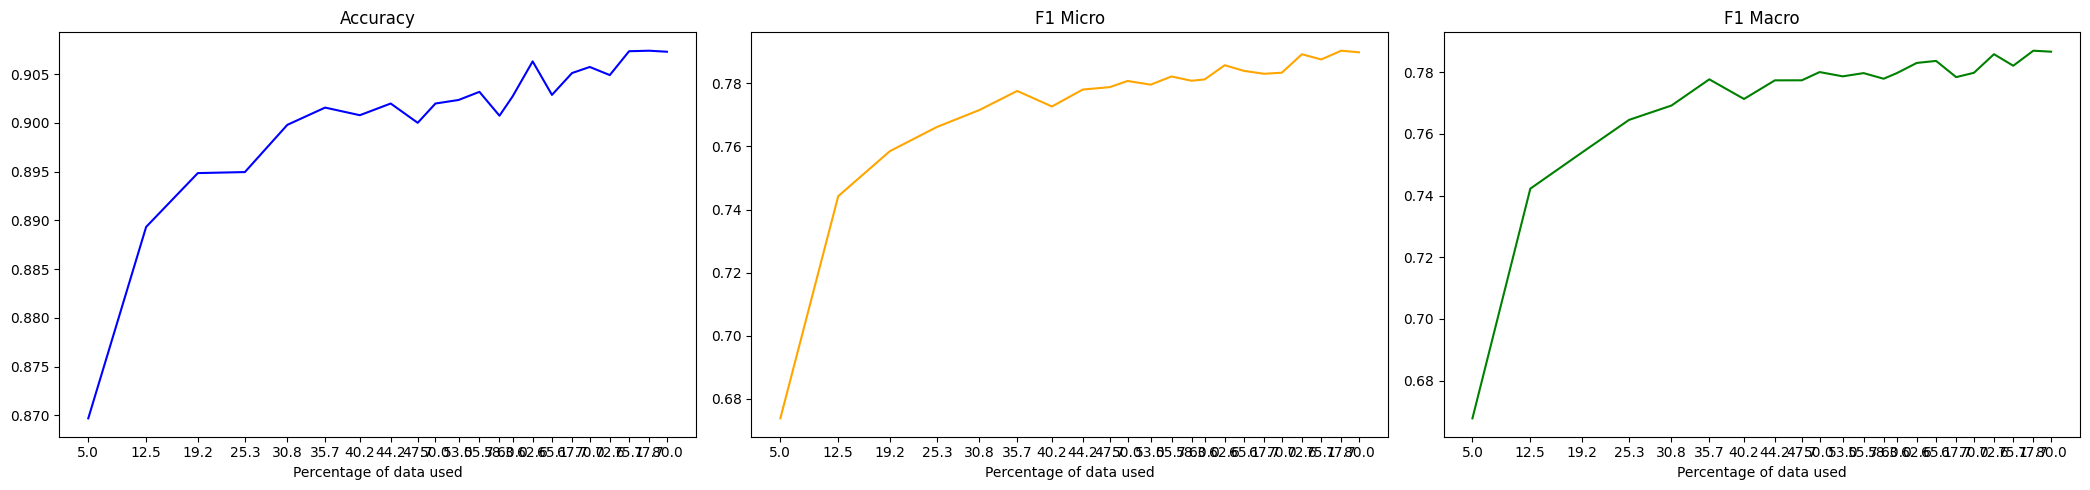

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: [81, 90, 11]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6045, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4429, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3839, Accuracy: 0.8116, F1 Micro: 0.2087, F1 Macro: 0.1506
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3762, Accuracy: 0.8338, F1 Micro: 0.4095, F1 Macro: 0.342
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3143, Accuracy: 0.8447, F1 Micro: 0.4918, F1 Macro: 0.4438
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2621, Accuracy: 0.8547, F1 Micro: 0.565, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2351, Accuracy: 0.8594, F1 Micro: 0.6053, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1834, Accuracy: 0.8698, F1 Micro: 0.6445, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1462, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5934, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.439, Accuracy: 0.7909, F1 Micro: 0.0388, F1 Macro: 0.034
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3734, Accuracy: 0.8158, F1 Micro: 0.2398, F1 Macro: 0.1687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3544, Accuracy: 0.8344, F1 Micro: 0.4137, F1 Macro: 0.3332
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2904, Accuracy: 0.8481, F1 Micro: 0.5272, F1 Macro: 0.4925
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2499, Accuracy: 0.8531, F1 Micro: 0.5595, F1 Macro: 0.547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2281, Accuracy: 0.8608, F1 Micro: 0.607, F1 Macro: 0.5951
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1774, Accuracy: 0.8648, F1 Micro: 0.6211, F1 Macro: 0.6062
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1432, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6052, Accuracy: 0.788, F1 Micro: 0.0117, F1 Macro: 0.0106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4376, Accuracy: 0.7931, F1 Micro: 0.0583, F1 Macro: 0.0499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3737, Accuracy: 0.8203, F1 Micro: 0.274, F1 Macro: 0.1872
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3629, Accuracy: 0.8316, F1 Micro: 0.3896, F1 Macro: 0.2908
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3015, Accuracy: 0.842, F1 Micro: 0.4648, F1 Macro: 0.4003
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2601, Accuracy: 0.8594, F1 Micro: 0.5917, F1 Macro: 0.565
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2378, Accuracy: 0.8631, F1 Micro: 0.6158, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1836, Accuracy: 0.8686, F1 Micro: 0.6453, F1 Macro: 0.6355
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5479, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4222, Accuracy: 0.8434, F1 Micro: 0.4765, F1 Macro: 0.412
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3269, Accuracy: 0.8598, F1 Micro: 0.5883, F1 Macro: 0.5746
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2563, Accuracy: 0.8695, F1 Micro: 0.6393, F1 Macro: 0.6386
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2222, Accuracy: 0.8834, F1 Micro: 0.6958, F1 Macro: 0.6884
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1754, Accuracy: 0.8911, F1 Micro: 0.7371, F1 Macro: 0.7332
Epoch 7/10, Train Loss: 0.1293, Accuracy: 0.8863, F1 Micro: 0.7102, F1 Macro: 0.7098
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.8872, F1 Micro: 0.7146, F1 Macro: 0.711
Epoch 9/10, Train Loss: 0.0914, Accuracy: 0.8845, F1 Micro: 0.6914, F1 Macro: 0.6747
Epoch 10/10, Train Loss: 0.0722, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.538, Accuracy: 0.788, F1 Micro: 0.0117, F1 Macro: 0.0106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4036, Accuracy: 0.8534, F1 Micro: 0.5653, F1 Macro: 0.5528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3166, Accuracy: 0.857, F1 Micro: 0.6078, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2582, Accuracy: 0.8662, F1 Micro: 0.6222, F1 Macro: 0.6159
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2261, Accuracy: 0.8875, F1 Micro: 0.7243, F1 Macro: 0.7229
Epoch 6/10, Train Loss: 0.1751, Accuracy: 0.8867, F1 Micro: 0.7182, F1 Macro: 0.7145
Epoch 7/10, Train Loss: 0.1318, Accuracy: 0.8836, F1 Micro: 0.6945, F1 Macro: 0.6874
Epoch 8/10, Train Loss: 0.1103, Accuracy: 0.8789, F1 Micro: 0.6729, F1 Macro: 0.6675
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0963, Accuracy: 0.8898, F1 Micro: 0.742, F1 Macro: 0.7355
Epoch 10/10, Train Loss: 0.073, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5407, Accuracy: 0.7956, F1 Micro: 0.0802, F1 Macro: 0.0667
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4125, Accuracy: 0.8411, F1 Micro: 0.4518, F1 Macro: 0.3798
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3243, Accuracy: 0.8619, F1 Micro: 0.6126, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2592, Accuracy: 0.8683, F1 Micro: 0.6311, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2169, Accuracy: 0.8839, F1 Micro: 0.6981, F1 Macro: 0.6908
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1819, Accuracy: 0.8842, F1 Micro: 0.7021, F1 Macro: 0.6963
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1288, Accuracy: 0.8844, F1 Micro: 0.7026, F1 Macro: 0.6956
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.8886, F1 Micro: 0.7156, F1 Macro: 0.7083
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5231, Accuracy: 0.8184, F1 Micro: 0.2923, F1 Macro: 0.2291
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3758, Accuracy: 0.8594, F1 Micro: 0.5872, F1 Macro: 0.5724
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2913, Accuracy: 0.8695, F1 Micro: 0.6237, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2293, Accuracy: 0.888, F1 Micro: 0.7122, F1 Macro: 0.6989
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1883, Accuracy: 0.8895, F1 Micro: 0.7576, F1 Macro: 0.7546
Epoch 6/10, Train Loss: 0.1601, Accuracy: 0.892, F1 Micro: 0.7356, F1 Macro: 0.7288
Epoch 7/10, Train Loss: 0.1106, Accuracy: 0.8955, F1 Micro: 0.7572, F1 Macro: 0.7536
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.8967, F1 Micro: 0.7514, F1 Macro: 0.7421
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.8961, F1 Micro: 0.7453, F1 Macro: 0.7387
Epoch 10/10, Train Loss: 0.0633, Accuracy: 0.8928, F1 Micro: 0.7297, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5144, Accuracy: 0.83, F1 Micro: 0.3696, F1 Macro: 0.3043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3672, Accuracy: 0.8616, F1 Micro: 0.6117, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.296, Accuracy: 0.8752, F1 Micro: 0.6647, F1 Macro: 0.6611
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2352, Accuracy: 0.8914, F1 Micro: 0.7413, F1 Macro: 0.7348
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1921, Accuracy: 0.8955, F1 Micro: 0.7632, F1 Macro: 0.757
Epoch 6/10, Train Loss: 0.1635, Accuracy: 0.8917, F1 Micro: 0.7298, F1 Macro: 0.7166
Epoch 7/10, Train Loss: 0.1167, Accuracy: 0.893, F1 Micro: 0.7424, F1 Macro: 0.7378
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.8944, F1 Micro: 0.7474, F1 Macro: 0.7376
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.8925, F1 Micro: 0.7388, F1 Macro: 0.7293
Epoch 10/10, Train Loss: 0.0608, Accuracy: 0.8936, F1 Micro: 0.7454, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5145, Accuracy: 0.8406, F1 Micro: 0.4864, F1 Macro: 0.3807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3749, Accuracy: 0.8683, F1 Micro: 0.648, F1 Macro: 0.6365
Epoch 3/10, Train Loss: 0.2945, Accuracy: 0.8733, F1 Micro: 0.6416, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2355, Accuracy: 0.8922, F1 Micro: 0.7378, F1 Macro: 0.7312
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1918, Accuracy: 0.8969, F1 Micro: 0.7621, F1 Macro: 0.7534
Epoch 6/10, Train Loss: 0.1611, Accuracy: 0.8938, F1 Micro: 0.7338, F1 Macro: 0.72
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.8939, F1 Micro: 0.7465, F1 Macro: 0.7404
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.8938, F1 Micro: 0.747, F1 Macro: 0.7412
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.8934, F1 Micro: 0.7281, F1 Macro: 0.7163
Epoch 10/10, Train Loss: 0.0624, Accuracy: 0.8928, F1 Micro: 0.7349, F1 Macro: 0.7281
Model 3 - Iteration 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4956, Accuracy: 0.8397, F1 Micro: 0.4617, F1 Macro: 0.3958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3404, Accuracy: 0.873, F1 Micro: 0.6945, F1 Macro: 0.6987
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2724, Accuracy: 0.8916, F1 Micro: 0.7204, F1 Macro: 0.7164
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2208, Accuracy: 0.8953, F1 Micro: 0.7639, F1 Macro: 0.7592
Epoch 5/10, Train Loss: 0.1703, Accuracy: 0.8959, F1 Micro: 0.7566, F1 Macro: 0.7538
Epoch 6/10, Train Loss: 0.1368, Accuracy: 0.8955, F1 Micro: 0.7549, F1 Macro: 0.7537
Epoch 7/10, Train Loss: 0.1184, Accuracy: 0.8897, F1 Micro: 0.6996, F1 Macro: 0.6817
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.8942, F1 Micro: 0.7393, F1 Macro: 0.7348
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.8969, F1 Micro: 0.7621, F1 Macro: 0.7594
Epoch 10/10, Train Loss: 0.0552, Accuracy: 0.8928, F1 Micro: 0.7559, F1 Macro: 0.7493
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.484, Accuracy: 0.843, F1 Micro: 0.4785, F1 Macro: 0.4284
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3333, Accuracy: 0.8684, F1 Micro: 0.6881, F1 Macro: 0.6926
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2755, Accuracy: 0.89, F1 Micro: 0.7254, F1 Macro: 0.7251
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.226, Accuracy: 0.8933, F1 Micro: 0.7577, F1 Macro: 0.7523
Epoch 5/10, Train Loss: 0.1764, Accuracy: 0.8891, F1 Micro: 0.7577, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1381, Accuracy: 0.8958, F1 Micro: 0.7619, F1 Macro: 0.7604
Epoch 7/10, Train Loss: 0.12, Accuracy: 0.8952, F1 Micro: 0.7408, F1 Macro: 0.7273
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.8944, F1 Micro: 0.7472, F1 Macro: 0.7392
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.8944, F1 Micro: 0.7577, F1 Macro: 0.7514
Epoch 10/10, Train Loss: 0.0552, Accuracy: 0.8961, F1 Micro: 0.7507, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4878, Accuracy: 0.8356, F1 Micro: 0.407, F1 Macro: 0.3347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3373, Accuracy: 0.8756, F1 Micro: 0.6971, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.274, Accuracy: 0.892, F1 Micro: 0.7517, F1 Macro: 0.7501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.223, Accuracy: 0.8908, F1 Micro: 0.7644, F1 Macro: 0.7621
Epoch 5/10, Train Loss: 0.1776, Accuracy: 0.8952, F1 Micro: 0.7643, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1434, Accuracy: 0.8938, F1 Micro: 0.7674, F1 Macro: 0.7694
Epoch 7/10, Train Loss: 0.1253, Accuracy: 0.8938, F1 Micro: 0.7308, F1 Macro: 0.7195
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.8966, F1 Micro: 0.7622, F1 Macro: 0.7593
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.8958, F1 Micro: 0.7525, F1 Macro: 0.7453
Epoch 10/10, Train Loss: 0.0516, Accuracy: 0.8958, F1 Micro: 0.7538, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4783, Accuracy: 0.8537, F1 Micro: 0.5329, F1 Macro: 0.5034
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3148, Accuracy: 0.877, F1 Micro: 0.6681, F1 Macro: 0.6627
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2535, Accuracy: 0.8906, F1 Micro: 0.7036, F1 Macro: 0.6784
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2043, Accuracy: 0.8927, F1 Micro: 0.7224, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.8963, F1 Micro: 0.7454, F1 Macro: 0.7275
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1181, Accuracy: 0.8986, F1 Micro: 0.7671, F1 Macro: 0.765
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.8959, F1 Micro: 0.7582, F1 Macro: 0.7548
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.8939, F1 Micro: 0.7539, F1 Macro: 0.7442
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.8969, F1 Micro: 0.7566, F1 Macro: 0.7533
Epoch 10/10, Train Loss: 0.045, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4723, Accuracy: 0.8553, F1 Micro: 0.55, F1 Macro: 0.5348
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3119, Accuracy: 0.8834, F1 Micro: 0.6992, F1 Macro: 0.6961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2575, Accuracy: 0.892, F1 Micro: 0.7206, F1 Macro: 0.7018
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2058, Accuracy: 0.8983, F1 Micro: 0.7452, F1 Macro: 0.7385
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.8919, F1 Micro: 0.7383, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.897, F1 Micro: 0.7547, F1 Macro: 0.7487
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.8988, F1 Micro: 0.7484, F1 Macro: 0.7401
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.8989, F1 Micro: 0.7605, F1 Macro: 0.7509
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.8992, F1 Micro: 0.7596, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4695, Accuracy: 0.8436, F1 Micro: 0.4615, F1 Macro: 0.3929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3126, Accuracy: 0.8847, F1 Micro: 0.7015, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2585, Accuracy: 0.8927, F1 Micro: 0.7107, F1 Macro: 0.6905
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.209, Accuracy: 0.8959, F1 Micro: 0.7405, F1 Macro: 0.7324
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.8944, F1 Micro: 0.7507, F1 Macro: 0.7368
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.898, F1 Micro: 0.7695, F1 Macro: 0.7665
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.8998, F1 Micro: 0.7455, F1 Macro: 0.7371
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.8948, F1 Micro: 0.7444, F1 Macro: 0.7317
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9006, F1 Micro: 0.7554, F1 Macro: 0.748
Epoch 10/10, Train Loss: 0.0422, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4505, Accuracy: 0.8717, F1 Micro: 0.672, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3027, Accuracy: 0.8884, F1 Micro: 0.7176, F1 Macro: 0.7121
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2413, Accuracy: 0.8972, F1 Micro: 0.7424, F1 Macro: 0.7328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.8998, F1 Micro: 0.7499, F1 Macro: 0.7422
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9028, F1 Micro: 0.7722, F1 Macro: 0.7658
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9016, F1 Micro: 0.7581, F1 Macro: 0.7514
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.8944, F1 Micro: 0.7666, F1 Macro: 0.7641
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.8998, F1 Micro: 0.7649, F1 Macro: 0.7658
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9, F1 Micro: 0.7578, F1 Macro: 0.7554
Epoch 10/10, Train Loss: 0.0416, Accuracy: 0.8956, F1 Micro: 0.7594, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4365, Accuracy: 0.8708, F1 Micro: 0.6606, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3004, Accuracy: 0.8891, F1 Micro: 0.7351, F1 Macro: 0.7326
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2403, Accuracy: 0.8967, F1 Micro: 0.7393, F1 Macro: 0.733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1951, Accuracy: 0.8995, F1 Micro: 0.7532, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9011, F1 Micro: 0.7594, F1 Macro: 0.7498
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9002, F1 Micro: 0.7491, F1 Macro: 0.741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.8958, F1 Micro: 0.7629, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.8984, F1 Micro: 0.7721, F1 Macro: 0.773
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9019, F1 Micro: 0.7706, F1 Macro: 0.766
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4463, Accuracy: 0.8653, F1 Micro: 0.6031, F1 Macro: 0.5368
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3066, Accuracy: 0.8911, F1 Micro: 0.7272, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2425, Accuracy: 0.8991, F1 Micro: 0.7527, F1 Macro: 0.7473
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1942, Accuracy: 0.8981, F1 Micro: 0.7562, F1 Macro: 0.7542
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.8972, F1 Micro: 0.7418, F1 Macro: 0.7292
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.8959, F1 Micro: 0.7483, F1 Macro: 0.7413
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.8905, F1 Micro: 0.7664, F1 Macro: 0.7675
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.8983, F1 Micro: 0.7652, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.8973, F1 Micro: 0.7608, F1 Macro: 0.7569
Epoch 10/10, Train Loss: 0.0387, Accuracy: 0.8961, F1 Micro: 0.7604, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4537, Accuracy: 0.8741, F1 Micro: 0.6747, F1 Macro: 0.6717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2896, Accuracy: 0.8953, F1 Micro: 0.746, F1 Macro: 0.7377
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2383, Accuracy: 0.8992, F1 Micro: 0.7649, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.9, F1 Micro: 0.7706, F1 Macro: 0.7642
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.8991, F1 Micro: 0.7658, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1118, Accuracy: 0.8991, F1 Micro: 0.7729, F1 Macro: 0.771
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.8988, F1 Micro: 0.772, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.8983, F1 Micro: 0.763, F1 Macro: 0.7601
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.8975, F1 Micro: 0.7644, F1 Macro: 0.7624
Epoch 10/10, Train Loss: 0.0378, Accuracy: 0.8975, F1 Micro: 0.7645, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.447, Accuracy: 0.8703, F1 Micro: 0.6623, F1 Macro: 0.6662
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2863, Accuracy: 0.8894, F1 Micro: 0.7289, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2384, Accuracy: 0.8947, F1 Micro: 0.7586, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1907, Accuracy: 0.8989, F1 Micro: 0.7708, F1 Macro: 0.766
Epoch 5/10, Train Loss: 0.1593, Accuracy: 0.8963, F1 Micro: 0.7543, F1 Macro: 0.7432
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.892, F1 Micro: 0.768, F1 Macro: 0.7695
Epoch 7/10, Train Loss: 0.0881, Accuracy: 0.898, F1 Micro: 0.7645, F1 Macro: 0.7617
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9003, F1 Micro: 0.7675, F1 Macro: 0.7658
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.898, F1 Micro: 0.7588, F1 Macro: 0.7525
Epoch 10/10, Train Loss: 0.0385, Accuracy: 0.8983, F1 Micro: 0.7694, F1 Macro: 0.7667
Model 2 - Iteration 312

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4488, Accuracy: 0.8747, F1 Micro: 0.6843, F1 Macro: 0.6801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2884, Accuracy: 0.8939, F1 Micro: 0.7357, F1 Macro: 0.7233
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2417, Accuracy: 0.8978, F1 Micro: 0.7632, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.8998, F1 Micro: 0.7726, F1 Macro: 0.7695
Epoch 5/10, Train Loss: 0.1595, Accuracy: 0.8977, F1 Micro: 0.7444, F1 Macro: 0.738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.8997, F1 Micro: 0.7762, F1 Macro: 0.7762
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.8989, F1 Micro: 0.7754, F1 Macro: 0.7749
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9027, F1 Micro: 0.7752, F1 Macro: 0.7735
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.9, F1 Micro: 0.7635, F1 Macro: 0.7614
Epoch 10/10, Train Loss: 0.0369, Accuracy: 0.9016, F1 Micro: 0.768, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.45, Accuracy: 0.8622, F1 Micro: 0.5698, F1 Macro: 0.5138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2968, Accuracy: 0.893, F1 Micro: 0.7354, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2292, Accuracy: 0.8981, F1 Micro: 0.7545, F1 Macro: 0.7527
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1894, Accuracy: 0.8986, F1 Micro: 0.7634, F1 Macro: 0.7557
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.8988, F1 Micro: 0.7575, F1 Macro: 0.7556
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.8989, F1 Micro: 0.7489, F1 Macro: 0.7369
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.8983, F1 Micro: 0.7472, F1 Macro: 0.737
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.8989, F1 Micro: 0.7561, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.898, F1 Micro: 0.7688, F1 Macro: 0.7669
Epoch 10/10, Train Loss: 0.0424, Accuracy: 0.9006, F1 Micro: 0.7573, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4425, Accuracy: 0.8711, F1 Micro: 0.6325, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2945, Accuracy: 0.8955, F1 Micro: 0.7475, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2274, Accuracy: 0.8991, F1 Micro: 0.7542, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.8969, F1 Micro: 0.7678, F1 Macro: 0.7639
Epoch 5/10, Train Loss: 0.1491, Accuracy: 0.8973, F1 Micro: 0.7478, F1 Macro: 0.7431
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.8967, F1 Micro: 0.7547, F1 Macro: 0.7504
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.8973, F1 Micro: 0.7522, F1 Macro: 0.7401
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.8983, F1 Micro: 0.7647, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9013, F1 Micro: 0.7692, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0464, Accuracy: 0.8998, F1 Micro: 0.7672, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4433, Accuracy: 0.883, F1 Micro: 0.7022, F1 Macro: 0.6963
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2918, Accuracy: 0.8961, F1 Micro: 0.7482, F1 Macro: 0.746
Epoch 3/10, Train Loss: 0.225, Accuracy: 0.8964, F1 Micro: 0.7482, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1902, Accuracy: 0.8941, F1 Micro: 0.7664, F1 Macro: 0.7624
Epoch 5/10, Train Loss: 0.1488, Accuracy: 0.8988, F1 Micro: 0.7612, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9034, F1 Micro: 0.7689, F1 Macro: 0.7625
Epoch 7/10, Train Loss: 0.0883, Accuracy: 0.9013, F1 Micro: 0.7685, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.8991, F1 Micro: 0.7673, F1 Macro: 0.7617
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9006, F1 Micro: 0.7637, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0436, Accuracy: 0.9023, F1 Micro: 0.7698, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4268, Accuracy: 0.8789, F1 Micro: 0.7179, F1 Macro: 0.7178
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.273, Accuracy: 0.9009, F1 Micro: 0.7633, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2259, Accuracy: 0.9011, F1 Micro: 0.7719, F1 Macro: 0.7749
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9038, F1 Micro: 0.7645, F1 Macro: 0.7537
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9039, F1 Micro: 0.7652, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9042, F1 Micro: 0.7813, F1 Macro: 0.7748
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.8947, F1 Micro: 0.7752, F1 Macro: 0.7749
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9002, F1 Micro: 0.7805, F1 Macro: 0.7808
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9003, F1 Micro: 0.7761, F1 Macro: 0.7741
Epoch 10/10, Train Loss: 0.0366, Accuracy: 0.9006, F1 Micro: 0.7711, F1 Macro: 0.7672
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4208, Accuracy: 0.872, F1 Micro: 0.7129, F1 Macro: 0.7152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2742, Accuracy: 0.8966, F1 Micro: 0.7593, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2307, Accuracy: 0.9009, F1 Micro: 0.7664, F1 Macro: 0.7652
Epoch 4/10, Train Loss: 0.1901, Accuracy: 0.8997, F1 Micro: 0.7438, F1 Macro: 0.73
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.8995, F1 Micro: 0.7511, F1 Macro: 0.7438
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9022, F1 Micro: 0.7777, F1 Macro: 0.7738
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.8942, F1 Micro: 0.7715, F1 Macro: 0.7691
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9025, F1 Micro: 0.7793, F1 Macro: 0.7768
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.8994, F1 Micro: 0.7643, F1 Macro: 0.7599
Epoch 10/10, Train Loss: 0.035, Accuracy: 0.9, F1 Micro: 0.7679, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4239, Accuracy: 0.8772, F1 Micro: 0.7177, F1 Macro: 0.717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2748, Accuracy: 0.8995, F1 Micro: 0.7637, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2296, Accuracy: 0.9028, F1 Micro: 0.7748, F1 Macro: 0.7733
Epoch 4/10, Train Loss: 0.19, Accuracy: 0.9038, F1 Micro: 0.7563, F1 Macro: 0.7447
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9031, F1 Micro: 0.7538, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.9008, F1 Micro: 0.7765, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9019, F1 Micro: 0.7776, F1 Macro: 0.7725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9039, F1 Micro: 0.7815, F1 Macro: 0.7815
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9019, F1 Micro: 0.7674, F1 Macro: 0.7631
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4235, Accuracy: 0.8833, F1 Micro: 0.7108, F1 Macro: 0.7057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.276, Accuracy: 0.8978, F1 Micro: 0.7525, F1 Macro: 0.7489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2286, Accuracy: 0.9019, F1 Micro: 0.7716, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.184, Accuracy: 0.9033, F1 Micro: 0.7765, F1 Macro: 0.7716
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9014, F1 Micro: 0.775, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.9033, F1 Micro: 0.7804, F1 Macro: 0.7796
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.8964, F1 Micro: 0.7749, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9023, F1 Micro: 0.7693, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.8981, F1 Micro: 0.7753, F1 Macro: 0.7765
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4182, Accuracy: 0.878, F1 Micro: 0.7049, F1 Macro: 0.7006
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.8936, F1 Micro: 0.739, F1 Macro: 0.7333
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2334, Accuracy: 0.8983, F1 Micro: 0.7674, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9025, F1 Micro: 0.7762, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9006, F1 Micro: 0.7813, F1 Macro: 0.7797
Epoch 6/10, Train Loss: 0.1088, Accuracy: 0.8977, F1 Micro: 0.7731, F1 Macro: 0.7732
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.8994, F1 Micro: 0.7648, F1 Macro: 0.7611
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.8975, F1 Micro: 0.769, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.8973, F1 Micro: 0.7707, F1 Macro: 0.7698
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0.9019, F1 Micro: 0.7793, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4173, Accuracy: 0.8823, F1 Micro: 0.7224, F1 Macro: 0.7171
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2761, Accuracy: 0.8945, F1 Micro: 0.7385, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2308, Accuracy: 0.9003, F1 Micro: 0.7752, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1829, Accuracy: 0.9044, F1 Micro: 0.7825, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9042, F1 Micro: 0.783, F1 Macro: 0.7816
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9048, F1 Micro: 0.7891, F1 Macro: 0.7874
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.8997, F1 Micro: 0.7777, F1 Macro: 0.7764
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9042, F1 Micro: 0.7767, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.907, F1 Micro: 0.785, F1 Macro: 0.7836
Epoch 10/10, Train Loss: 0.0359, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4105, Accuracy: 0.8739, F1 Micro: 0.6347, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2749, Accuracy: 0.8975, F1 Micro: 0.7578, F1 Macro: 0.7499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.213, Accuracy: 0.9027, F1 Micro: 0.7818, F1 Macro: 0.7809
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.9011, F1 Micro: 0.7707, F1 Macro: 0.7654
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9033, F1 Micro: 0.7681, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9064, F1 Micro: 0.7823, F1 Macro: 0.7812
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9028, F1 Micro: 0.7628, F1 Macro: 0.7588
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9033, F1 Micro: 0.7649, F1 Macro: 0.7598
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9009, F1 Micro: 0.7788, F1 Macro: 0.7745
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.9002, F1 Micro: 0.7743, F1 Macro: 0.773
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.403, Accuracy: 0.8747, F1 Micro: 0.6504, F1 Macro: 0.6314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2746, Accuracy: 0.8981, F1 Micro: 0.7599, F1 Macro: 0.749
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2112, Accuracy: 0.9, F1 Micro: 0.7758, F1 Macro: 0.7738
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9034, F1 Micro: 0.7671, F1 Macro: 0.7587
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9027, F1 Micro: 0.771, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9041, F1 Micro: 0.782, F1 Macro: 0.778
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9014, F1 Micro: 0.7726, F1 Macro: 0.7701
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9019, F1 Micro: 0.7744, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.8994, F1 Micro: 0.7672, F1 Macro: 0.7606
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.9014, F1 Micro: 0.7774, F1 Macro: 0.7759
Model 2 - Iteration 4120: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4074, Accuracy: 0.8797, F1 Micro: 0.6652, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.272, Accuracy: 0.8977, F1 Micro: 0.7568, F1 Macro: 0.7507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2132, Accuracy: 0.9, F1 Micro: 0.7773, F1 Macro: 0.7751
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9019, F1 Micro: 0.7674, F1 Macro: 0.7596
Epoch 5/10, Train Loss: 0.1376, Accuracy: 0.9025, F1 Micro: 0.7652, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9031, F1 Micro: 0.7784, F1 Macro: 0.7775
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9023, F1 Micro: 0.7705, F1 Macro: 0.767
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9041, F1 Micro: 0.7761, F1 Macro: 0.7747
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9014, F1 Micro: 0.7664, F1 Macro: 0.7622
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.8992, F1 Micro: 0.7624, F1 Macro: 0.7597
Model 3 - Iteration 41

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4164, Accuracy: 0.8767, F1 Micro: 0.6689, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.8986, F1 Micro: 0.7653, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.9023, F1 Micro: 0.7834, F1 Macro: 0.7826
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9073, F1 Micro: 0.7862, F1 Macro: 0.7828
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.8995, F1 Micro: 0.7443, F1 Macro: 0.7313
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.9017, F1 Micro: 0.7712, F1 Macro: 0.7633
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9045, F1 Micro: 0.7731, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9009, F1 Micro: 0.7758, F1 Macro: 0.7707
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9033, F1 Micro: 0.7776, F1 Macro: 0.7735
Epoch 10/10, Train Loss: 0.0401, Accuracy: 0.9033, F1 Micro: 0.7737, F1 Macro: 0.7692
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4123, Accuracy: 0.8789, F1 Micro: 0.6901, F1 Macro: 0.6748
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.9, F1 Micro: 0.7651, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2229, Accuracy: 0.9008, F1 Micro: 0.7804, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.9059, F1 Micro: 0.7809, F1 Macro: 0.7757
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9003, F1 Micro: 0.7502, F1 Macro: 0.7388
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9038, F1 Micro: 0.7727, F1 Macro: 0.7656
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9034, F1 Micro: 0.7759, F1 Macro: 0.7718
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.8997, F1 Micro: 0.7633, F1 Macro: 0.7605
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9025, F1 Micro: 0.7687, F1 Macro: 0.7617
Epoch 10/10, Train Loss: 0.0364, Accuracy: 0.9013, F1 Micro: 0.7748, F1 Macro: 0.7697
Model 2 - Iteration 4330

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4146, Accuracy: 0.8794, F1 Micro: 0.6764, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2642, Accuracy: 0.8991, F1 Micro: 0.7661, F1 Macro: 0.7574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2239, Accuracy: 0.9034, F1 Micro: 0.7836, F1 Macro: 0.7831
Epoch 4/10, Train Loss: 0.1872, Accuracy: 0.9069, F1 Micro: 0.7815, F1 Macro: 0.7793
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9014, F1 Micro: 0.7526, F1 Macro: 0.741
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9019, F1 Micro: 0.7725, F1 Macro: 0.7665
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9038, F1 Micro: 0.7677, F1 Macro: 0.7601
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9023, F1 Micro: 0.7762, F1 Macro: 0.7702
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9047, F1 Micro: 0.7686, F1 Macro: 0.7605
Epoch 10/10, Train Loss: 0.0353, Accuracy: 0.9044, F1 Micro: 0.7813, F1 Macro: 0.7764
Model 3 - Iteration 4330: Accuracy: 0.9034, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4105, Accuracy: 0.8833, F1 Micro: 0.6979, F1 Macro: 0.6881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2675, Accuracy: 0.898, F1 Micro: 0.7444, F1 Macro: 0.7328
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.9028, F1 Micro: 0.7653, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1712, Accuracy: 0.9016, F1 Micro: 0.7735, F1 Macro: 0.7703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9028, F1 Micro: 0.7745, F1 Macro: 0.765
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9028, F1 Micro: 0.7705, F1 Macro: 0.7614
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.8978, F1 Micro: 0.7485, F1 Macro: 0.7418
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9031, F1 Micro: 0.7755, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9047, F1 Micro: 0.7818, F1 Macro: 0.781
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4053, Accuracy: 0.8809, F1 Micro: 0.7007, F1 Macro: 0.6919
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.27, Accuracy: 0.8994, F1 Micro: 0.7593, F1 Macro: 0.7492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.9013, F1 Micro: 0.7602, F1 Macro: 0.7576
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9038, F1 Micro: 0.7765, F1 Macro: 0.7706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1416, Accuracy: 0.9042, F1 Micro: 0.7768, F1 Macro: 0.7691
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9022, F1 Micro: 0.7676, F1 Macro: 0.7604
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9017, F1 Micro: 0.7613, F1 Macro: 0.754
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9005, F1 Micro: 0.752, F1 Macro: 0.7451
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9034, F1 Micro: 0.7782, F1 Macro: 0.7759
Epoch 10/10, Train Loss: 0.0345, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4063, Accuracy: 0.8855, F1 Micro: 0.7173, F1 Macro: 0.7131
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2682, Accuracy: 0.898, F1 Micro: 0.7579, F1 Macro: 0.7507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2179, Accuracy: 0.9061, F1 Micro: 0.779, F1 Macro: 0.7752
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9017, F1 Micro: 0.7727, F1 Macro: 0.7701
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.9031, F1 Micro: 0.7779, F1 Macro: 0.7713
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.903, F1 Micro: 0.7564, F1 Macro: 0.7465
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9019, F1 Micro: 0.763, F1 Macro: 0.7579
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9038, F1 Micro: 0.7712, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9005, F1 Micro: 0.7798, F1 Macro: 0.7794
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9041, F1 Micro: 0.7826, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4102, Accuracy: 0.8786, F1 Micro: 0.6703, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.8953, F1 Micro: 0.7331, F1 Macro: 0.7178
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2315, Accuracy: 0.9048, F1 Micro: 0.7796, F1 Macro: 0.7742
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9022, F1 Micro: 0.7759, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9033, F1 Micro: 0.7826, F1 Macro: 0.7768
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9039, F1 Micro: 0.7751, F1 Macro: 0.7667
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0834, Accuracy: 0.9053, F1 Micro: 0.7828, F1 Macro: 0.7769
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.8972, F1 Micro: 0.7704, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.9059, F1 Micro: 0.7848, F1 Macro: 0.7823
Epoch 10/10, Train Loss: 0.0354, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4069, Accuracy: 0.873, F1 Micro: 0.6491, F1 Macro: 0.6115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2614, Accuracy: 0.8952, F1 Micro: 0.7412, F1 Macro: 0.734
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2326, Accuracy: 0.9036, F1 Micro: 0.7792, F1 Macro: 0.7753
Epoch 4/10, Train Loss: 0.1814, Accuracy: 0.9017, F1 Micro: 0.7719, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9027, F1 Micro: 0.7876, F1 Macro: 0.7856
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.9027, F1 Micro: 0.7784, F1 Macro: 0.7739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9042, F1 Micro: 0.7881, F1 Macro: 0.7891
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9056, F1 Micro: 0.7804, F1 Macro: 0.7766
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9053, F1 Micro: 0.7814, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0.9011, F1 Micro: 0.7789, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4093, Accuracy: 0.8769, F1 Micro: 0.6538, F1 Macro: 0.6185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.8983, F1 Micro: 0.7432, F1 Macro: 0.7295
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2293, Accuracy: 0.9042, F1 Micro: 0.7781, F1 Macro: 0.7708
Epoch 4/10, Train Loss: 0.1814, Accuracy: 0.9013, F1 Micro: 0.7693, F1 Macro: 0.7589
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9031, F1 Micro: 0.7749, F1 Macro: 0.7688
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.9044, F1 Micro: 0.7733, F1 Macro: 0.7646
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9061, F1 Micro: 0.7775, F1 Macro: 0.7719
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9019, F1 Micro: 0.7746, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9044, F1 Micro: 0.7792, F1 Macro: 0.7788
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9013, F1 Micro: 0.7765, F1 Macro: 0.7714
Model 3 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4024, Accuracy: 0.8872, F1 Micro: 0.7117, F1 Macro: 0.6908
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2582, Accuracy: 0.8934, F1 Micro: 0.7451, F1 Macro: 0.74
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9033, F1 Micro: 0.7703, F1 Macro: 0.7639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9106, F1 Micro: 0.7888, F1 Macro: 0.7832
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.9013, F1 Micro: 0.7697, F1 Macro: 0.7575
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9039, F1 Micro: 0.7756, F1 Macro: 0.7678
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9014, F1 Micro: 0.7636, F1 Macro: 0.7502
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.902, F1 Micro: 0.7608, F1 Macro: 0.7491
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9038, F1 Micro: 0.7717, F1 Macro: 0.7647
Epoch 10/10, Train Loss: 0.0362, Accuracy: 0.9009, F1 Micro: 0.7732, F1 Macro: 0.7696
Model 1 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3944, Accuracy: 0.8828, F1 Micro: 0.7068, F1 Macro: 0.6944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2572, Accuracy: 0.8955, F1 Micro: 0.7561, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2112, Accuracy: 0.9036, F1 Micro: 0.7726, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.9028, F1 Micro: 0.7767, F1 Macro: 0.7729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.9042, F1 Micro: 0.7786, F1 Macro: 0.7735
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9036, F1 Micro: 0.7752, F1 Macro: 0.767
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.8994, F1 Micro: 0.767, F1 Macro: 0.7604
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9047, F1 Micro: 0.7612, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.9047, F1 Micro: 0.7798, F1 Macro: 0.7777
Epoch 10/10, Train Loss: 0.0368, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3978, Accuracy: 0.8858, F1 Micro: 0.7174, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2593, Accuracy: 0.8948, F1 Micro: 0.7541, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.9039, F1 Micro: 0.7756, F1 Macro: 0.7739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9048, F1 Micro: 0.7781, F1 Macro: 0.7761
Epoch 5/10, Train Loss: 0.1344, Accuracy: 0.9048, F1 Micro: 0.7696, F1 Macro: 0.7567
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9022, F1 Micro: 0.7772, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9027, F1 Micro: 0.7787, F1 Macro: 0.7717
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9044, F1 Micro: 0.776, F1 Macro: 0.7728
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.902, F1 Micro: 0.7706, F1 Macro: 0.7645
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9044, F1 Micro: 0.7781, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3905, Accuracy: 0.8814, F1 Micro: 0.6747, F1 Macro: 0.6691
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2554, Accuracy: 0.8964, F1 Micro: 0.7275, F1 Macro: 0.7138
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.9047, F1 Micro: 0.7729, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9067, F1 Micro: 0.7891, F1 Macro: 0.7852
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9081, F1 Micro: 0.7889, F1 Macro: 0.7837
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9064, F1 Micro: 0.7813, F1 Macro: 0.7749
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9005, F1 Micro: 0.7803, F1 Macro: 0.7797
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9056, F1 Micro: 0.7829, F1 Macro: 0.7793
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9017, F1 Micro: 0.7683, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9039, F1 Micro: 0.7764, F1 Macro: 0.7709
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3855, Accuracy: 0.8809, F1 Micro: 0.6854, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.8936, F1 Micro: 0.7235, F1 Macro: 0.7132
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.9044, F1 Micro: 0.7662, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1763, Accuracy: 0.9025, F1 Micro: 0.777, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9036, F1 Micro: 0.7789, F1 Macro: 0.7712
Epoch 6/10, Train Loss: 0.0975, Accuracy: 0.9017, F1 Micro: 0.7746, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9025, F1 Micro: 0.7832, F1 Macro: 0.7824
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9017, F1 Micro: 0.7773, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9016, F1 Micro: 0.7752, F1 Macro: 0.7702
Epoch 10/10, Train Loss: 0.0358, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.387, Accuracy: 0.8792, F1 Micro: 0.6681, F1 Macro: 0.661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.8977, F1 Micro: 0.7319, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9052, F1 Micro: 0.7739, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9019, F1 Micro: 0.7831, F1 Macro: 0.7832
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.9036, F1 Micro: 0.7828, F1 Macro: 0.7778
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9033, F1 Micro: 0.7787, F1 Macro: 0.7767
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9038, F1 Micro: 0.7739, F1 Macro: 0.7629
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9052, F1 Micro: 0.7802, F1 Macro: 0.7813
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9003, F1 Micro: 0.7725, F1 Macro: 0.7705
Epoch 10/10, Train Loss: 0.0366, Accuracy: 0.9055, F1 Micro: 0.7781, F1 Macro: 0.7738
Model 3 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3916, Accuracy: 0.8845, F1 Micro: 0.698, F1 Macro: 0.6915
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2689, Accuracy: 0.8992, F1 Micro: 0.7758, F1 Macro: 0.7747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.213, Accuracy: 0.9058, F1 Micro: 0.7776, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9031, F1 Micro: 0.7849, F1 Macro: 0.7815
Epoch 5/10, Train Loss: 0.1338, Accuracy: 0.9023, F1 Micro: 0.7754, F1 Macro: 0.7687
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9016, F1 Micro: 0.778, F1 Macro: 0.7772
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9009, F1 Micro: 0.7812, F1 Macro: 0.7798
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.905, F1 Micro: 0.7821, F1 Macro: 0.7797
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9048, F1 Micro: 0.7772, F1 Macro: 0.7742
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.9084, F1 Micro: 0.7802, F1 Macro: 0.7753
Model 1 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3866, Accuracy: 0.882, F1 Micro: 0.6853, F1 Macro: 0.6777
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.8992, F1 Micro: 0.7722, F1 Macro: 0.7719
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.902, F1 Micro: 0.7692, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9003, F1 Micro: 0.7821, F1 Macro: 0.7806
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9016, F1 Micro: 0.7768, F1 Macro: 0.7734
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9044, F1 Micro: 0.7802, F1 Macro: 0.7779
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9036, F1 Micro: 0.7796, F1 Macro: 0.7771
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.903, F1 Micro: 0.7811, F1 Macro: 0.7782
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9058, F1 Micro: 0.7706, F1 Macro: 0.7648
Epoch 10/10, Train Loss: 0.0375, Accuracy: 0.9019, F1 Micro: 0.7795, F1 Macro: 0.7769
Model 2 - Iteration 5263: Accuracy: 0.9003, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8856, F1 Micro: 0.7174, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2707, Accuracy: 0.8989, F1 Micro: 0.7735, F1 Macro: 0.773
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2167, Accuracy: 0.9038, F1 Micro: 0.7742, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9066, F1 Micro: 0.7916, F1 Macro: 0.7906
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9059, F1 Micro: 0.7839, F1 Macro: 0.7802
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.9048, F1 Micro: 0.7759, F1 Macro: 0.7738
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9064, F1 Micro: 0.7848, F1 Macro: 0.7802
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9045, F1 Micro: 0.7885, F1 Macro: 0.788
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9078, F1 Micro: 0.7905, F1 Macro: 0.7879
Epoch 10/10, Train Loss: 0.0357, Accuracy: 0.9023, F1 Micro: 0.7784, F1 Macro: 0.7768
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3911, Accuracy: 0.8839, F1 Micro: 0.7005, F1 Macro: 0.6822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2563, Accuracy: 0.9016, F1 Micro: 0.7624, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.9041, F1 Micro: 0.7729, F1 Macro: 0.7685
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9039, F1 Micro: 0.7696, F1 Macro: 0.7632
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9036, F1 Micro: 0.7674, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9061, F1 Micro: 0.7822, F1 Macro: 0.7784
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9031, F1 Micro: 0.7775, F1 Macro: 0.7735
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.8991, F1 Micro: 0.7703, F1 Macro: 0.7644
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9013, F1 Micro: 0.7778, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9025, F1 Micro: 0.7824, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3831, Accuracy: 0.8873, F1 Micro: 0.7272, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.9011, F1 Micro: 0.7589, F1 Macro: 0.7476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.9066, F1 Micro: 0.7733, F1 Macro: 0.7642
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9023, F1 Micro: 0.7676, F1 Macro: 0.7607
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.902, F1 Micro: 0.7584, F1 Macro: 0.7476
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.907, F1 Micro: 0.7817, F1 Macro: 0.7776
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.9067, F1 Micro: 0.7864, F1 Macro: 0.7823
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9002, F1 Micro: 0.766, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.8986, F1 Micro: 0.7769, F1 Macro: 0.777
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9036, F1 Micro: 0.7854, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3853, Accuracy: 0.8852, F1 Micro: 0.7047, F1 Macro: 0.6865
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2558, Accuracy: 0.8995, F1 Micro: 0.7611, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2099, Accuracy: 0.9047, F1 Micro: 0.7696, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9034, F1 Micro: 0.7733, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9075, F1 Micro: 0.7761, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9066, F1 Micro: 0.7844, F1 Macro: 0.7835
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9048, F1 Micro: 0.7755, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9033, F1 Micro: 0.7745, F1 Macro: 0.7684
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9028, F1 Micro: 0.7828, F1 Macro: 0.7808
Epoch 10/10, Train Loss: 0.031, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3761, Accuracy: 0.8909, F1 Micro: 0.7336, F1 Macro: 0.7261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.9005, F1 Micro: 0.7732, F1 Macro: 0.7702
Epoch 3/10, Train Loss: 0.2096, Accuracy: 0.9034, F1 Micro: 0.7638, F1 Macro: 0.7601
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9044, F1 Micro: 0.7716, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9002, F1 Micro: 0.7803, F1 Macro: 0.7772
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9041, F1 Micro: 0.7748, F1 Macro: 0.7655
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.9008, F1 Micro: 0.7743, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9044, F1 Micro: 0.7814, F1 Macro: 0.7768
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9019, F1 Micro: 0.7779, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.903, F1 Micro: 0.7789, F1 Macro: 0.778
Model 1 - Iteration 564

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3744, Accuracy: 0.8903, F1 Micro: 0.7339, F1 Macro: 0.7223
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.247, Accuracy: 0.9005, F1 Micro: 0.7723, F1 Macro: 0.7686
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9017, F1 Micro: 0.7517, F1 Macro: 0.7466
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9083, F1 Micro: 0.7812, F1 Macro: 0.7739
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9005, F1 Micro: 0.778, F1 Macro: 0.7734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.9033, F1 Micro: 0.7829, F1 Macro: 0.7795
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9034, F1 Micro: 0.7764, F1 Macro: 0.7692
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9009, F1 Micro: 0.7777, F1 Macro: 0.7735
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9009, F1 Micro: 0.7761, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.9036, F1 Micro: 0.7772, F1 Macro: 0.7745
Model 2 - Iteration 564

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3739, Accuracy: 0.892, F1 Micro: 0.7354, F1 Macro: 0.7235
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2481, Accuracy: 0.8995, F1 Micro: 0.7703, F1 Macro: 0.768
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.903, F1 Micro: 0.7654, F1 Macro: 0.7625
Epoch 4/10, Train Loss: 0.1639, Accuracy: 0.9028, F1 Micro: 0.7695, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9041, F1 Micro: 0.7827, F1 Macro: 0.7775
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9064, F1 Micro: 0.7834, F1 Macro: 0.7743
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9017, F1 Micro: 0.7821, F1 Macro: 0.78
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9025, F1 Micro: 0.7723, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9041, F1 Micro: 0.7861, F1 Macro: 0.7873
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9064, F1 Micro: 0.7843, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3697, Accuracy: 0.893, F1 Micro: 0.7319, F1 Macro: 0.724
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2432, Accuracy: 0.9017, F1 Micro: 0.7709, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.9059, F1 Micro: 0.7805, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9064, F1 Micro: 0.783, F1 Macro: 0.7786
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.9, F1 Micro: 0.7663, F1 Macro: 0.7637
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.9052, F1 Micro: 0.7688, F1 Macro: 0.7663
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9025, F1 Micro: 0.7787, F1 Macro: 0.7778
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.8991, F1 Micro: 0.7727, F1 Macro: 0.7695
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9036, F1 Micro: 0.7783, F1 Macro: 0.7759
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9003, F1 Micro: 0.7734, F1 Macro: 0.7717
Model 1 - Iteration 584

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3633, Accuracy: 0.8897, F1 Micro: 0.7283, F1 Macro: 0.7235
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.9006, F1 Micro: 0.7738, F1 Macro: 0.7698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2038, Accuracy: 0.9055, F1 Micro: 0.7818, F1 Macro: 0.7776
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.9033, F1 Micro: 0.7796, F1 Macro: 0.7755
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.902, F1 Micro: 0.7721, F1 Macro: 0.7674
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9061, F1 Micro: 0.7799, F1 Macro: 0.7774
Epoch 7/10, Train Loss: 0.0686, Accuracy: 0.9027, F1 Micro: 0.7735, F1 Macro: 0.7687
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9017, F1 Micro: 0.773, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9019, F1 Micro: 0.7821, F1 Macro: 0.783
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.8991, F1 Micro: 0.7701, F1 Macro: 0.7665
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3657, Accuracy: 0.8884, F1 Micro: 0.7295, F1 Macro: 0.7234
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.9013, F1 Micro: 0.7733, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.9073, F1 Micro: 0.7817, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1639, Accuracy: 0.9075, F1 Micro: 0.7825, F1 Macro: 0.7766
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9028, F1 Micro: 0.774, F1 Macro: 0.7695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.9087, F1 Micro: 0.7864, F1 Macro: 0.7831
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9042, F1 Micro: 0.7851, F1 Macro: 0.7812
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9, F1 Micro: 0.7743, F1 Macro: 0.7701
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9042, F1 Micro: 0.7808, F1 Macro: 0.7755
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.9003, F1 Micro: 0.7817, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3633, Accuracy: 0.8894, F1 Micro: 0.7395, F1 Macro: 0.7311
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2427, Accuracy: 0.9005, F1 Micro: 0.7806, F1 Macro: 0.7764
Epoch 3/10, Train Loss: 0.1987, Accuracy: 0.9034, F1 Micro: 0.7761, F1 Macro: 0.7657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9033, F1 Micro: 0.7871, F1 Macro: 0.7865
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.907, F1 Micro: 0.7842, F1 Macro: 0.7817
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9023, F1 Micro: 0.7705, F1 Macro: 0.7637
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9022, F1 Micro: 0.7843, F1 Macro: 0.7846
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9045, F1 Micro: 0.7806, F1 Macro: 0.7797
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.9078, F1 Micro: 0.7864, F1 Macro: 0.7841
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.905, F1 Micro: 0.785, F1 Macro: 0.7815
Model 1 - Iteration 6041: Accuracy: 0.9033, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3596, Accuracy: 0.8892, F1 Micro: 0.7348, F1 Macro: 0.7222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2417, Accuracy: 0.9014, F1 Micro: 0.7814, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.9036, F1 Micro: 0.784, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9023, F1 Micro: 0.7843, F1 Macro: 0.7854
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9038, F1 Micro: 0.7652, F1 Macro: 0.7561
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.9003, F1 Micro: 0.7721, F1 Macro: 0.7674
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9033, F1 Micro: 0.783, F1 Macro: 0.7797
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9044, F1 Micro: 0.7817, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9052, F1 Micro: 0.7759, F1 Macro: 0.7681
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9003, F1 Micro: 0.7749, F1 Macro: 0.7649
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3605, Accuracy: 0.8917, F1 Micro: 0.7438, F1 Macro: 0.7334
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2416, Accuracy: 0.9008, F1 Micro: 0.78, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1988, Accuracy: 0.9034, F1 Micro: 0.7812, F1 Macro: 0.7758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.9036, F1 Micro: 0.7852, F1 Macro: 0.7833
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.9073, F1 Micro: 0.7798, F1 Macro: 0.7781
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.9038, F1 Micro: 0.776, F1 Macro: 0.7726
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.9028, F1 Micro: 0.779, F1 Macro: 0.7792
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9027, F1 Micro: 0.7816, F1 Macro: 0.7822
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9053, F1 Micro: 0.7749, F1 Macro: 0.7699
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9047, F1 Micro: 0.7848, F1 Macro: 0.7852
Model 3 - Iteration 6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3559, Accuracy: 0.8917, F1 Micro: 0.7562, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2304, Accuracy: 0.9028, F1 Micro: 0.7642, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1868, Accuracy: 0.9039, F1 Micro: 0.7902, F1 Macro: 0.7903
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.9072, F1 Micro: 0.7914, F1 Macro: 0.7892
Epoch 5/10, Train Loss: 0.1123, Accuracy: 0.9045, F1 Micro: 0.7784, F1 Macro: 0.7726
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.9055, F1 Micro: 0.7828, F1 Macro: 0.7786
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9027, F1 Micro: 0.7699, F1 Macro: 0.7666
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9025, F1 Micro: 0.7781, F1 Macro: 0.7775
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9039, F1 Micro: 0.7703, F1 Macro: 0.7649
Epoch 10/10, Train Loss: 0.0274, Accuracy: 0.9044, F1 Micro: 0.7784, F1 Macro: 0.7724
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3539, Accuracy: 0.8895, F1 Micro: 0.7515, F1 Macro: 0.748
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2312, Accuracy: 0.9041, F1 Micro: 0.7726, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1898, Accuracy: 0.9028, F1 Micro: 0.7851, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9078, F1 Micro: 0.7891, F1 Macro: 0.7877
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.905, F1 Micro: 0.7743, F1 Macro: 0.7675
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9069, F1 Micro: 0.7842, F1 Macro: 0.7782
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.9062, F1 Micro: 0.7781, F1 Macro: 0.7717
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.8977, F1 Micro: 0.7719, F1 Macro: 0.7713
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.9055, F1 Micro: 0.7742, F1 Macro: 0.7691
Epoch 10/10, Train Loss: 0.0268, Accuracy: 0.9009, F1 Micro: 0.7648, F1 Macro: 0.7613
Model 2 - Iteration 6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3568, Accuracy: 0.8925, F1 Micro: 0.7567, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2318, Accuracy: 0.902, F1 Micro: 0.7654, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9075, F1 Micro: 0.7898, F1 Macro: 0.7871
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9044, F1 Micro: 0.7857, F1 Macro: 0.7827
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9019, F1 Micro: 0.7681, F1 Macro: 0.7575
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9034, F1 Micro: 0.781, F1 Macro: 0.7779
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9014, F1 Micro: 0.7802, F1 Macro: 0.7802
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.903, F1 Micro: 0.7757, F1 Macro: 0.7699
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.903, F1 Micro: 0.7792, F1 Macro: 0.7758
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.9008, F1 Micro: 0.7692, F1 Macro: 0.7612
Model 3 - Iteration 6218: Accuracy: 0.9075, F1 Micro: 

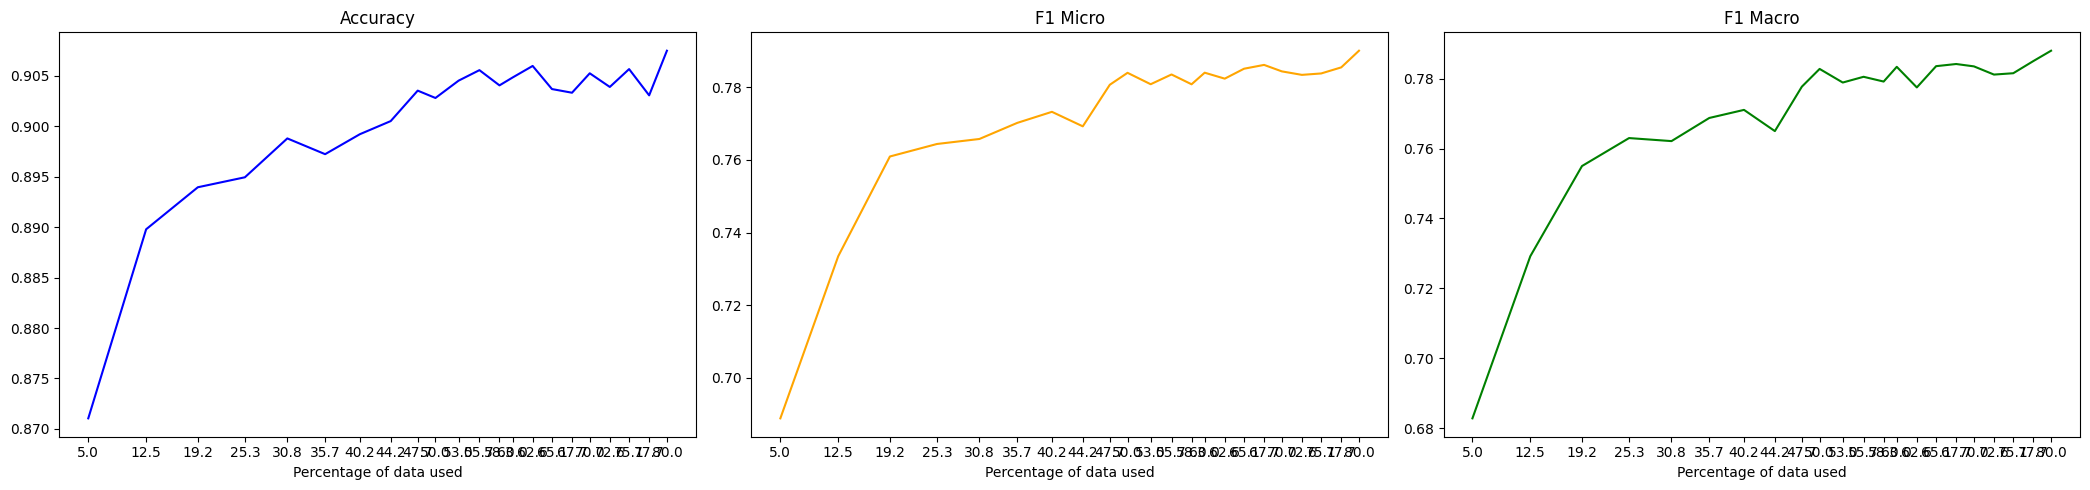

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: [14, 61, 33]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5968, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5341, Accuracy: 0.7977, F1 Micro: 0.0988, F1 Macro: 0.0805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4743, Accuracy: 0.8219, F1 Micro: 0.2893, F1 Macro: 0.1949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.39, Accuracy: 0.8345, F1 Micro: 0.4638, F1 Macro: 0.3804
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3545, Accuracy: 0.8441, F1 Micro: 0.5035, F1 Macro: 0.4353
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3005, Accuracy: 0.8581, F1 Micro: 0.6093, F1 Macro: 0.5602
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2678, Accuracy: 0.8648, F1 Micro: 0.628, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2021, Accuracy: 0.8675, F1 Micro: 0.657, F1 Macro: 0.6496
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1931, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5958, Accuracy: 0.7864, F1 Micro: 0.0015, F1 Macro: 0.001
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5369, Accuracy: 0.7869, F1 Micro: 0.0116, F1 Macro: 0.0089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5006, Accuracy: 0.825, F1 Micro: 0.3112, F1 Macro: 0.2205
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4319, Accuracy: 0.8308, F1 Micro: 0.4199, F1 Macro: 0.2911
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3838, Accuracy: 0.8431, F1 Micro: 0.4825, F1 Macro: 0.3976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3223, Accuracy: 0.8555, F1 Micro: 0.5898, F1 Macro: 0.5118
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2886, Accuracy: 0.8622, F1 Micro: 0.6358, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2259, Accuracy: 0.8672, F1 Micro: 0.6556, F1 Macro: 0.6424
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5975, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5331, Accuracy: 0.7891, F1 Micro: 0.0217, F1 Macro: 0.0195
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4706, Accuracy: 0.8233, F1 Micro: 0.2988, F1 Macro: 0.2114
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4013, Accuracy: 0.8339, F1 Micro: 0.4337, F1 Macro: 0.3452
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3537, Accuracy: 0.8436, F1 Micro: 0.5086, F1 Macro: 0.441
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2988, Accuracy: 0.8544, F1 Micro: 0.6077, F1 Macro: 0.5773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2637, Accuracy: 0.8564, F1 Micro: 0.6114, F1 Macro: 0.5816
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2036, Accuracy: 0.8642, F1 Micro: 0.6393, F1 Macro: 0.628
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1917,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5392, Accuracy: 0.7928, F1 Micro: 0.0569, F1 Macro: 0.0488
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4382, Accuracy: 0.8392, F1 Micro: 0.4939, F1 Macro: 0.403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3514, Accuracy: 0.8669, F1 Micro: 0.6627, F1 Macro: 0.6602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2786, Accuracy: 0.8798, F1 Micro: 0.7106, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2143, Accuracy: 0.8905, F1 Micro: 0.7401, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.186, Accuracy: 0.8869, F1 Micro: 0.7427, F1 Macro: 0.7439
Epoch 7/10, Train Loss: 0.1486, Accuracy: 0.8895, F1 Micro: 0.7394, F1 Macro: 0.7363
Epoch 8/10, Train Loss: 0.1108, Accuracy: 0.888, F1 Micro: 0.7271, F1 Macro: 0.7101
Epoch 9/10, Train Loss: 0.0918, Accuracy: 0.8895, F1 Micro: 0.739, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5437, Accuracy: 0.7877, F1 Micro: 0.0131, F1 Macro: 0.0087
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4655, Accuracy: 0.8436, F1 Micro: 0.4778, F1 Macro: 0.3972
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3657, Accuracy: 0.8711, F1 Micro: 0.6634, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.288, Accuracy: 0.877, F1 Micro: 0.712, F1 Macro: 0.7091
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2154, Accuracy: 0.8872, F1 Micro: 0.7255, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1858, Accuracy: 0.8898, F1 Micro: 0.7443, F1 Macro: 0.7406
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1465, Accuracy: 0.8908, F1 Micro: 0.749, F1 Macro: 0.7469
Epoch 8/10, Train Loss: 0.1135, Accuracy: 0.8902, F1 Micro: 0.7465, F1 Macro: 0.7349
Epoch 9/10, Train Loss: 0.0909, Accuracy: 0.8873, F1 Micro: 0.7435, F1 Macro: 0.7351
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5399, Accuracy: 0.7873, F1 Micro: 0.0058, F1 Macro: 0.005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.441, Accuracy: 0.8378, F1 Micro: 0.4866, F1 Macro: 0.4049
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3542, Accuracy: 0.8691, F1 Micro: 0.6698, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2825, Accuracy: 0.8784, F1 Micro: 0.704, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2212, Accuracy: 0.8861, F1 Micro: 0.7219, F1 Macro: 0.7167
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1869, Accuracy: 0.8836, F1 Micro: 0.7329, F1 Macro: 0.7306
Epoch 7/10, Train Loss: 0.1515, Accuracy: 0.8852, F1 Micro: 0.7273, F1 Macro: 0.7228
Epoch 8/10, Train Loss: 0.1197, Accuracy: 0.8856, F1 Micro: 0.7116, F1 Macro: 0.6886
Epoch 9/10, Train Loss: 0.0997, Accuracy: 0.8848, F1 Micro: 0.712, F1 Macro: 0.6996
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5255, Accuracy: 0.8272, F1 Micro: 0.3471, F1 Macro: 0.2495
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3781, Accuracy: 0.8578, F1 Micro: 0.5724, F1 Macro: 0.5526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2972, Accuracy: 0.8794, F1 Micro: 0.688, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2399, Accuracy: 0.89, F1 Micro: 0.7416, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1909, Accuracy: 0.8923, F1 Micro: 0.742, F1 Macro: 0.7401
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1511, Accuracy: 0.8909, F1 Micro: 0.7573, F1 Macro: 0.7559
Epoch 7/10, Train Loss: 0.1121, Accuracy: 0.8941, F1 Micro: 0.7487, F1 Macro: 0.7408
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.8961, F1 Micro: 0.7512, F1 Macro: 0.7486
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.898, F1 Micro: 0.7526, F1 Macro: 0.7461
Epoch 10/10, Train Loss: 0.0542, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5353, Accuracy: 0.8256, F1 Micro: 0.3579, F1 Macro: 0.255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.385, Accuracy: 0.8597, F1 Micro: 0.5736, F1 Macro: 0.5506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2985, Accuracy: 0.8791, F1 Micro: 0.6887, F1 Macro: 0.6659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2395, Accuracy: 0.892, F1 Micro: 0.7423, F1 Macro: 0.7421
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1864, Accuracy: 0.8931, F1 Micro: 0.7444, F1 Macro: 0.7359
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1481, Accuracy: 0.8897, F1 Micro: 0.7531, F1 Macro: 0.7508
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.8897, F1 Micro: 0.7436, F1 Macro: 0.7408
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.8939, F1 Micro: 0.751, F1 Macro: 0.7468
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.8931, F1 Micro: 0.7463, F1 Macro: 0.7421
Epoch 10/10, Train Loss: 0.0589, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5252, Accuracy: 0.8295, F1 Micro: 0.369, F1 Macro: 0.266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3778, Accuracy: 0.8511, F1 Micro: 0.5425, F1 Macro: 0.5023
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2998, Accuracy: 0.877, F1 Micro: 0.6836, F1 Macro: 0.6664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2365, Accuracy: 0.8888, F1 Micro: 0.7394, F1 Macro: 0.7368
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.186, Accuracy: 0.8911, F1 Micro: 0.7416, F1 Macro: 0.7385
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1513, Accuracy: 0.8898, F1 Micro: 0.7544, F1 Macro: 0.7518
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.8898, F1 Micro: 0.7445, F1 Macro: 0.7417
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.8889, F1 Micro: 0.7412, F1 Macro: 0.7391
Epoch 9/10, Train Loss: 0.066, Accuracy: 0.8905, F1 Micro: 0.7297, F1 Macro: 0.7225
Epoch 10/10, Train Loss: 0.053, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5001, Accuracy: 0.8345, F1 Micro: 0.4061, F1 Macro: 0.3156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3317, Accuracy: 0.8672, F1 Micro: 0.6215, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2831, Accuracy: 0.8883, F1 Micro: 0.7278, F1 Macro: 0.7099
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.229, Accuracy: 0.897, F1 Micro: 0.751, F1 Macro: 0.747
Epoch 5/10, Train Loss: 0.1691, Accuracy: 0.8955, F1 Micro: 0.7505, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1372, Accuracy: 0.8972, F1 Micro: 0.7552, F1 Macro: 0.7528
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.8995, F1 Micro: 0.7532, F1 Macro: 0.7488
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.8942, F1 Micro: 0.7435, F1 Macro: 0.7362
Epoch 9/10, Train Loss: 0.0611, Accuracy: 0.8938, F1 Micro: 0.744, F1 Macro: 0.7361
Epoch 10/10, Train Loss: 0.0467, Accuracy: 0.8963, F1 Micro: 0.7541, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5135, Accuracy: 0.8302, F1 Micro: 0.3579, F1 Macro: 0.2567
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.342, Accuracy: 0.8666, F1 Micro: 0.609, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2797, Accuracy: 0.8864, F1 Micro: 0.7454, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.235, Accuracy: 0.8967, F1 Micro: 0.7599, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1717, Accuracy: 0.8984, F1 Micro: 0.7612, F1 Macro: 0.755
Epoch 6/10, Train Loss: 0.1375, Accuracy: 0.8953, F1 Micro: 0.7586, F1 Macro: 0.756
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.8984, F1 Micro: 0.76, F1 Macro: 0.7561
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.8997, F1 Micro: 0.7588, F1 Macro: 0.7472
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.8944, F1 Micro: 0.7479, F1 Macro: 0.7371
Epoch 10/10, Train Loss: 0.0477, Accuracy: 0.8956, F1 Micro: 0.7611, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5061, Accuracy: 0.8316, F1 Micro: 0.4051, F1 Macro: 0.3103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3329, Accuracy: 0.8711, F1 Micro: 0.6341, F1 Macro: 0.6115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2894, Accuracy: 0.8838, F1 Micro: 0.7199, F1 Macro: 0.7017
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2341, Accuracy: 0.8945, F1 Micro: 0.7395, F1 Macro: 0.7348
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1772, Accuracy: 0.8963, F1 Micro: 0.753, F1 Macro: 0.7478
Epoch 6/10, Train Loss: 0.1422, Accuracy: 0.8945, F1 Micro: 0.735, F1 Macro: 0.727
Epoch 7/10, Train Loss: 0.107, Accuracy: 0.892, F1 Micro: 0.7285, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.8958, F1 Micro: 0.7559, F1 Macro: 0.7501
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.893, F1 Micro: 0.7439, F1 Macro: 0.7383
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4649, Accuracy: 0.855, F1 Micro: 0.5521, F1 Macro: 0.5173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3219, Accuracy: 0.887, F1 Micro: 0.7293, F1 Macro: 0.7278
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2589, Accuracy: 0.8969, F1 Micro: 0.7633, F1 Macro: 0.7609
Epoch 4/10, Train Loss: 0.2029, Accuracy: 0.8956, F1 Micro: 0.7472, F1 Macro: 0.7289
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.8998, F1 Micro: 0.7595, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.8964, F1 Micro: 0.7735, F1 Macro: 0.775
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.8923, F1 Micro: 0.7561, F1 Macro: 0.7548
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.8967, F1 Micro: 0.7726, F1 Macro: 0.7719
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.8973, F1 Micro: 0.7627, F1 Macro: 0.7594
Epoch 10/10, Train Loss: 0.0432, Accuracy: 0.8984, F1 Micro: 0.7669, F1 Macro: 0.7643
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4816, Accuracy: 0.85, F1 Micro: 0.5067, F1 Macro: 0.4364
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3249, Accuracy: 0.8852, F1 Micro: 0.7219, F1 Macro: 0.7149
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2555, Accuracy: 0.8952, F1 Micro: 0.742, F1 Macro: 0.7346
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2021, Accuracy: 0.8969, F1 Micro: 0.7566, F1 Macro: 0.7452
Epoch 5/10, Train Loss: 0.156, Accuracy: 0.898, F1 Micro: 0.744, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1233, Accuracy: 0.8942, F1 Micro: 0.7665, F1 Macro: 0.7657
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.8931, F1 Micro: 0.7649, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.8969, F1 Micro: 0.7752, F1 Macro: 0.7755
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.8995, F1 Micro: 0.7633, F1 Macro: 0.7558
Epoch 10/10, Train Loss: 0.0423, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.472, Accuracy: 0.8452, F1 Micro: 0.4894, F1 Macro: 0.4206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3266, Accuracy: 0.8819, F1 Micro: 0.7171, F1 Macro: 0.7126
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2614, Accuracy: 0.8939, F1 Micro: 0.7625, F1 Macro: 0.7596
Epoch 4/10, Train Loss: 0.2045, Accuracy: 0.8975, F1 Micro: 0.7567, F1 Macro: 0.7419
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.8973, F1 Micro: 0.7527, F1 Macro: 0.749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.8953, F1 Micro: 0.771, F1 Macro: 0.7736
Epoch 7/10, Train Loss: 0.093, Accuracy: 0.8981, F1 Micro: 0.7678, F1 Macro: 0.7667
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.8964, F1 Micro: 0.7679, F1 Macro: 0.7648
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.8998, F1 Micro: 0.7687, F1 Macro: 0.7667
Epoch 10/10, Train Loss: 0.0419, Accuracy: 0.8989, F1 Micro: 0.7608, F1 Macro: 0.7563
Model 3 - Iteration 23

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4507, Accuracy: 0.8564, F1 Micro: 0.5728, F1 Macro: 0.5407
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2989, Accuracy: 0.8852, F1 Micro: 0.7103, F1 Macro: 0.7132
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2476, Accuracy: 0.8928, F1 Micro: 0.7618, F1 Macro: 0.7611
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1939, Accuracy: 0.8972, F1 Micro: 0.7717, F1 Macro: 0.7725
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.8984, F1 Micro: 0.7582, F1 Macro: 0.7479
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.9006, F1 Micro: 0.7611, F1 Macro: 0.7541
Epoch 7/10, Train Loss: 0.0883, Accuracy: 0.895, F1 Micro: 0.77, F1 Macro: 0.7681
Epoch 8/10, Train Loss: 0.0633, Accuracy: 0.9008, F1 Micro: 0.7624, F1 Macro: 0.7561
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.8988, F1 Micro: 0.7704, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.8994, F1 Micro: 0.7613, F1 Macro: 0.757
Model 1 - Iteration 27

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4652, Accuracy: 0.8647, F1 Micro: 0.6261, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.302, Accuracy: 0.8884, F1 Micro: 0.7217, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2441, Accuracy: 0.8961, F1 Micro: 0.7671, F1 Macro: 0.7642
Epoch 4/10, Train Loss: 0.19, Accuracy: 0.8992, F1 Micro: 0.7635, F1 Macro: 0.7573
Epoch 5/10, Train Loss: 0.1572, Accuracy: 0.8975, F1 Micro: 0.7541, F1 Macro: 0.7417
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.8983, F1 Micro: 0.7642, F1 Macro: 0.7579
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.8905, F1 Micro: 0.7613, F1 Macro: 0.7595
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.902, F1 Micro: 0.7668, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.898, F1 Micro: 0.7722, F1 Macro: 0.7744
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.8981, F1 Micro: 0.7492, F1 Macro: 0.74
Model 2 - Iteration 2777:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4575, Accuracy: 0.8527, F1 Micro: 0.5371, F1 Macro: 0.4839
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3054, Accuracy: 0.887, F1 Micro: 0.7331, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2482, Accuracy: 0.8905, F1 Micro: 0.7595, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.196, Accuracy: 0.8955, F1 Micro: 0.7655, F1 Macro: 0.7657
Epoch 5/10, Train Loss: 0.1622, Accuracy: 0.8983, F1 Micro: 0.7514, F1 Macro: 0.7369
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.8994, F1 Micro: 0.7658, F1 Macro: 0.7611
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.8928, F1 Micro: 0.7659, F1 Macro: 0.7633
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.8983, F1 Micro: 0.7615, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.8978, F1 Micro: 0.7694, F1 Macro: 0.7678
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4428, Accuracy: 0.8628, F1 Micro: 0.6508, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2932, Accuracy: 0.8861, F1 Micro: 0.7113, F1 Macro: 0.7035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2524, Accuracy: 0.897, F1 Micro: 0.77, F1 Macro: 0.7651
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.897, F1 Micro: 0.7578, F1 Macro: 0.7484
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9003, F1 Micro: 0.767, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.9002, F1 Micro: 0.7744, F1 Macro: 0.7706
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.8942, F1 Micro: 0.766, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9041, F1 Micro: 0.779, F1 Macro: 0.775
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9027, F1 Micro: 0.775, F1 Macro: 0.7705
Epoch 10/10, Train Loss: 0.0401, Accuracy: 0.8994, F1 Micro: 0.7692, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4545, Accuracy: 0.8692, F1 Micro: 0.6732, F1 Macro: 0.672
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2945, Accuracy: 0.8919, F1 Micro: 0.7293, F1 Macro: 0.7148
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2477, Accuracy: 0.8986, F1 Micro: 0.7631, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1881, Accuracy: 0.8981, F1 Micro: 0.7631, F1 Macro: 0.7577
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.895, F1 Micro: 0.762, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9013, F1 Micro: 0.7775, F1 Macro: 0.7726
Epoch 7/10, Train Loss: 0.0844, Accuracy: 0.8983, F1 Micro: 0.7673, F1 Macro: 0.7639
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.8995, F1 Micro: 0.769, F1 Macro: 0.7627
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.8997, F1 Micro: 0.766, F1 Macro: 0.7599
Epoch 10/10, Train Loss: 0.0383, Accuracy: 0.8998, F1 Micro: 0.7705, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4467, Accuracy: 0.8566, F1 Micro: 0.6036, F1 Macro: 0.5958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2939, Accuracy: 0.8889, F1 Micro: 0.7247, F1 Macro: 0.7154
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2525, Accuracy: 0.898, F1 Micro: 0.7652, F1 Macro: 0.758
Epoch 4/10, Train Loss: 0.1903, Accuracy: 0.8945, F1 Micro: 0.7467, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.8995, F1 Micro: 0.7777, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9053, F1 Micro: 0.7792, F1 Macro: 0.7749
Epoch 7/10, Train Loss: 0.0897, Accuracy: 0.8975, F1 Micro: 0.7635, F1 Macro: 0.7574
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9003, F1 Micro: 0.7766, F1 Macro: 0.7755
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9022, F1 Micro: 0.7767, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.9022, F1 Micro: 0.7712, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4378, Accuracy: 0.8658, F1 Micro: 0.6368, F1 Macro: 0.6323
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.287, Accuracy: 0.8922, F1 Micro: 0.7546, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2308, Accuracy: 0.9019, F1 Micro: 0.7579, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.194, Accuracy: 0.8942, F1 Micro: 0.7679, F1 Macro: 0.7667
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.8963, F1 Micro: 0.761, F1 Macro: 0.7583
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9003, F1 Micro: 0.7663, F1 Macro: 0.7589
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9, F1 Micro: 0.7666, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9009, F1 Micro: 0.77, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9016, F1 Micro: 0.7696, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.899

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4538, Accuracy: 0.8695, F1 Micro: 0.6505, F1 Macro: 0.6435
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2948, Accuracy: 0.8916, F1 Micro: 0.7516, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2339, Accuracy: 0.9011, F1 Micro: 0.7612, F1 Macro: 0.7511
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1938, Accuracy: 0.8944, F1 Micro: 0.7638, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1536, Accuracy: 0.8994, F1 Micro: 0.7673, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.8992, F1 Micro: 0.7677, F1 Macro: 0.7628
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9008, F1 Micro: 0.767, F1 Macro: 0.7591
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.8977, F1 Micro: 0.7737, F1 Macro: 0.7722
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9038, F1 Micro: 0.7734, F1 Macro: 0.7705
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4474, Accuracy: 0.8644, F1 Micro: 0.6233, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2937, Accuracy: 0.8894, F1 Micro: 0.7459, F1 Macro: 0.7476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2367, Accuracy: 0.8994, F1 Micro: 0.7517, F1 Macro: 0.7426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1949, Accuracy: 0.8922, F1 Micro: 0.764, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1559, Accuracy: 0.8978, F1 Micro: 0.7704, F1 Macro: 0.7697
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.902, F1 Micro: 0.7685, F1 Macro: 0.7629
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.902, F1 Micro: 0.7629, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.8995, F1 Micro: 0.7708, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.8983, F1 Micro: 0.771, F1 Macro: 0.7703
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4285, Accuracy: 0.8742, F1 Micro: 0.7122, F1 Macro: 0.7088
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2801, Accuracy: 0.8895, F1 Micro: 0.7492, F1 Macro: 0.7514
Epoch 3/10, Train Loss: 0.2337, Accuracy: 0.9, F1 Micro: 0.7411, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.195, Accuracy: 0.8947, F1 Micro: 0.772, F1 Macro: 0.7683
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9019, F1 Micro: 0.7664, F1 Macro: 0.7571
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9014, F1 Micro: 0.7481, F1 Macro: 0.7406
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9003, F1 Micro: 0.7607, F1 Macro: 0.7515
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.8948, F1 Micro: 0.768, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9008, F1 Micro: 0.7743, F1 Macro: 0.7679
Epoch 10/10, Train Loss: 0.0342, Accuracy: 0.8972, F1 Micro: 0.7723, F1 Macro: 0.7667
Model 1 - Iteration 371

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4333, Accuracy: 0.8709, F1 Micro: 0.6843, F1 Macro: 0.6674
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2754, Accuracy: 0.892, F1 Micro: 0.7333, F1 Macro: 0.7245
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2269, Accuracy: 0.9014, F1 Micro: 0.7614, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.8942, F1 Micro: 0.7687, F1 Macro: 0.7661
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9005, F1 Micro: 0.7528, F1 Macro: 0.7375
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.8995, F1 Micro: 0.7351, F1 Macro: 0.7287
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.8984, F1 Micro: 0.768, F1 Macro: 0.7638
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.8958, F1 Micro: 0.7707, F1 Macro: 0.769
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.8984, F1 Micro: 0.7697, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.8959, F1 Micro: 0.7702, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.432, Accuracy: 0.8719, F1 Micro: 0.6936, F1 Macro: 0.689
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2837, Accuracy: 0.8913, F1 Micro: 0.746, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2343, Accuracy: 0.8994, F1 Micro: 0.7465, F1 Macro: 0.7416
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1927, Accuracy: 0.8967, F1 Micro: 0.772, F1 Macro: 0.7687
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9011, F1 Micro: 0.7623, F1 Macro: 0.7547
Epoch 6/10, Train Loss: 0.1103, Accuracy: 0.9, F1 Micro: 0.749, F1 Macro: 0.7451
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.9013, F1 Micro: 0.7628, F1 Macro: 0.7557
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.8948, F1 Micro: 0.7705, F1 Macro: 0.769
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9016, F1 Micro: 0.7665, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9002, F1 Micro: 0.7732, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4289, Accuracy: 0.8748, F1 Micro: 0.6691, F1 Macro: 0.665
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2846, Accuracy: 0.8905, F1 Micro: 0.7626, F1 Macro: 0.7624
Epoch 3/10, Train Loss: 0.2341, Accuracy: 0.9005, F1 Micro: 0.7473, F1 Macro: 0.7359
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.8995, F1 Micro: 0.776, F1 Macro: 0.7704
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9022, F1 Micro: 0.7735, F1 Macro: 0.7666
Epoch 6/10, Train Loss: 0.1049, Accuracy: 0.9011, F1 Micro: 0.7623, F1 Macro: 0.7464
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9023, F1 Micro: 0.773, F1 Macro: 0.7634
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.8964, F1 Micro: 0.7756, F1 Macro: 0.7726
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9013, F1 Micro: 0.7759, F1 Macro: 0.7719
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.9028, F1 Micro: 0.7755, F1 Macro: 0.7678
Model 1 - Iteration 3886: Accuracy: 0.8995, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4435, Accuracy: 0.8759, F1 Micro: 0.6743, F1 Macro: 0.6673
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2851, Accuracy: 0.893, F1 Micro: 0.7622, F1 Macro: 0.7585
Epoch 3/10, Train Loss: 0.2284, Accuracy: 0.8961, F1 Micro: 0.7244, F1 Macro: 0.7121
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.9009, F1 Micro: 0.7721, F1 Macro: 0.7672
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9017, F1 Micro: 0.7656, F1 Macro: 0.7599
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9005, F1 Micro: 0.7615, F1 Macro: 0.7531
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9002, F1 Micro: 0.7684, F1 Macro: 0.7617
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.8923, F1 Micro: 0.7623, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.8995, F1 Micro: 0.7749, F1 Macro: 0.7703
Epoch 10/10, Train Loss: 0.0382, Accuracy: 0.9005, F1 Micro: 0.7674, F1 Macro: 0.7596
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4332, Accuracy: 0.8755, F1 Micro: 0.665, F1 Macro: 0.6583
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2866, Accuracy: 0.8902, F1 Micro: 0.7606, F1 Macro: 0.7585
Epoch 3/10, Train Loss: 0.2315, Accuracy: 0.9006, F1 Micro: 0.7521, F1 Macro: 0.7432
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.9017, F1 Micro: 0.78, F1 Macro: 0.7781
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9, F1 Micro: 0.7721, F1 Macro: 0.7703
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.8981, F1 Micro: 0.7382, F1 Macro: 0.7212
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.9016, F1 Micro: 0.7656, F1 Macro: 0.7571
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.8959, F1 Micro: 0.7745, F1 Macro: 0.7753
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.8956, F1 Micro: 0.7763, F1 Macro: 0.7774
Epoch 10/10, Train Loss: 0.0424, Accuracy: 0.8978, F1 Micro: 0.7731, F1 Macro: 0.7705
Model 3 - Iteration 3886: Accuracy: 0.9017, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4182, Accuracy: 0.8752, F1 Micro: 0.6534, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2738, Accuracy: 0.8941, F1 Micro: 0.7681, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2253, Accuracy: 0.8972, F1 Micro: 0.7694, F1 Macro: 0.7621
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.8998, F1 Micro: 0.7501, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.8981, F1 Micro: 0.7694, F1 Macro: 0.7684
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.8997, F1 Micro: 0.7629, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.9027, F1 Micro: 0.7709, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.8997, F1 Micro: 0.7542, F1 Macro: 0.7431
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.9016, F1 Micro: 0.7692, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.032, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4303, Accuracy: 0.8722, F1 Micro: 0.6309, F1 Macro: 0.6173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2789, Accuracy: 0.8928, F1 Micro: 0.7665, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2267, Accuracy: 0.8953, F1 Micro: 0.7743, F1 Macro: 0.7717
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9014, F1 Micro: 0.7638, F1 Macro: 0.7603
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.8972, F1 Micro: 0.7717, F1 Macro: 0.7679
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.8955, F1 Micro: 0.7514, F1 Macro: 0.7439
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.8989, F1 Micro: 0.762, F1 Macro: 0.7529
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.8991, F1 Micro: 0.7564, F1 Macro: 0.7437
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.8977, F1 Micro: 0.7612, F1 Macro: 0.7548
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.9013, F1 Micro: 0.7658, F1 Macro: 0.7584
Model 2 - Iteration 4120: Accuracy: 0.8953, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4226, Accuracy: 0.8766, F1 Micro: 0.6638, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2773, Accuracy: 0.893, F1 Micro: 0.765, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2273, Accuracy: 0.8973, F1 Micro: 0.7687, F1 Macro: 0.7629
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.8992, F1 Micro: 0.7495, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.8972, F1 Micro: 0.7698, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9011, F1 Micro: 0.7738, F1 Macro: 0.7714
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.8997, F1 Micro: 0.7492, F1 Macro: 0.736
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.8981, F1 Micro: 0.7636, F1 Macro: 0.7577
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9006, F1 Micro: 0.7696, F1 Macro: 0.7649
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9028, F1 Micro: 0.7733, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.412, Accuracy: 0.8725, F1 Micro: 0.6437, F1 Macro: 0.6249
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2724, Accuracy: 0.8964, F1 Micro: 0.7435, F1 Macro: 0.7274
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2307, Accuracy: 0.9006, F1 Micro: 0.7699, F1 Macro: 0.7641
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.8984, F1 Micro: 0.7305, F1 Macro: 0.7072
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9041, F1 Micro: 0.7741, F1 Macro: 0.7715
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.9023, F1 Micro: 0.7721, F1 Macro: 0.7689
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.897, F1 Micro: 0.7682, F1 Macro: 0.7621
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.8911, F1 Micro: 0.763, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9025, F1 Micro: 0.7746, F1 Macro: 0.7663
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9006, F1 Micro: 0.7691, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4229, Accuracy: 0.8734, F1 Micro: 0.6438, F1 Macro: 0.6298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2742, Accuracy: 0.8977, F1 Micro: 0.7476, F1 Macro: 0.7287
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2248, Accuracy: 0.9016, F1 Micro: 0.7696, F1 Macro: 0.7622
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.9006, F1 Micro: 0.7486, F1 Macro: 0.7293
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9059, F1 Micro: 0.7798, F1 Macro: 0.7761
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.903, F1 Micro: 0.7723, F1 Macro: 0.7682
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.8953, F1 Micro: 0.7669, F1 Macro: 0.7634
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9009, F1 Micro: 0.7713, F1 Macro: 0.7669
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.8983, F1 Micro: 0.7756, F1 Macro: 0.7704
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.9019, F1 Micro: 0.7768, F1 Macro: 0.7744
Model 2 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.415, Accuracy: 0.8714, F1 Micro: 0.6389, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2774, Accuracy: 0.897, F1 Micro: 0.7429, F1 Macro: 0.7301
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2284, Accuracy: 0.9011, F1 Micro: 0.7686, F1 Macro: 0.7632
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9002, F1 Micro: 0.7431, F1 Macro: 0.7215
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9025, F1 Micro: 0.7704, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9013, F1 Micro: 0.7725, F1 Macro: 0.7711
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.8959, F1 Micro: 0.7632, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9003, F1 Micro: 0.7744, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9011, F1 Micro: 0.7775, F1 Macro: 0.7725
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.401, Accuracy: 0.8816, F1 Micro: 0.7178, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2645, Accuracy: 0.8953, F1 Micro: 0.7616, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.211, Accuracy: 0.8994, F1 Micro: 0.7644, F1 Macro: 0.755
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.8992, F1 Micro: 0.7636, F1 Macro: 0.7515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9028, F1 Micro: 0.7656, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9022, F1 Micro: 0.7714, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9025, F1 Micro: 0.7734, F1 Macro: 0.7682
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.905, F1 Micro: 0.7699, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.9017, F1 Micro: 0.7792, F1 Macro: 0.7762
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4073, Accuracy: 0.8797, F1 Micro: 0.6903, F1 Macro: 0.6895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2663, Accuracy: 0.8966, F1 Micro: 0.7657, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2088, Accuracy: 0.9, F1 Micro: 0.7718, F1 Macro: 0.767
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.897, F1 Micro: 0.7697, F1 Macro: 0.7653
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9028, F1 Micro: 0.7688, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9027, F1 Micro: 0.7777, F1 Macro: 0.7742
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9016, F1 Micro: 0.7668, F1 Macro: 0.7585
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9038, F1 Micro: 0.775, F1 Macro: 0.7675
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9036, F1 Micro: 0.7669, F1 Macro: 0.7592
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.8981, F1 Micro: 0.7681, F1 Macro: 0.7624
Model 2 - Iteration 453

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4048, Accuracy: 0.8773, F1 Micro: 0.7041, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2658, Accuracy: 0.8959, F1 Micro: 0.766, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2124, Accuracy: 0.9014, F1 Micro: 0.7705, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9027, F1 Micro: 0.776, F1 Macro: 0.7717
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.903, F1 Micro: 0.7754, F1 Macro: 0.7684
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9025, F1 Micro: 0.7636, F1 Macro: 0.7583
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9033, F1 Micro: 0.7613, F1 Macro: 0.7502
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.905, F1 Micro: 0.7693, F1 Macro: 0.7618
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.902, F1 Micro: 0.7718, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.9003, F1 Micro: 0.77, F1 Macro: 0.7657
Model 3 - Iteration 4530

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3941, Accuracy: 0.8836, F1 Micro: 0.7125, F1 Macro: 0.7043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2658, Accuracy: 0.8927, F1 Micro: 0.7615, F1 Macro: 0.7582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2156, Accuracy: 0.9039, F1 Micro: 0.7741, F1 Macro: 0.7646
Epoch 4/10, Train Loss: 0.1798, Accuracy: 0.8991, F1 Micro: 0.7685, F1 Macro: 0.7601
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.8989, F1 Micro: 0.7619, F1 Macro: 0.7519
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.8989, F1 Micro: 0.7652, F1 Macro: 0.7543
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9039, F1 Micro: 0.7634, F1 Macro: 0.7548
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.8967, F1 Micro: 0.7725, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9019, F1 Micro: 0.7771, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.9005, F1 Micro: 0.7753, F1 Macro: 0.7733
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.404, Accuracy: 0.8819, F1 Micro: 0.7, F1 Macro: 0.6887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2651, Accuracy: 0.8931, F1 Micro: 0.7633, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.9042, F1 Micro: 0.7719, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.9025, F1 Micro: 0.7723, F1 Macro: 0.7627
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.903, F1 Micro: 0.7697, F1 Macro: 0.7571
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9008, F1 Micro: 0.7659, F1 Macro: 0.7554
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.9005, F1 Micro: 0.7517, F1 Macro: 0.7393
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.8981, F1 Micro: 0.7756, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.8973, F1 Micro: 0.772, F1 Macro: 0.7698
Epoch 10/10, Train Loss: 0.0359, Accuracy: 0.8998, F1 Micro: 0.7677, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3965, Accuracy: 0.8841, F1 Micro: 0.72, F1 Macro: 0.7098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2657, Accuracy: 0.8955, F1 Micro: 0.7649, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2184, Accuracy: 0.9045, F1 Micro: 0.7755, F1 Macro: 0.7682
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.9008, F1 Micro: 0.7619, F1 Macro: 0.7524
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.9034, F1 Micro: 0.7723, F1 Macro: 0.7617
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9017, F1 Micro: 0.7638, F1 Macro: 0.7559
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9009, F1 Micro: 0.7713, F1 Macro: 0.7659
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.8986, F1 Micro: 0.7747, F1 Macro: 0.7732
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.8969, F1 Micro: 0.7719, F1 Macro: 0.7718
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.9006, F1 Micro: 0.774, F1 Macro: 0.7717
Model 3 - Iteration 4663: Accuracy: 0.9045, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3998, Accuracy: 0.8816, F1 Micro: 0.7076, F1 Macro: 0.7007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2654, Accuracy: 0.8978, F1 Micro: 0.7707, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2196, Accuracy: 0.9014, F1 Micro: 0.771, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.8967, F1 Micro: 0.7793, F1 Macro: 0.7743
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9009, F1 Micro: 0.775, F1 Macro: 0.7698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9053, F1 Micro: 0.7814, F1 Macro: 0.7772
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9009, F1 Micro: 0.7772, F1 Macro: 0.7777
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9045, F1 Micro: 0.7743, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.9025, F1 Micro: 0.7737, F1 Macro: 0.7694
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.8975, F1 Micro: 0.762, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4121, Accuracy: 0.8775, F1 Micro: 0.6836, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2666, Accuracy: 0.8983, F1 Micro: 0.7731, F1 Macro: 0.7682
Epoch 3/10, Train Loss: 0.2139, Accuracy: 0.9027, F1 Micro: 0.7697, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9056, F1 Micro: 0.7849, F1 Macro: 0.7791
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.9003, F1 Micro: 0.7828, F1 Macro: 0.7817
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9033, F1 Micro: 0.779, F1 Macro: 0.7738
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.8988, F1 Micro: 0.7759, F1 Macro: 0.7756
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9042, F1 Micro: 0.7768, F1 Macro: 0.7733
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.9019, F1 Micro: 0.766, F1 Macro: 0.7566
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9025, F1 Micro: 0.7775, F1 Macro: 0.7735
Model 2 - Iteration 4863: Accuracy: 0.9056, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4017, Accuracy: 0.8788, F1 Micro: 0.6983, F1 Macro: 0.6912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2665, Accuracy: 0.8961, F1 Micro: 0.7689, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2181, Accuracy: 0.9006, F1 Micro: 0.7729, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.8998, F1 Micro: 0.7847, F1 Macro: 0.7813
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.902, F1 Micro: 0.7788, F1 Macro: 0.7762
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.9022, F1 Micro: 0.7734, F1 Macro: 0.7682
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.8969, F1 Micro: 0.774, F1 Macro: 0.7716
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.9008, F1 Micro: 0.7735, F1 Macro: 0.77
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9028, F1 Micro: 0.7743, F1 Macro: 0.7704
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.9006, F1 Micro: 0.7662, F1 Macro: 0.7583
Model 3 - Iteration 48

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4017, Accuracy: 0.8828, F1 Micro: 0.7086, F1 Macro: 0.7034
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.9, F1 Micro: 0.7732, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2158, Accuracy: 0.9083, F1 Micro: 0.7784, F1 Macro: 0.7703
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.9036, F1 Micro: 0.7705, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9028, F1 Micro: 0.7824, F1 Macro: 0.7799
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9008, F1 Micro: 0.7785, F1 Macro: 0.7762
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9042, F1 Micro: 0.7767, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9002, F1 Micro: 0.777, F1 Macro: 0.7718
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.9006, F1 Micro: 0.7743, F1 Macro: 0.7718
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9006, F1 Micro: 0.7738, F1 Macro: 0.7708
Model 1 - Iteration 506

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.409, Accuracy: 0.8783, F1 Micro: 0.6582, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.8964, F1 Micro: 0.7671, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2139, Accuracy: 0.9027, F1 Micro: 0.768, F1 Macro: 0.7563
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.9003, F1 Micro: 0.77, F1 Macro: 0.7582
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9016, F1 Micro: 0.7768, F1 Macro: 0.7711
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.8978, F1 Micro: 0.7765, F1 Macro: 0.7759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.073, Accuracy: 0.8988, F1 Micro: 0.7809, F1 Macro: 0.7805
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.8967, F1 Micro: 0.7611, F1 Macro: 0.7546
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9017, F1 Micro: 0.7754, F1 Macro: 0.7731
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4058, Accuracy: 0.8794, F1 Micro: 0.697, F1 Macro: 0.6952
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2643, Accuracy: 0.8966, F1 Micro: 0.7667, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2125, Accuracy: 0.9066, F1 Micro: 0.7792, F1 Macro: 0.7734
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9055, F1 Micro: 0.7777, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9039, F1 Micro: 0.7841, F1 Macro: 0.7808
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.9009, F1 Micro: 0.7805, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.902, F1 Micro: 0.7846, F1 Macro: 0.7854
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.908, F1 Micro: 0.7801, F1 Macro: 0.7745
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9017, F1 Micro: 0.7764, F1 Macro: 0.7758
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9066, F1 Micro: 0.7742, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3914, Accuracy: 0.8884, F1 Micro: 0.7426, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.8986, F1 Micro: 0.7651, F1 Macro: 0.7576
Epoch 3/10, Train Loss: 0.2139, Accuracy: 0.9003, F1 Micro: 0.7521, F1 Macro: 0.7442
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9045, F1 Micro: 0.7759, F1 Macro: 0.7696
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9048, F1 Micro: 0.7732, F1 Macro: 0.7679
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9017, F1 Micro: 0.7668, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9041, F1 Micro: 0.7774, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9022, F1 Micro: 0.78, F1 Macro: 0.7795
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9019, F1 Micro: 0.777, F1 Macro: 0.7761
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.9014, F1 Micro: 0.772, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4011, Accuracy: 0.8853, F1 Micro: 0.7358, F1 Macro: 0.7319
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2616, Accuracy: 0.8991, F1 Micro: 0.7722, F1 Macro: 0.768
Epoch 3/10, Train Loss: 0.2122, Accuracy: 0.8995, F1 Micro: 0.7362, F1 Macro: 0.724
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9062, F1 Micro: 0.7753, F1 Macro: 0.7643
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9019, F1 Micro: 0.7612, F1 Macro: 0.7526
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9028, F1 Micro: 0.7646, F1 Macro: 0.7593
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9028, F1 Micro: 0.7693, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.8998, F1 Micro: 0.7749, F1 Macro: 0.7729
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9017, F1 Micro: 0.7626, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.0354, Accuracy: 0.9009, F1 Micro: 0.7752, F1 Macro: 0.7737
Model 2 - Iteration 5263: Accuracy: 0.9062, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.396, Accuracy: 0.8822, F1 Micro: 0.7256, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.8958, F1 Micro: 0.7682, F1 Macro: 0.7644
Epoch 3/10, Train Loss: 0.2112, Accuracy: 0.8997, F1 Micro: 0.7492, F1 Macro: 0.7474
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9025, F1 Micro: 0.7604, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9055, F1 Micro: 0.7762, F1 Macro: 0.7732
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9038, F1 Micro: 0.7658, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.903, F1 Micro: 0.7781, F1 Macro: 0.7775
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9013, F1 Micro: 0.7779, F1 Macro: 0.7756
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.9002, F1 Micro: 0.7643, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9009, F1 Micro: 0.7796, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3821, Accuracy: 0.8884, F1 Micro: 0.7139, F1 Macro: 0.7007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.8956, F1 Micro: 0.7403, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2096, Accuracy: 0.9078, F1 Micro: 0.7878, F1 Macro: 0.7832
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9013, F1 Micro: 0.7778, F1 Macro: 0.7749
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.9023, F1 Micro: 0.7751, F1 Macro: 0.7737
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.8998, F1 Micro: 0.7718, F1 Macro: 0.766
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9013, F1 Micro: 0.7712, F1 Macro: 0.7664
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9003, F1 Micro: 0.7698, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9059, F1 Micro: 0.7775, F1 Macro: 0.7729
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.9039, F1 Micro: 0.7708, F1 Macro: 0.7663
Model 1 - Iteration 5441: Accuracy: 0.9078, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3912, Accuracy: 0.8863, F1 Micro: 0.7206, F1 Macro: 0.7115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2541, Accuracy: 0.9003, F1 Micro: 0.7583, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2059, Accuracy: 0.9087, F1 Micro: 0.7819, F1 Macro: 0.7739
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9013, F1 Micro: 0.7813, F1 Macro: 0.7794
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9036, F1 Micro: 0.77, F1 Macro: 0.7593
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.8931, F1 Micro: 0.7662, F1 Macro: 0.7645
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9028, F1 Micro: 0.7683, F1 Macro: 0.7639
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9042, F1 Micro: 0.7785, F1 Macro: 0.7736
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9039, F1 Micro: 0.7735, F1 Macro: 0.7669
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9045, F1 Micro: 0.7755, F1 Macro: 0.7701
Model 2 - Iteration 5441: Accuracy: 0.9087, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.383, Accuracy: 0.8873, F1 Micro: 0.7266, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.8984, F1 Micro: 0.7547, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.9077, F1 Micro: 0.7809, F1 Macro: 0.7762
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9013, F1 Micro: 0.7768, F1 Macro: 0.7728
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9056, F1 Micro: 0.7733, F1 Macro: 0.7655
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.8998, F1 Micro: 0.7786, F1 Macro: 0.7776
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9025, F1 Micro: 0.7553, F1 Macro: 0.7459
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9031, F1 Micro: 0.7731, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9044, F1 Micro: 0.7811, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.902, F1 Micro: 0.7749, F1 Macro: 0.7736
Model 3 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3684, Accuracy: 0.888, F1 Micro: 0.7167, F1 Macro: 0.7142
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2492, Accuracy: 0.9011, F1 Micro: 0.7722, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.9022, F1 Micro: 0.7756, F1 Macro: 0.773
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9045, F1 Micro: 0.7854, F1 Macro: 0.7821
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9044, F1 Micro: 0.7742, F1 Macro: 0.7683
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9042, F1 Micro: 0.7793, F1 Macro: 0.7721
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.8994, F1 Micro: 0.7683, F1 Macro: 0.7617
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.8998, F1 Micro: 0.7737, F1 Macro: 0.7711
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.8992, F1 Micro: 0.7755, F1 Macro: 0.774
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.8998, F1 Micro: 0.7627, F1 Macro: 0.7576
Model 1 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3778, Accuracy: 0.887, F1 Micro: 0.7256, F1 Macro: 0.7229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2523, Accuracy: 0.8983, F1 Micro: 0.7696, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.9041, F1 Micro: 0.7729, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9073, F1 Micro: 0.7869, F1 Macro: 0.783
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9014, F1 Micro: 0.7664, F1 Macro: 0.7628
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.9034, F1 Micro: 0.7793, F1 Macro: 0.7745
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9038, F1 Micro: 0.7822, F1 Macro: 0.7804
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.8972, F1 Micro: 0.7736, F1 Macro: 0.7713
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9011, F1 Micro: 0.7818, F1 Macro: 0.7825
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.9003, F1 Micro: 0.7688, F1 Macro: 0.764
Model 2 - Iteration 56

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.372, Accuracy: 0.8836, F1 Micro: 0.7012, F1 Macro: 0.695
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.8998, F1 Micro: 0.7712, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.9058, F1 Micro: 0.7776, F1 Macro: 0.7721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9078, F1 Micro: 0.79, F1 Macro: 0.789
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.907, F1 Micro: 0.7789, F1 Macro: 0.7753
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9045, F1 Micro: 0.7719, F1 Macro: 0.7678
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9069, F1 Micro: 0.7749, F1 Macro: 0.7691
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9055, F1 Micro: 0.7825, F1 Macro: 0.7792
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.9039, F1 Micro: 0.7809, F1 Macro: 0.7767
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.8995, F1 Micro: 0.7722, F1 Macro: 0.7676
Model 3 - Iteration 564

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3629, Accuracy: 0.8908, F1 Micro: 0.7395, F1 Macro: 0.7395
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2416, Accuracy: 0.8978, F1 Micro: 0.7634, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1984, Accuracy: 0.9052, F1 Micro: 0.7847, F1 Macro: 0.7818
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9036, F1 Micro: 0.7729, F1 Macro: 0.7697
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.8967, F1 Micro: 0.7737, F1 Macro: 0.7728
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9052, F1 Micro: 0.7798, F1 Macro: 0.7753
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9023, F1 Micro: 0.7711, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.902, F1 Micro: 0.7798, F1 Macro: 0.7783
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9005, F1 Micro: 0.7748, F1 Macro: 0.7699
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.9067, F1 Micro: 0.7822, F1 Macro: 0.7775
Model 1 - Iteration 5841: Accuracy: 0.9052, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3733, Accuracy: 0.8855, F1 Micro: 0.7043, F1 Macro: 0.6978
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2411, Accuracy: 0.9005, F1 Micro: 0.7706, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1973, Accuracy: 0.9059, F1 Micro: 0.7828, F1 Macro: 0.7771
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9047, F1 Micro: 0.7689, F1 Macro: 0.7637
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.903, F1 Micro: 0.7699, F1 Macro: 0.7622
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9047, F1 Micro: 0.7817, F1 Macro: 0.7793
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.902, F1 Micro: 0.7753, F1 Macro: 0.7712
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.898, F1 Micro: 0.779, F1 Macro: 0.7776
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.903, F1 Micro: 0.7777, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.9072, F1 Micro: 0.7789, F1 Macro: 0.7748
Model 2 - Iteration 5841: Accuracy: 0.9059, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.366, Accuracy: 0.8869, F1 Micro: 0.7211, F1 Macro: 0.7178
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.8953, F1 Micro: 0.7607, F1 Macro: 0.7595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.9041, F1 Micro: 0.7785, F1 Macro: 0.7743
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9017, F1 Micro: 0.7611, F1 Macro: 0.7584
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9058, F1 Micro: 0.7892, F1 Macro: 0.7871
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9039, F1 Micro: 0.7795, F1 Macro: 0.7798
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9014, F1 Micro: 0.7829, F1 Macro: 0.7834
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.9016, F1 Micro: 0.7734, F1 Macro: 0.7706
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.8998, F1 Micro: 0.7781, F1 Macro: 0.7776
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.9075, F1 Micro: 0.7825, F1 Macro: 0.777
Model 3 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3744, Accuracy: 0.8913, F1 Micro: 0.7544, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2379, Accuracy: 0.9025, F1 Micro: 0.7635, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.905, F1 Micro: 0.7799, F1 Macro: 0.776
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9033, F1 Micro: 0.77, F1 Macro: 0.7576
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.9009, F1 Micro: 0.7652, F1 Macro: 0.7569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9073, F1 Micro: 0.7814, F1 Macro: 0.7769
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9084, F1 Micro: 0.7772, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0473, Accuracy: 0.905, F1 Micro: 0.7816, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9061, F1 Micro: 0.7822, F1 Macro: 0.7777
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3823, Accuracy: 0.8881, F1 Micro: 0.7533, F1 Macro: 0.7524
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2399, Accuracy: 0.902, F1 Micro: 0.7663, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.9036, F1 Micro: 0.7821, F1 Macro: 0.7795
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9052, F1 Micro: 0.7721, F1 Macro: 0.7626
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9059, F1 Micro: 0.7793, F1 Macro: 0.7708
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9025, F1 Micro: 0.7589, F1 Macro: 0.7558
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.9053, F1 Micro: 0.783, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9027, F1 Micro: 0.7787, F1 Macro: 0.7765
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.902, F1 Micro: 0.7699, F1 Macro: 0.764
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9052, F1 Micro: 0.7822, F1 Macro: 0.7829
Model 2 - Iteration 6041

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3768, Accuracy: 0.8886, F1 Micro: 0.7429, F1 Macro: 0.7391
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2403, Accuracy: 0.9013, F1 Micro: 0.7597, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1969, Accuracy: 0.9002, F1 Micro: 0.7613, F1 Macro: 0.7571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.9055, F1 Micro: 0.7723, F1 Macro: 0.7646
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.8989, F1 Micro: 0.7631, F1 Macro: 0.7568
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9036, F1 Micro: 0.7716, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9055, F1 Micro: 0.778, F1 Macro: 0.775
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9011, F1 Micro: 0.7761, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9034, F1 Micro: 0.7821, F1 Macro: 0.7838
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3536, Accuracy: 0.8919, F1 Micro: 0.742, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2301, Accuracy: 0.9023, F1 Micro: 0.7711, F1 Macro: 0.7682
Epoch 3/10, Train Loss: 0.1877, Accuracy: 0.9028, F1 Micro: 0.7696, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.903, F1 Micro: 0.7716, F1 Macro: 0.7633
Epoch 5/10, Train Loss: 0.1149, Accuracy: 0.8994, F1 Micro: 0.7566, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0816, Accuracy: 0.8988, F1 Micro: 0.7741, F1 Macro: 0.7715
Epoch 7/10, Train Loss: 0.062, Accuracy: 0.8975, F1 Micro: 0.7689, F1 Macro: 0.7657
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.9036, F1 Micro: 0.7737, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.8992, F1 Micro: 0.7733, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0.9047, F1 Micro: 0.7666, F1 Macro: 0.7588
Model 1 - Iteration 6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3566, Accuracy: 0.8888, F1 Micro: 0.7403, F1 Macro: 0.7355
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2297, Accuracy: 0.9005, F1 Micro: 0.7701, F1 Macro: 0.7683
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1855, Accuracy: 0.905, F1 Micro: 0.7771, F1 Macro: 0.7739
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9053, F1 Micro: 0.7732, F1 Macro: 0.7651
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9055, F1 Micro: 0.7728, F1 Macro: 0.7648
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9027, F1 Micro: 0.7768, F1 Macro: 0.7744
Epoch 7/10, Train Loss: 0.0624, Accuracy: 0.9039, F1 Micro: 0.7741, F1 Macro: 0.7696
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.903, F1 Micro: 0.7736, F1 Macro: 0.7685
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9062, F1 Micro: 0.7761, F1 Macro: 0.7674
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0.9061, F1 Micro: 0.7757, F1 Macro: 0.7692
Model 2 - Iteration 6218: Accuracy: 0.905, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3569, Accuracy: 0.8855, F1 Micro: 0.7416, F1 Macro: 0.7368
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2315, Accuracy: 0.9044, F1 Micro: 0.7784, F1 Macro: 0.7731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9064, F1 Micro: 0.7816, F1 Macro: 0.7797
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9044, F1 Micro: 0.7747, F1 Macro: 0.7693
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9036, F1 Micro: 0.7644, F1 Macro: 0.7585
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.907, F1 Micro: 0.7802, F1 Macro: 0.7807
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.9003, F1 Micro: 0.7771, F1 Macro: 0.7759
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.902, F1 Micro: 0.7753, F1 Macro: 0.7745
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9033, F1 Micro: 0.7705, F1 Macro: 0.7641
Epoch 10/10, Train Loss: 0.0243, Accuracy: 0.9048, F1 Micro: 0.7704, F1 Macro: 0.7667
Model 3 - Iteration 6218: Accuracy: 0.9064, F1 Micro

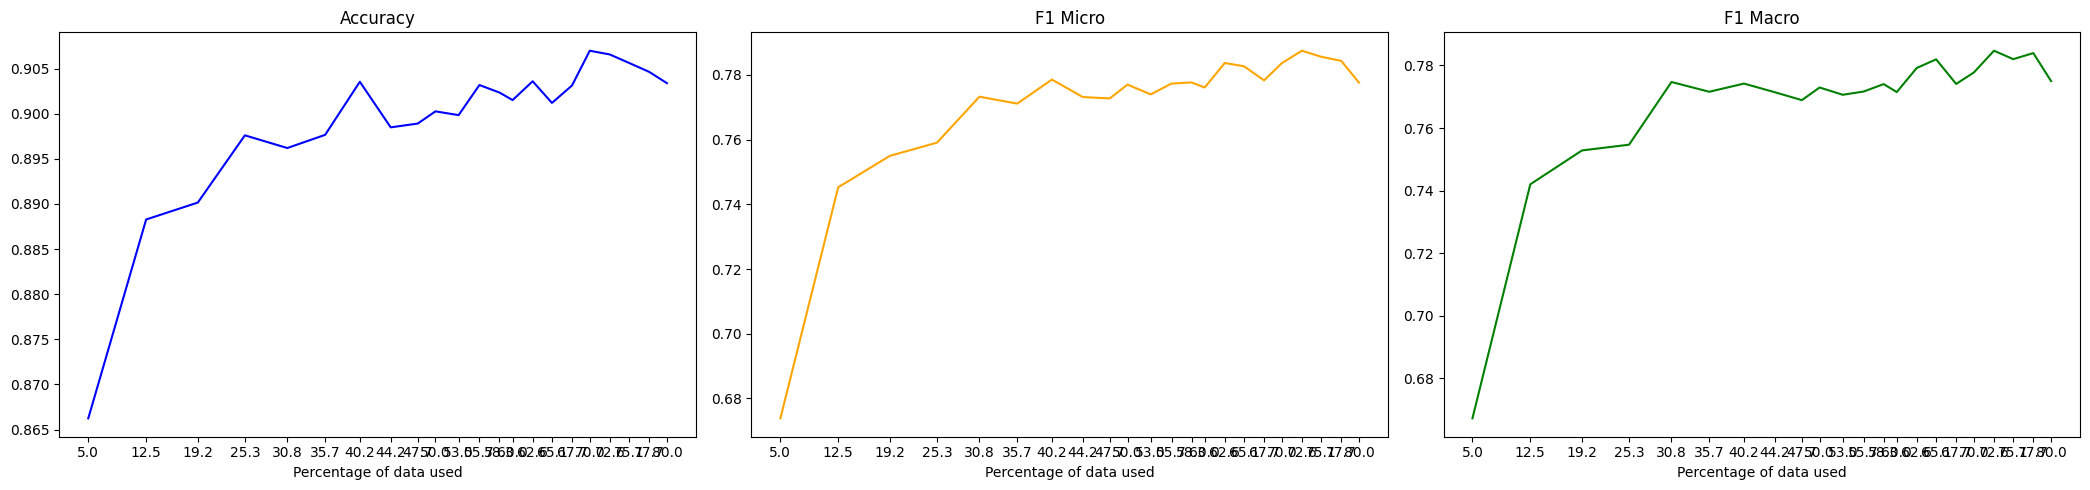

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: [3, 44, 85]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6257, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4449, Accuracy: 0.7873, F1 Micro: 0.0058, F1 Macro: 0.0053
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3901, Accuracy: 0.8056, F1 Micro: 0.1629, F1 Macro: 0.1232
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3715, Accuracy: 0.8298, F1 Micro: 0.3702, F1 Macro: 0.2792
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3107, Accuracy: 0.8478, F1 Micro: 0.5173, F1 Macro: 0.4639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.269, Accuracy: 0.858, F1 Micro: 0.5821, F1 Macro: 0.5628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2396, Accuracy: 0.8644, F1 Micro: 0.6341, F1 Macro: 0.6306
Epoch 8/10, Train Loss: 0.1893, Accuracy: 0.8645, F1 Micro: 0.6199, F1 Macro: 0.6103
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1519, Accuracy: 0.8764, F1 Micro: 0.68

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.641, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4523, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4045, Accuracy: 0.7945, F1 Micro: 0.0707, F1 Macro: 0.0595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3985, Accuracy: 0.8206, F1 Micro: 0.2743, F1 Macro: 0.1959
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3282, Accuracy: 0.8359, F1 Micro: 0.4312, F1 Macro: 0.3544
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.291, Accuracy: 0.8492, F1 Micro: 0.5304, F1 Macro: 0.4884
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2575, Accuracy: 0.8558, F1 Micro: 0.5733, F1 Macro: 0.5516
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2031, Accuracy: 0.8644, F1 Micro: 0.6331, F1 Macro: 0.6244
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1705, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5978, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4434, Accuracy: 0.7872, F1 Micro: 0.0044, F1 Macro: 0.004
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3804, Accuracy: 0.8202, F1 Micro: 0.2738, F1 Macro: 0.1854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3666, Accuracy: 0.8278, F1 Micro: 0.3464, F1 Macro: 0.2469
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3085, Accuracy: 0.8375, F1 Micro: 0.4372, F1 Macro: 0.3739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2698, Accuracy: 0.8508, F1 Micro: 0.538, F1 Macro: 0.5159
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2493, Accuracy: 0.853, F1 Micro: 0.5597, F1 Macro: 0.5411
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1995, Accuracy: 0.8572, F1 Micro: 0.5981, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1665, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5672, Accuracy: 0.7902, F1 Micro: 0.0317, F1 Macro: 0.0281
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4105, Accuracy: 0.8487, F1 Micro: 0.5145, F1 Macro: 0.4529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3408, Accuracy: 0.8694, F1 Micro: 0.64, F1 Macro: 0.629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2571, Accuracy: 0.8766, F1 Micro: 0.6914, F1 Macro: 0.6905
Epoch 5/10, Train Loss: 0.2278, Accuracy: 0.8758, F1 Micro: 0.6512, F1 Macro: 0.6412
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1929, Accuracy: 0.8888, F1 Micro: 0.7103, F1 Macro: 0.703
Epoch 7/10, Train Loss: 0.1444, Accuracy: 0.8836, F1 Micro: 0.6734, F1 Macro: 0.6617
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1187, Accuracy: 0.8872, F1 Micro: 0.7432, F1 Macro: 0.7388
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0968, Accuracy: 0.8895, F1 Micro: 0.746, F1 Macro: 0.7418
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5813, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4324, Accuracy: 0.8286, F1 Micro: 0.3566, F1 Macro: 0.293
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3666, Accuracy: 0.8542, F1 Micro: 0.5499, F1 Macro: 0.5183
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2728, Accuracy: 0.8723, F1 Micro: 0.6725, F1 Macro: 0.6749
Epoch 5/10, Train Loss: 0.2461, Accuracy: 0.8697, F1 Micro: 0.6099, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2051, Accuracy: 0.8814, F1 Micro: 0.7055, F1 Macro: 0.7042
Epoch 7/10, Train Loss: 0.1592, Accuracy: 0.8825, F1 Micro: 0.6775, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1271, Accuracy: 0.8872, F1 Micro: 0.7251, F1 Macro: 0.7175
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1046, Accuracy: 0.8839, F1 Micro: 0.7403, F1 Macro: 0.7354
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5503, Accuracy: 0.7922, F1 Micro: 0.05, F1 Macro: 0.0432
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.413, Accuracy: 0.8311, F1 Micro: 0.3733, F1 Macro: 0.3135
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3541, Accuracy: 0.865, F1 Micro: 0.6094, F1 Macro: 0.5979
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2695, Accuracy: 0.8752, F1 Micro: 0.6785, F1 Macro: 0.678
Epoch 5/10, Train Loss: 0.24, Accuracy: 0.8783, F1 Micro: 0.6591, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2002, Accuracy: 0.8872, F1 Micro: 0.7155, F1 Macro: 0.7113
Epoch 7/10, Train Loss: 0.1617, Accuracy: 0.8839, F1 Micro: 0.6916, F1 Macro: 0.6791
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1226, Accuracy: 0.8841, F1 Micro: 0.7369, F1 Macro: 0.7277
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0984, Accuracy: 0.885, F1 Micro: 0.7421, F1 Macro: 0.7341
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5251, Accuracy: 0.8173, F1 Micro: 0.253, F1 Macro: 0.1741
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3728, Accuracy: 0.8658, F1 Micro: 0.6257, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2855, Accuracy: 0.8741, F1 Micro: 0.6705, F1 Macro: 0.6768
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2358, Accuracy: 0.8884, F1 Micro: 0.7191, F1 Macro: 0.7153
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.185, Accuracy: 0.8913, F1 Micro: 0.7558, F1 Macro: 0.7548
Epoch 6/10, Train Loss: 0.1524, Accuracy: 0.8905, F1 Micro: 0.7338, F1 Macro: 0.7304
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.8934, F1 Micro: 0.7309, F1 Macro: 0.7229
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.8948, F1 Micro: 0.7521, F1 Macro: 0.7477
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.8877, F1 Micro: 0.752, F1 Macro: 0.755
Epoch 10/10, Train Loss: 0.057, Accuracy: 0.8898, F1 Micro: 0.7458, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5377, Accuracy: 0.7998, F1 Micro: 0.1159, F1 Macro: 0.0928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3982, Accuracy: 0.8534, F1 Micro: 0.5571, F1 Macro: 0.5165
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3064, Accuracy: 0.8741, F1 Micro: 0.6599, F1 Macro: 0.6606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2513, Accuracy: 0.8858, F1 Micro: 0.6988, F1 Macro: 0.6933
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2028, Accuracy: 0.8925, F1 Micro: 0.7228, F1 Macro: 0.7154
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1679, Accuracy: 0.8883, F1 Micro: 0.7335, F1 Macro: 0.7311
Epoch 7/10, Train Loss: 0.1265, Accuracy: 0.8939, F1 Micro: 0.7276, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1068, Accuracy: 0.8966, F1 Micro: 0.75, F1 Macro: 0.743
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0.8963, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5073, Accuracy: 0.8239, F1 Micro: 0.3207, F1 Macro: 0.208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3779, Accuracy: 0.8641, F1 Micro: 0.613, F1 Macro: 0.6014
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.292, Accuracy: 0.8703, F1 Micro: 0.6447, F1 Macro: 0.64
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.239, Accuracy: 0.8861, F1 Micro: 0.7104, F1 Macro: 0.7043
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.193, Accuracy: 0.89, F1 Micro: 0.7231, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1603, Accuracy: 0.8875, F1 Micro: 0.7335, F1 Macro: 0.7266
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1207, Accuracy: 0.8927, F1 Micro: 0.7344, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0984, Accuracy: 0.8952, F1 Micro: 0.7345, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0796, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4962, Accuracy: 0.8447, F1 Micro: 0.4866, F1 Macro: 0.4018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3293, Accuracy: 0.8817, F1 Micro: 0.7181, F1 Macro: 0.7186
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2552, Accuracy: 0.8909, F1 Micro: 0.7342, F1 Macro: 0.7325
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2047, Accuracy: 0.893, F1 Micro: 0.742, F1 Macro: 0.7404
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.8955, F1 Micro: 0.7482, F1 Macro: 0.7438
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.8942, F1 Micro: 0.7306, F1 Macro: 0.7128
Epoch 7/10, Train Loss: 0.1065, Accuracy: 0.8955, F1 Micro: 0.729, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0755, Accuracy: 0.897, F1 Micro: 0.7576, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.8958, F1 Micro: 0.7527, F1 Macro: 0.7489
Epoch 10/10, Train Loss: 0.0433, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5197, Accuracy: 0.828, F1 Micro: 0.3443, F1 Macro: 0.2485
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3563, Accuracy: 0.8803, F1 Micro: 0.6958, F1 Macro: 0.689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2756, Accuracy: 0.8925, F1 Micro: 0.7283, F1 Macro: 0.7201
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.221, Accuracy: 0.8928, F1 Micro: 0.7396, F1 Macro: 0.7348
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1711, Accuracy: 0.8961, F1 Micro: 0.7447, F1 Macro: 0.7406
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.8991, F1 Micro: 0.7455, F1 Macro: 0.7313
Epoch 7/10, Train Loss: 0.1118, Accuracy: 0.8963, F1 Micro: 0.7384, F1 Macro: 0.7307
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9003, F1 Micro: 0.7632, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.8995, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4884, Accuracy: 0.8397, F1 Micro: 0.4375, F1 Macro: 0.3813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3356, Accuracy: 0.878, F1 Micro: 0.6922, F1 Macro: 0.6892
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2672, Accuracy: 0.8894, F1 Micro: 0.7336, F1 Macro: 0.728
Epoch 4/10, Train Loss: 0.2129, Accuracy: 0.8867, F1 Micro: 0.7213, F1 Macro: 0.7168
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.8948, F1 Micro: 0.7506, F1 Macro: 0.7454
Epoch 6/10, Train Loss: 0.1334, Accuracy: 0.8938, F1 Micro: 0.7397, F1 Macro: 0.7272
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.8959, F1 Micro: 0.7409, F1 Macro: 0.7337
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.8972, F1 Micro: 0.759, F1 Macro: 0.7546
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.8942, F1 Micro: 0.7462, F1 Macro: 0.7401
Epoch 10/10, Train Loss: 0.0476, Accuracy: 0.8969, F1 Micro: 0.755, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4906, Accuracy: 0.8539, F1 Micro: 0.5503, F1 Macro: 0.5072
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3084, Accuracy: 0.8867, F1 Micro: 0.7314, F1 Macro: 0.7242
Epoch 3/10, Train Loss: 0.245, Accuracy: 0.8895, F1 Micro: 0.7046, F1 Macro: 0.6926
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2056, Accuracy: 0.8961, F1 Micro: 0.7649, F1 Macro: 0.7639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1506, Accuracy: 0.8994, F1 Micro: 0.7685, F1 Macro: 0.7635
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.8956, F1 Micro: 0.7648, F1 Macro: 0.764
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.8958, F1 Micro: 0.7534, F1 Macro: 0.7506
Epoch 8/10, Train Loss: 0.0752, Accuracy: 0.8983, F1 Micro: 0.7606, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.8973, F1 Micro: 0.7634, F1 Macro: 0.7615
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.8989, F1 Micro: 0.7605, F1 Macro: 0.7572
Model 1 - Iteration 2

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5141, Accuracy: 0.8411, F1 Micro: 0.447, F1 Macro: 0.3773
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3317, Accuracy: 0.8788, F1 Micro: 0.7061, F1 Macro: 0.6925
Epoch 3/10, Train Loss: 0.2572, Accuracy: 0.8891, F1 Micro: 0.7044, F1 Macro: 0.6855
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.212, Accuracy: 0.8925, F1 Micro: 0.7613, F1 Macro: 0.758
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.8984, F1 Micro: 0.7475, F1 Macro: 0.7321
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.8994, F1 Micro: 0.7634, F1 Macro: 0.758
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.8998, F1 Micro: 0.76, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9033, F1 Micro: 0.7644, F1 Macro: 0.7594
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.8984, F1 Micro: 0.7542, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0455, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4868, Accuracy: 0.8367, F1 Micro: 0.4274, F1 Macro: 0.3498
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3207, Accuracy: 0.8806, F1 Micro: 0.6994, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2505, Accuracy: 0.8909, F1 Micro: 0.7267, F1 Macro: 0.7095
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2098, Accuracy: 0.8966, F1 Micro: 0.769, F1 Macro: 0.7666
Epoch 5/10, Train Loss: 0.1539, Accuracy: 0.8948, F1 Micro: 0.7403, F1 Macro: 0.7263
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.8989, F1 Micro: 0.7645, F1 Macro: 0.7586
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.8983, F1 Micro: 0.7649, F1 Macro: 0.7628
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.8961, F1 Micro: 0.7358, F1 Macro: 0.7282
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.8972, F1 Micro: 0.7543, F1 Macro: 0.7501
Epoch 10/10, Train Loss: 0.0399, Accuracy: 0.898, F1 Micro: 0.7566, F1 Macro: 0.7526
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4689, Accuracy: 0.8627, F1 Micro: 0.586, F1 Macro: 0.5406
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2999, Accuracy: 0.8889, F1 Micro: 0.7471, F1 Macro: 0.7505
Epoch 3/10, Train Loss: 0.237, Accuracy: 0.8961, F1 Micro: 0.7411, F1 Macro: 0.7322
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.8981, F1 Micro: 0.7554, F1 Macro: 0.7443
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1573, Accuracy: 0.8984, F1 Micro: 0.7571, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.9036, F1 Micro: 0.7646, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9005, F1 Micro: 0.7737, F1 Macro: 0.7714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9027, F1 Micro: 0.7747, F1 Macro: 0.7719
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.8988, F1 Micro: 0.7551, F1 Macro: 0.7498
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4856, Accuracy: 0.8534, F1 Micro: 0.5366, F1 Macro: 0.4686
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3124, Accuracy: 0.8859, F1 Micro: 0.7324, F1 Macro: 0.733
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2462, Accuracy: 0.8983, F1 Micro: 0.7489, F1 Macro: 0.738
Epoch 4/10, Train Loss: 0.1927, Accuracy: 0.8958, F1 Micro: 0.735, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1599, Accuracy: 0.8989, F1 Micro: 0.7535, F1 Macro: 0.7454
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9047, F1 Micro: 0.7746, F1 Macro: 0.7693
Epoch 7/10, Train Loss: 0.0834, Accuracy: 0.9027, F1 Micro: 0.7737, F1 Macro: 0.7676
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9041, F1 Micro: 0.7716, F1 Macro: 0.7696
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9034, F1 Micro: 0.7663, F1 Macro: 0.761
Epoch 10/10, Train Loss: 0.0459, Accuracy: 0.9, F1 Micro: 0.7735, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4651, Accuracy: 0.8537, F1 Micro: 0.5239, F1 Macro: 0.4962
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3059, Accuracy: 0.8872, F1 Micro: 0.732, F1 Macro: 0.7292
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2444, Accuracy: 0.8942, F1 Micro: 0.7403, F1 Macro: 0.7326
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1921, Accuracy: 0.8973, F1 Micro: 0.748, F1 Macro: 0.7332
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1593, Accuracy: 0.8973, F1 Micro: 0.7663, F1 Macro: 0.7614
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9019, F1 Micro: 0.7646, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0892, Accuracy: 0.903, F1 Micro: 0.7765, F1 Macro: 0.7705
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9055, F1 Micro: 0.7753, F1 Macro: 0.7691
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9, F1 Micro: 0.7671, F1 Macro: 0.7647
Epoch 10/10, Train Loss: 0.0416, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.453, Accuracy: 0.8694, F1 Micro: 0.6294, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2898, Accuracy: 0.8933, F1 Micro: 0.7492, F1 Macro: 0.7401
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.8977, F1 Micro: 0.7568, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9016, F1 Micro: 0.7675, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9052, F1 Micro: 0.7724, F1 Macro: 0.7668
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9031, F1 Micro: 0.7652, F1 Macro: 0.7617
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.8997, F1 Micro: 0.7446, F1 Macro: 0.7377
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.905, F1 Micro: 0.777, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9062, F1 Micro: 0.7815, F1 Macro: 0.7808
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4672, Accuracy: 0.8731, F1 Micro: 0.6503, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3017, Accuracy: 0.893, F1 Micro: 0.7488, F1 Macro: 0.7408
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2338, Accuracy: 0.8994, F1 Micro: 0.761, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9038, F1 Micro: 0.7768, F1 Macro: 0.7743
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9038, F1 Micro: 0.7631, F1 Macro: 0.7573
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9044, F1 Micro: 0.7708, F1 Macro: 0.7635
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9008, F1 Micro: 0.7536, F1 Macro: 0.7441
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9045, F1 Micro: 0.7731, F1 Macro: 0.7707
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9033, F1 Micro: 0.771, F1 Macro: 0.7681
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0.9058, F1 Micro: 0.7756, F1 Macro: 0.7724
Model 2 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4492, Accuracy: 0.8692, F1 Micro: 0.6201, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2987, Accuracy: 0.8931, F1 Micro: 0.75, F1 Macro: 0.7426
Epoch 3/10, Train Loss: 0.229, Accuracy: 0.8939, F1 Micro: 0.7409, F1 Macro: 0.7385
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.8983, F1 Micro: 0.763, F1 Macro: 0.7586
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.8995, F1 Micro: 0.7534, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.9023, F1 Micro: 0.766, F1 Macro: 0.7599
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.8975, F1 Micro: 0.7451, F1 Macro: 0.7367
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9017, F1 Micro: 0.7737, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9016, F1 Micro: 0.7711, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0368, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4402, Accuracy: 0.8727, F1 Micro: 0.658, F1 Macro: 0.6421
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.289, Accuracy: 0.8856, F1 Micro: 0.693, F1 Macro: 0.6825
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.229, Accuracy: 0.8952, F1 Micro: 0.7293, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2004, Accuracy: 0.9045, F1 Micro: 0.7726, F1 Macro: 0.7675
Epoch 5/10, Train Loss: 0.1517, Accuracy: 0.9064, F1 Micro: 0.7685, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.9091, F1 Micro: 0.7739, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0892, Accuracy: 0.9039, F1 Micro: 0.7773, F1 Macro: 0.7731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9077, F1 Micro: 0.7823, F1 Macro: 0.7796
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9056, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4593, Accuracy: 0.8673, F1 Micro: 0.6153, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.295, Accuracy: 0.8886, F1 Micro: 0.7023, F1 Macro: 0.6894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2325, Accuracy: 0.8969, F1 Micro: 0.7324, F1 Macro: 0.7187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1981, Accuracy: 0.9041, F1 Micro: 0.7706, F1 Macro: 0.7665
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9062, F1 Micro: 0.7698, F1 Macro: 0.7671
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9036, F1 Micro: 0.7598, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0912, Accuracy: 0.8991, F1 Micro: 0.7757, F1 Macro: 0.7758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9055, F1 Micro: 0.7848, F1 Macro: 0.7849
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9041, F1 Micro: 0.7856, F1 Macro: 0.784
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4402, Accuracy: 0.8714, F1 Micro: 0.6405, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2913, Accuracy: 0.8867, F1 Micro: 0.7015, F1 Macro: 0.6899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2295, Accuracy: 0.8919, F1 Micro: 0.7182, F1 Macro: 0.7013
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1943, Accuracy: 0.9, F1 Micro: 0.7645, F1 Macro: 0.7611
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.8998, F1 Micro: 0.7511, F1 Macro: 0.7459
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9019, F1 Micro: 0.7543, F1 Macro: 0.7456
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.9019, F1 Micro: 0.7839, F1 Macro: 0.782
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9036, F1 Micro: 0.7789, F1 Macro: 0.7766
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9023, F1 Micro: 0.774, F1 Macro: 0.7706
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.9041, F1 Micro: 0.7791, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4362, Accuracy: 0.8781, F1 Micro: 0.6847, F1 Macro: 0.6795
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.282, Accuracy: 0.8922, F1 Micro: 0.7229, F1 Macro: 0.7062
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.231, Accuracy: 0.9022, F1 Micro: 0.7727, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.9036, F1 Micro: 0.7749, F1 Macro: 0.7674
Epoch 5/10, Train Loss: 0.1445, Accuracy: 0.8997, F1 Micro: 0.7538, F1 Macro: 0.7308
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.9062, F1 Micro: 0.7812, F1 Macro: 0.7783
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9052, F1 Micro: 0.7738, F1 Macro: 0.7725
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9061, F1 Micro: 0.7798, F1 Macro: 0.7777
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.903, F1 Micro: 0.7752, F1 Macro: 0.7765
Epoch 10/10, Train Loss: 0.0363, Accuracy: 0.9031, F1 Micro: 0.7805, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4582, Accuracy: 0.8788, F1 Micro: 0.6804, F1 Macro: 0.6747
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2916, Accuracy: 0.8958, F1 Micro: 0.7348, F1 Macro: 0.7203
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2322, Accuracy: 0.9033, F1 Micro: 0.7691, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9045, F1 Micro: 0.7761, F1 Macro: 0.7672
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.9028, F1 Micro: 0.7639, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9039, F1 Micro: 0.7787, F1 Macro: 0.7737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9025, F1 Micro: 0.7811, F1 Macro: 0.7794
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.9055, F1 Micro: 0.787, F1 Macro: 0.7855
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9023, F1 Micro: 0.7765, F1 Macro: 0.7741
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4356, Accuracy: 0.8777, F1 Micro: 0.6869, F1 Macro: 0.6854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2846, Accuracy: 0.8886, F1 Micro: 0.7131, F1 Macro: 0.6895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2296, Accuracy: 0.8994, F1 Micro: 0.7708, F1 Macro: 0.7656
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.8981, F1 Micro: 0.7564, F1 Macro: 0.7402
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9013, F1 Micro: 0.7615, F1 Macro: 0.7472
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9017, F1 Micro: 0.771, F1 Macro: 0.7635
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9034, F1 Micro: 0.7678, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9052, F1 Micro: 0.7847, F1 Macro: 0.7828
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.8988, F1 Micro: 0.7607, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.0389, Accuracy: 0.9038, F1 Micro: 0.7783, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.435, Accuracy: 0.8772, F1 Micro: 0.7121, F1 Macro: 0.7096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2854, Accuracy: 0.898, F1 Micro: 0.7579, F1 Macro: 0.7495
Epoch 3/10, Train Loss: 0.2279, Accuracy: 0.9022, F1 Micro: 0.756, F1 Macro: 0.7437
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9014, F1 Micro: 0.7576, F1 Macro: 0.7483
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.9045, F1 Micro: 0.7781, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.9038, F1 Micro: 0.7895, F1 Macro: 0.7909
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9053, F1 Micro: 0.7782, F1 Macro: 0.7692
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9056, F1 Micro: 0.7804, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9058, F1 Micro: 0.7787, F1 Macro: 0.7758
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9047, F1 Micro: 0.7769, F1 Macro: 0.7734
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.451, Accuracy: 0.8767, F1 Micro: 0.7022, F1 Macro: 0.6938
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2893, Accuracy: 0.8938, F1 Micro: 0.7442, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2291, Accuracy: 0.9009, F1 Micro: 0.752, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1903, Accuracy: 0.9028, F1 Micro: 0.7672, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1471, Accuracy: 0.9069, F1 Micro: 0.7844, F1 Macro: 0.779
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9102, F1 Micro: 0.7828, F1 Macro: 0.7782
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.8998, F1 Micro: 0.7823, F1 Macro: 0.7858
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0626, Accuracy: 0.9073, F1 Micro: 0.793, F1 Macro: 0.7926
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.905, F1 Micro: 0.7884, F1 Macro: 0.7877
Epoch 10/10, Train Loss: 0.0347, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4362, Accuracy: 0.8753, F1 Micro: 0.6919, F1 Macro: 0.678
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2897, Accuracy: 0.8902, F1 Micro: 0.7227, F1 Macro: 0.7098
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2261, Accuracy: 0.9008, F1 Micro: 0.7581, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9008, F1 Micro: 0.7661, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9033, F1 Micro: 0.776, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.9069, F1 Micro: 0.7856, F1 Macro: 0.7826
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9034, F1 Micro: 0.7865, F1 Macro: 0.7833
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9048, F1 Micro: 0.7823, F1 Macro: 0.7824
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9048, F1 Micro: 0.772, F1 Macro: 0.7684
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4249, Accuracy: 0.878, F1 Micro: 0.6865, F1 Macro: 0.6857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2819, Accuracy: 0.8997, F1 Micro: 0.7647, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2262, Accuracy: 0.9039, F1 Micro: 0.7689, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1878, Accuracy: 0.9064, F1 Micro: 0.7837, F1 Macro: 0.7779
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9061, F1 Micro: 0.7819, F1 Macro: 0.7805
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9053, F1 Micro: 0.7803, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9075, F1 Micro: 0.7858, F1 Macro: 0.7814
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9073, F1 Micro: 0.7848, F1 Macro: 0.7794
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9066, F1 Micro: 0.7775, F1 Macro: 0.7766
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0315, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4442, Accuracy: 0.8761, F1 Micro: 0.6757, F1 Macro: 0.6686
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2904, Accuracy: 0.8977, F1 Micro: 0.758, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2299, Accuracy: 0.9062, F1 Micro: 0.7768, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9109, F1 Micro: 0.793, F1 Macro: 0.7846
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9034, F1 Micro: 0.779, F1 Macro: 0.7762
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.9009, F1 Micro: 0.7661, F1 Macro: 0.7537
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9027, F1 Micro: 0.7575, F1 Macro: 0.7415
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9047, F1 Micro: 0.7785, F1 Macro: 0.77
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9064, F1 Micro: 0.7799, F1 Macro: 0.7767
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9066, F1 Micro: 0.784, F1 Macro: 0.7835
Model 2 - Iteration 412

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.425, Accuracy: 0.8745, F1 Micro: 0.6627, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2878, Accuracy: 0.8972, F1 Micro: 0.7519, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2273, Accuracy: 0.9036, F1 Micro: 0.7644, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1859, Accuracy: 0.9052, F1 Micro: 0.7844, F1 Macro: 0.7762
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.903, F1 Micro: 0.7806, F1 Macro: 0.7775
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9028, F1 Micro: 0.7591, F1 Macro: 0.7486
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9058, F1 Micro: 0.7779, F1 Macro: 0.7709
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9048, F1 Micro: 0.7713, F1 Macro: 0.7627
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.905, F1 Micro: 0.7868, F1 Macro: 0.7844
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.8994, F1 Micro: 0.7839, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4172, Accuracy: 0.8773, F1 Micro: 0.6831, F1 Macro: 0.6815
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2802, Accuracy: 0.9006, F1 Micro: 0.7611, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.225, Accuracy: 0.9042, F1 Micro: 0.7818, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.9072, F1 Micro: 0.7872, F1 Macro: 0.7887
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.9033, F1 Micro: 0.7727, F1 Macro: 0.7592
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.9038, F1 Micro: 0.7863, F1 Macro: 0.786
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.907, F1 Micro: 0.7882, F1 Macro: 0.7852
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9053, F1 Micro: 0.7769, F1 Macro: 0.7743
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.9067, F1 Micro: 0.7799, F1 Macro: 0.7767
Epoch 10/10, Train Loss: 0.0371, Accuracy: 0.9056, F1 Micro: 0.7857, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4357, Accuracy: 0.8808, F1 Micro: 0.7071, F1 Macro: 0.7022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2871, Accuracy: 0.9017, F1 Micro: 0.7595, F1 Macro: 0.7461
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2252, Accuracy: 0.9006, F1 Micro: 0.7743, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9077, F1 Micro: 0.7864, F1 Macro: 0.7855
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.905, F1 Micro: 0.7738, F1 Macro: 0.7611
Epoch 6/10, Train Loss: 0.1088, Accuracy: 0.9025, F1 Micro: 0.7815, F1 Macro: 0.7755
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.9022, F1 Micro: 0.781, F1 Macro: 0.7803
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9022, F1 Micro: 0.7807, F1 Macro: 0.7782
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9044, F1 Micro: 0.7725, F1 Macro: 0.7683
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.9041, F1 Micro: 0.778, F1 Macro: 0.7751
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4183, Accuracy: 0.8766, F1 Micro: 0.6969, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2819, Accuracy: 0.8981, F1 Micro: 0.753, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2251, Accuracy: 0.9023, F1 Micro: 0.7812, F1 Macro: 0.7763
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.9042, F1 Micro: 0.772, F1 Macro: 0.769
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.9023, F1 Micro: 0.7809, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.9033, F1 Micro: 0.7829, F1 Macro: 0.7794
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9058, F1 Micro: 0.7739, F1 Macro: 0.7684
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9038, F1 Micro: 0.7795, F1 Macro: 0.775
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.9038, F1 Micro: 0.7681, F1 Macro: 0.7611
Epoch 10/10, Train Loss: 0.0374, Accuracy: 0.9033, F1 Micro: 0.7743, F1 Macro: 0.767
Model 3 - Iteration 433

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.42, Accuracy: 0.8773, F1 Micro: 0.6813, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2678, Accuracy: 0.9005, F1 Micro: 0.7721, F1 Macro: 0.7631
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.9003, F1 Micro: 0.768, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9056, F1 Micro: 0.7755, F1 Macro: 0.7669
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9014, F1 Micro: 0.7591, F1 Macro: 0.7537
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9052, F1 Micro: 0.7641, F1 Macro: 0.7505
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.9027, F1 Micro: 0.7717, F1 Macro: 0.7633
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9023, F1 Micro: 0.7664, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9039, F1 Micro: 0.7768, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0.9034, F1 Micro: 0.7836, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4359, Accuracy: 0.8763, F1 Micro: 0.6937, F1 Macro: 0.6832
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2731, Accuracy: 0.897, F1 Micro: 0.7632, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.9019, F1 Micro: 0.7741, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1829, Accuracy: 0.9066, F1 Micro: 0.7792, F1 Macro: 0.7708
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.9008, F1 Micro: 0.7621, F1 Macro: 0.7609
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9066, F1 Micro: 0.7759, F1 Macro: 0.7646
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9044, F1 Micro: 0.7735, F1 Macro: 0.7667
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9053, F1 Micro: 0.7725, F1 Macro: 0.762
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9044, F1 Micro: 0.7743, F1 Macro: 0.7694
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.9041, F1 Micro: 0.7741, F1 Macro: 0.7658
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4147, Accuracy: 0.8772, F1 Micro: 0.6843, F1 Macro: 0.6622
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2699, Accuracy: 0.8969, F1 Micro: 0.7674, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.8988, F1 Micro: 0.7702, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.9053, F1 Micro: 0.7724, F1 Macro: 0.7604
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9003, F1 Micro: 0.7619, F1 Macro: 0.759
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.8966, F1 Micro: 0.735, F1 Macro: 0.7145
Epoch 7/10, Train Loss: 0.0808, Accuracy: 0.9, F1 Micro: 0.7617, F1 Macro: 0.756
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.903, F1 Micro: 0.7623, F1 Macro: 0.7538
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9039, F1 Micro: 0.7677, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9023, F1 Micro: 0.7808, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4093, Accuracy: 0.8836, F1 Micro: 0.7302, F1 Macro: 0.7235
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.8963, F1 Micro: 0.7564, F1 Macro: 0.7493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2167, Accuracy: 0.9045, F1 Micro: 0.7846, F1 Macro: 0.7838
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.9059, F1 Micro: 0.7806, F1 Macro: 0.7768
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9048, F1 Micro: 0.771, F1 Macro: 0.7646
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9003, F1 Micro: 0.7771, F1 Macro: 0.7734
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9011, F1 Micro: 0.7843, F1 Macro: 0.7855
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9014, F1 Micro: 0.7814, F1 Macro: 0.7822
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9045, F1 Micro: 0.7721, F1 Macro: 0.7686
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.9014, F1 Micro: 0.7796, F1 Macro: 0.7779
Model 1 - Iteration 4663: Accuracy: 0.9045, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4297, Accuracy: 0.8784, F1 Micro: 0.6966, F1 Macro: 0.6811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2782, Accuracy: 0.8986, F1 Micro: 0.7624, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2175, Accuracy: 0.9047, F1 Micro: 0.7764, F1 Macro: 0.7727
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9058, F1 Micro: 0.7715, F1 Macro: 0.7597
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9041, F1 Micro: 0.7692, F1 Macro: 0.758
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.8977, F1 Micro: 0.7694, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.8981, F1 Micro: 0.7796, F1 Macro: 0.78
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9039, F1 Micro: 0.7741, F1 Macro: 0.7729
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.9006, F1 Micro: 0.7737, F1 Macro: 0.7708
Epoch 10/10, Train Loss: 0.0364, Accuracy: 0.905, F1 Micro: 0.7711, F1 Macro: 0.7666
Model 2 - Iteration 466

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4134, Accuracy: 0.8834, F1 Micro: 0.7193, F1 Macro: 0.7141
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2743, Accuracy: 0.8964, F1 Micro: 0.7525, F1 Macro: 0.7408
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2187, Accuracy: 0.9039, F1 Micro: 0.7738, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.903, F1 Micro: 0.7822, F1 Macro: 0.7743
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9047, F1 Micro: 0.7703, F1 Macro: 0.7581
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9014, F1 Micro: 0.777, F1 Macro: 0.7703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9028, F1 Micro: 0.7833, F1 Macro: 0.7791
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9028, F1 Micro: 0.7635, F1 Macro: 0.7595
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9033, F1 Micro: 0.7818, F1 Macro: 0.7801
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9031, F1 Micro: 0.7747, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4028, Accuracy: 0.8825, F1 Micro: 0.713, F1 Macro: 0.7151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2593, Accuracy: 0.8977, F1 Micro: 0.7389, F1 Macro: 0.7316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2177, Accuracy: 0.9044, F1 Micro: 0.7716, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.9011, F1 Micro: 0.773, F1 Macro: 0.7734
Epoch 5/10, Train Loss: 0.1322, Accuracy: 0.9036, F1 Micro: 0.7695, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9064, F1 Micro: 0.7827, F1 Macro: 0.7795
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.9019, F1 Micro: 0.7588, F1 Macro: 0.7485
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.9017, F1 Micro: 0.7738, F1 Macro: 0.7698
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9097, F1 Micro: 0.785, F1 Macro: 0.7792
Epoch 10/10, Train Loss: 0.034, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4238, Accuracy: 0.8777, F1 Micro: 0.695, F1 Macro: 0.6951
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.898, F1 Micro: 0.7347, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2175, Accuracy: 0.9047, F1 Micro: 0.7689, F1 Macro: 0.7611
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9009, F1 Micro: 0.7661, F1 Macro: 0.7622
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9055, F1 Micro: 0.767, F1 Macro: 0.7529
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.9009, F1 Micro: 0.7533, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9056, F1 Micro: 0.775, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.8997, F1 Micro: 0.761, F1 Macro: 0.7549
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.9016, F1 Micro: 0.7608, F1 Macro: 0.7489
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0405, Accuracy: 0.9041, F1 Micro: 0.7779, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.406, Accuracy: 0.8797, F1 Micro: 0.7146, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2636, Accuracy: 0.8998, F1 Micro: 0.752, F1 Macro: 0.7458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.902, F1 Micro: 0.7667, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9031, F1 Micro: 0.7681, F1 Macro: 0.7617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9033, F1 Micro: 0.7809, F1 Macro: 0.775
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9014, F1 Micro: 0.7596, F1 Macro: 0.7516
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9034, F1 Micro: 0.7761, F1 Macro: 0.7706
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.9036, F1 Micro: 0.7687, F1 Macro: 0.7628
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9056, F1 Micro: 0.7796, F1 Macro: 0.7741
Epoch 10/10, Train Loss: 0.0353, Accuracy: 0.9031, F1 Micro: 0.7792, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3942, Accuracy: 0.8891, F1 Micro: 0.7343, F1 Macro: 0.7296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2575, Accuracy: 0.9031, F1 Micro: 0.7727, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.9006, F1 Micro: 0.7792, F1 Macro: 0.776
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9017, F1 Micro: 0.7515, F1 Macro: 0.7416
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9039, F1 Micro: 0.7785, F1 Macro: 0.772
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9047, F1 Micro: 0.7762, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.905, F1 Micro: 0.7844, F1 Macro: 0.7833
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.9058, F1 Micro: 0.7798, F1 Macro: 0.7732
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.902, F1 Micro: 0.7696, F1 Macro: 0.7617
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9056, F1 Micro: 0.781, F1 Macro: 0.7783
Model 1 - Iteration 50

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4169, Accuracy: 0.8811, F1 Micro: 0.6888, F1 Macro: 0.6805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2681, Accuracy: 0.9005, F1 Micro: 0.7684, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2164, Accuracy: 0.9047, F1 Micro: 0.7835, F1 Macro: 0.7788
Epoch 4/10, Train Loss: 0.174, Accuracy: 0.9033, F1 Micro: 0.7552, F1 Macro: 0.751
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.9045, F1 Micro: 0.7823, F1 Macro: 0.7771
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9028, F1 Micro: 0.779, F1 Macro: 0.7753
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9022, F1 Micro: 0.78, F1 Macro: 0.7772
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9027, F1 Micro: 0.7812, F1 Macro: 0.7785
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9031, F1 Micro: 0.7831, F1 Macro: 0.7806
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9008, F1 Micro: 0.7765, F1 Macro: 0.7752
Model 2 - Iteration 5063: Accuracy: 0.9047, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3938, Accuracy: 0.8816, F1 Micro: 0.6865, F1 Macro: 0.6769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.8991, F1 Micro: 0.7616, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2147, Accuracy: 0.9006, F1 Micro: 0.7751, F1 Macro: 0.7714
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.8994, F1 Micro: 0.7424, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9052, F1 Micro: 0.7841, F1 Macro: 0.7761
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9034, F1 Micro: 0.7753, F1 Macro: 0.7674
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9014, F1 Micro: 0.7747, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9055, F1 Micro: 0.7832, F1 Macro: 0.7798
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.902, F1 Micro: 0.766, F1 Macro: 0.7537
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9048, F1 Micro: 0.7653, F1 Macro: 0.7535
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8838, F1 Micro: 0.7107, F1 Macro: 0.6858
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2513, Accuracy: 0.9009, F1 Micro: 0.7775, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2113, Accuracy: 0.9034, F1 Micro: 0.7787, F1 Macro: 0.7659
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9036, F1 Micro: 0.7505, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1335, Accuracy: 0.9058, F1 Micro: 0.7833, F1 Macro: 0.7814
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9052, F1 Micro: 0.7756, F1 Macro: 0.7775
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.8995, F1 Micro: 0.7788, F1 Macro: 0.7778
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9044, F1 Micro: 0.7748, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9072, F1 Micro: 0.7868, F1 Macro: 0.7813
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.032, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4097, Accuracy: 0.8798, F1 Micro: 0.6855, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2544, Accuracy: 0.8992, F1 Micro: 0.7739, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.9055, F1 Micro: 0.784, F1 Macro: 0.7752
Epoch 4/10, Train Loss: 0.1798, Accuracy: 0.9047, F1 Micro: 0.7593, F1 Macro: 0.7471
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.9052, F1 Micro: 0.7797, F1 Macro: 0.7767
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9023, F1 Micro: 0.78, F1 Macro: 0.7816
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9008, F1 Micro: 0.779, F1 Macro: 0.7766
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9033, F1 Micro: 0.783, F1 Macro: 0.7824
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9023, F1 Micro: 0.7748, F1 Macro: 0.7688
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.9027, F1 Micro: 0.7793, F1 Macro: 0.7776
Model 2 - Iteration 5263: Accuracy: 0.9055, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3912, Accuracy: 0.8794, F1 Micro: 0.6917, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.9009, F1 Micro: 0.7729, F1 Macro: 0.7683
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.9014, F1 Micro: 0.7723, F1 Macro: 0.7636
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9013, F1 Micro: 0.7476, F1 Macro: 0.7378
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9027, F1 Micro: 0.7727, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9031, F1 Micro: 0.7771, F1 Macro: 0.7746
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9019, F1 Micro: 0.7744, F1 Macro: 0.7711
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9031, F1 Micro: 0.7749, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9041, F1 Micro: 0.7802, F1 Macro: 0.7754
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.9016, F1 Micro: 0.7775, F1 Macro: 0.7739
Model 3 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3839, Accuracy: 0.8889, F1 Micro: 0.7291, F1 Macro: 0.726
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.8992, F1 Micro: 0.7687, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9033, F1 Micro: 0.7841, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9086, F1 Micro: 0.7844, F1 Macro: 0.7789
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9055, F1 Micro: 0.7831, F1 Macro: 0.7772
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.9028, F1 Micro: 0.7763, F1 Macro: 0.7732
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9048, F1 Micro: 0.7786, F1 Macro: 0.7735
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9069, F1 Micro: 0.7831, F1 Macro: 0.7793
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9005, F1 Micro: 0.7726, F1 Macro: 0.7674
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.8995, F1 Micro: 0.7825, F1 Macro: 0.7845
Model 1 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4017, Accuracy: 0.882, F1 Micro: 0.6972, F1 Macro: 0.6807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2598, Accuracy: 0.8986, F1 Micro: 0.775, F1 Macro: 0.7747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.9027, F1 Micro: 0.7807, F1 Macro: 0.7754
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.9062, F1 Micro: 0.782, F1 Macro: 0.7774
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.903, F1 Micro: 0.778, F1 Macro: 0.7715
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.903, F1 Micro: 0.78, F1 Macro: 0.7753
Epoch 7/10, Train Loss: 0.0691, Accuracy: 0.9033, F1 Micro: 0.7688, F1 Macro: 0.7622
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9019, F1 Micro: 0.7669, F1 Macro: 0.7633
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9, F1 Micro: 0.7726, F1 Macro: 0.7655
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.8997, F1 Micro: 0.7701, F1 Macro: 0.7661
Model 2 - Iteration 5441: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3846, Accuracy: 0.8863, F1 Micro: 0.7086, F1 Macro: 0.6948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2565, Accuracy: 0.9017, F1 Micro: 0.7746, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.9017, F1 Micro: 0.7775, F1 Macro: 0.7716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9066, F1 Micro: 0.7806, F1 Macro: 0.7748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9055, F1 Micro: 0.7869, F1 Macro: 0.7806
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9033, F1 Micro: 0.7732, F1 Macro: 0.7667
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.898, F1 Micro: 0.7752, F1 Macro: 0.7714
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9031, F1 Micro: 0.7692, F1 Macro: 0.7636
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.8992, F1 Micro: 0.7769, F1 Macro: 0.7712
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.8988, F1 Micro: 0.7725, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3799, Accuracy: 0.885, F1 Micro: 0.7147, F1 Macro: 0.7106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.9017, F1 Micro: 0.7654, F1 Macro: 0.7502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.9038, F1 Micro: 0.775, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9069, F1 Micro: 0.785, F1 Macro: 0.7837
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9062, F1 Micro: 0.7845, F1 Macro: 0.7835
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.9042, F1 Micro: 0.7773, F1 Macro: 0.7771
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.8997, F1 Micro: 0.7819, F1 Macro: 0.7841
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9025, F1 Micro: 0.777, F1 Macro: 0.774
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9019, F1 Micro: 0.7698, F1 Macro: 0.7677
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9048, F1 Micro: 0.7799, F1 Macro: 0.7784
Model 1 - Iteration 564

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3945, Accuracy: 0.8867, F1 Micro: 0.7246, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2574, Accuracy: 0.8998, F1 Micro: 0.7473, F1 Macro: 0.7284
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9045, F1 Micro: 0.7858, F1 Macro: 0.7789
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9045, F1 Micro: 0.7828, F1 Macro: 0.7793
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.903, F1 Micro: 0.7723, F1 Macro: 0.7649
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9058, F1 Micro: 0.7816, F1 Macro: 0.7749
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9028, F1 Micro: 0.7741, F1 Macro: 0.775
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9028, F1 Micro: 0.7712, F1 Macro: 0.7622
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9044, F1 Micro: 0.7808, F1 Macro: 0.7764
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9031, F1 Micro: 0.7716, F1 Macro: 0.7683
Model 2 - Iteration 5641: Accuracy: 0.9045, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3804, Accuracy: 0.8878, F1 Micro: 0.7274, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.8978, F1 Micro: 0.7517, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1987, Accuracy: 0.9047, F1 Micro: 0.7838, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.9061, F1 Micro: 0.7844, F1 Macro: 0.7778
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9013, F1 Micro: 0.7652, F1 Macro: 0.7501
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9052, F1 Micro: 0.7805, F1 Macro: 0.7759
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9013, F1 Micro: 0.7715, F1 Macro: 0.7708
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9009, F1 Micro: 0.7706, F1 Macro: 0.7618
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9042, F1 Micro: 0.7727, F1 Macro: 0.7638
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9025, F1 Micro: 0.7654, F1 Macro: 0.7591
Model 3 - Iterati

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3705, Accuracy: 0.8855, F1 Micro: 0.7022, F1 Macro: 0.6819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2437, Accuracy: 0.8939, F1 Micro: 0.7751, F1 Macro: 0.7758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9036, F1 Micro: 0.7773, F1 Macro: 0.7695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9086, F1 Micro: 0.778, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.8991, F1 Micro: 0.7826, F1 Macro: 0.7834
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.9062, F1 Micro: 0.7771, F1 Macro: 0.7681
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9055, F1 Micro: 0.7812, F1 Macro: 0.7771
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9072, F1 Micro: 0.779, F1 Macro: 0.7728
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.9005, F1 Micro: 0.7766, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.0293, Accuracy: 0.9039, F1 Micro: 0.7773, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3882, Accuracy: 0.8809, F1 Micro: 0.6809, F1 Macro: 0.659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.8902, F1 Micro: 0.7721, F1 Macro: 0.7746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.9023, F1 Micro: 0.7748, F1 Macro: 0.7642
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9064, F1 Micro: 0.7739, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.905, F1 Micro: 0.7799, F1 Macro: 0.7718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.9022, F1 Micro: 0.7819, F1 Macro: 0.7787
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9053, F1 Micro: 0.766, F1 Macro: 0.7592
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9039, F1 Micro: 0.7726, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9028, F1 Micro: 0.7755, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0324, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3734, Accuracy: 0.8784, F1 Micro: 0.6706, F1 Macro: 0.6453
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.8939, F1 Micro: 0.7761, F1 Macro: 0.7749
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.9011, F1 Micro: 0.7759, F1 Macro: 0.7666
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9039, F1 Micro: 0.7587, F1 Macro: 0.7405
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9033, F1 Micro: 0.7817, F1 Macro: 0.7764
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.898, F1 Micro: 0.769, F1 Macro: 0.7646
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.9041, F1 Micro: 0.7761, F1 Macro: 0.7704
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.9041, F1 Micro: 0.7733, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9025, F1 Micro: 0.7793, F1 Macro: 0.7768
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9034, F1 Micro: 0.778, F1 Macro: 0.7717
Model 3 - Iteration 5841: Accuracy: 0.9033, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.371, Accuracy: 0.8869, F1 Micro: 0.7542, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2463, Accuracy: 0.9008, F1 Micro: 0.7707, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.9027, F1 Micro: 0.779, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.9055, F1 Micro: 0.7869, F1 Macro: 0.7845
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9069, F1 Micro: 0.7794, F1 Macro: 0.7751
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.9008, F1 Micro: 0.7788, F1 Macro: 0.7777
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9036, F1 Micro: 0.7765, F1 Macro: 0.7743
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9036, F1 Micro: 0.777, F1 Macro: 0.7722
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9011, F1 Micro: 0.7618, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9062, F1 Micro: 0.782, F1 Macro: 0.7774
Model 1 - Iteration 6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3862, Accuracy: 0.8827, F1 Micro: 0.7507, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2516, Accuracy: 0.9005, F1 Micro: 0.7708, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2062, Accuracy: 0.9, F1 Micro: 0.7743, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9048, F1 Micro: 0.7856, F1 Macro: 0.783
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.8998, F1 Micro: 0.7578, F1 Macro: 0.7482
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9, F1 Micro: 0.7732, F1 Macro: 0.7712
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9033, F1 Micro: 0.7769, F1 Macro: 0.7719
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9016, F1 Micro: 0.7785, F1 Macro: 0.7755
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9023, F1 Micro: 0.7703, F1 Macro: 0.7641
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9002, F1 Micro: 0.7707, F1 Macro: 0.7669
Model 2 - Iteration 6041: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3717, Accuracy: 0.8848, F1 Micro: 0.7444, F1 Macro: 0.7389
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2461, Accuracy: 0.9023, F1 Micro: 0.7733, F1 Macro: 0.7656
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.8981, F1 Micro: 0.7738, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9045, F1 Micro: 0.7828, F1 Macro: 0.7765
Epoch 5/10, Train Loss: 0.1164, Accuracy: 0.9009, F1 Micro: 0.7562, F1 Macro: 0.7459
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9016, F1 Micro: 0.7786, F1 Macro: 0.7738
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9003, F1 Micro: 0.7596, F1 Macro: 0.751
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9006, F1 Micro: 0.7689, F1 Macro: 0.7637
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.8994, F1 Micro: 0.7457, F1 Macro: 0.7362
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.903, F1 Micro: 0.7706, F1 Macro: 0.7631
Model 3 - Iteration 60

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3624, Accuracy: 0.8856, F1 Micro: 0.6911, F1 Macro: 0.6672
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2317, Accuracy: 0.8991, F1 Micro: 0.7654, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9059, F1 Micro: 0.767, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9067, F1 Micro: 0.7906, F1 Macro: 0.7877
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9005, F1 Micro: 0.7804, F1 Macro: 0.7782
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9011, F1 Micro: 0.7781, F1 Macro: 0.7763
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.8989, F1 Micro: 0.7765, F1 Macro: 0.7723
Epoch 8/10, Train Loss: 0.043, Accuracy: 0.9058, F1 Micro: 0.7734, F1 Macro: 0.7707
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9058, F1 Micro: 0.7808, F1 Macro: 0.7782
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9, F1 Micro: 0.7848, F1 Macro: 0.7872
Model 1 - Iteration 6218

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8859, F1 Micro: 0.7054, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2368, Accuracy: 0.8986, F1 Micro: 0.7661, F1 Macro: 0.755
Epoch 3/10, Train Loss: 0.1893, Accuracy: 0.8998, F1 Micro: 0.7558, F1 Macro: 0.7514
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.9053, F1 Micro: 0.789, F1 Macro: 0.7871
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9052, F1 Micro: 0.7827, F1 Macro: 0.7797
Epoch 6/10, Train Loss: 0.083, Accuracy: 0.9003, F1 Micro: 0.7809, F1 Macro: 0.7767
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9052, F1 Micro: 0.7784, F1 Macro: 0.7709
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.9011, F1 Micro: 0.757, F1 Macro: 0.748
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9036, F1 Micro: 0.7785, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9033, F1 Micro: 0.771, F1 Macro: 0.7655
Model 2 - Iteration 6218: Accuracy: 0.9053, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3648, Accuracy: 0.8848, F1 Micro: 0.6902, F1 Macro: 0.6703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2335, Accuracy: 0.8963, F1 Micro: 0.7612, F1 Macro: 0.7519
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.9005, F1 Micro: 0.7588, F1 Macro: 0.7514
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9031, F1 Micro: 0.7825, F1 Macro: 0.7785
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.8966, F1 Micro: 0.7771, F1 Macro: 0.7755
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.8991, F1 Micro: 0.7798, F1 Macro: 0.7758
Epoch 7/10, Train Loss: 0.0609, Accuracy: 0.8992, F1 Micro: 0.7758, F1 Macro: 0.775
Epoch 8/10, Train Loss: 0.0449, Accuracy: 0.9034, F1 Micro: 0.7753, F1 Macro: 0.7704
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9023, F1 Micro: 0.7761, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.902, F1 Micro: 0.7836, F1 Macro: 0.7833
Model 3 - Iteration

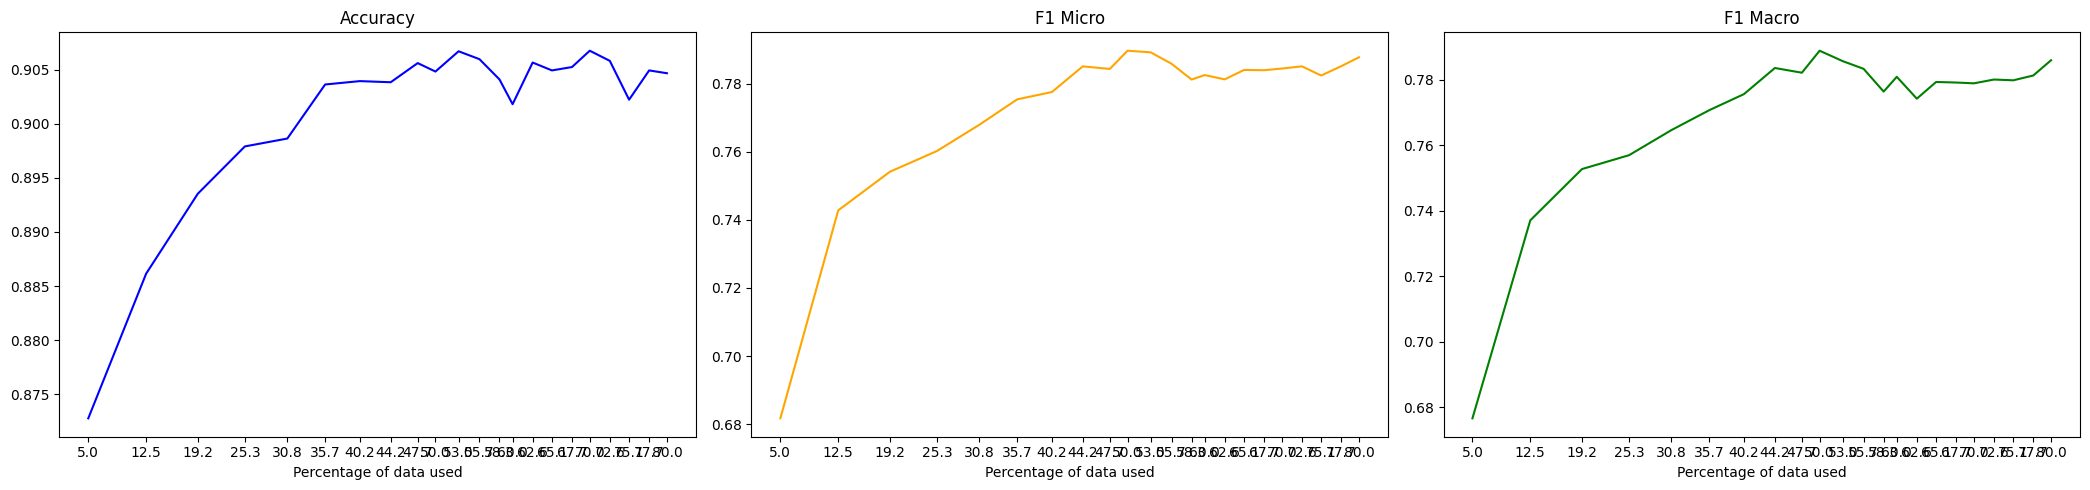

In [21]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: [94, 21, 5]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5641, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4377, Accuracy: 0.7956, F1 Micro: 0.0802, F1 Macro: 0.0667
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4131, Accuracy: 0.8189, F1 Micro: 0.2669, F1 Macro: 0.1815
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3655, Accuracy: 0.8245, F1 Micro: 0.349, F1 Macro: 0.2293
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3001, Accuracy: 0.8288, F1 Micro: 0.3583, F1 Macro: 0.2455
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2612, Accuracy: 0.832, F1 Micro: 0.4248, F1 Macro: 0.3435
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2389, Accuracy: 0.8489, F1 Micro: 0.5335, F1 Macro: 0.4777
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2128, Accuracy: 0.8502, F1 Micro: 0.5663, F1 Macro: 0.5281
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1624,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5756, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4529, Accuracy: 0.788, F1 Micro: 0.0117, F1 Macro: 0.0106
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4383, Accuracy: 0.8164, F1 Micro: 0.2463, F1 Macro: 0.1702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3845, Accuracy: 0.825, F1 Micro: 0.3204, F1 Macro: 0.2136
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3182, Accuracy: 0.8286, F1 Micro: 0.367, F1 Macro: 0.2456
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2785, Accuracy: 0.8316, F1 Micro: 0.4254, F1 Macro: 0.3292
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2513, Accuracy: 0.8447, F1 Micro: 0.5146, F1 Macro: 0.4523
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2208, Accuracy: 0.8473, F1 Micro: 0.5296, F1 Macro: 0.4806
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1736, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5409, Accuracy: 0.7866, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4369, Accuracy: 0.7987, F1 Micro: 0.1105, F1 Macro: 0.0891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4044, Accuracy: 0.8228, F1 Micro: 0.3068, F1 Macro: 0.2064
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3623, Accuracy: 0.8263, F1 Micro: 0.3703, F1 Macro: 0.2476
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3034, Accuracy: 0.835, F1 Micro: 0.4286, F1 Macro: 0.3134
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2554, Accuracy: 0.8439, F1 Micro: 0.5134, F1 Macro: 0.4238
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2287, Accuracy: 0.8491, F1 Micro: 0.5569, F1 Macro: 0.5164
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1992, Accuracy: 0.8516, F1 Micro: 0.5697, F1 Macro: 0.536
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1582,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5383, Accuracy: 0.7873, F1 Micro: 0.0058, F1 Macro: 0.0053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4089, Accuracy: 0.8317, F1 Micro: 0.3891, F1 Macro: 0.2919
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3482, Accuracy: 0.8597, F1 Micro: 0.5951, F1 Macro: 0.5841
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2841, Accuracy: 0.8723, F1 Micro: 0.6837, F1 Macro: 0.6787
Epoch 5/10, Train Loss: 0.2346, Accuracy: 0.8759, F1 Micro: 0.678, F1 Macro: 0.6574
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1859, Accuracy: 0.8767, F1 Micro: 0.7183, F1 Macro: 0.7123
Epoch 7/10, Train Loss: 0.1522, Accuracy: 0.8792, F1 Micro: 0.7136, F1 Macro: 0.7054
Epoch 8/10, Train Loss: 0.1193, Accuracy: 0.8792, F1 Micro: 0.7176, F1 Macro: 0.706
Epoch 9/10, Train Loss: 0.0851, Accuracy: 0.8809, F1 Micro: 0.7062, F1 Macro: 0.6991
Epoch 10/10, Train Loss: 0.0793, Accuracy: 0.8797, F1 Micro: 0.6823, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5482, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4295, Accuracy: 0.8313, F1 Micro: 0.3677, F1 Macro: 0.2842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3602, Accuracy: 0.8559, F1 Micro: 0.5778, F1 Macro: 0.5697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2889, Accuracy: 0.873, F1 Micro: 0.6795, F1 Macro: 0.6777
Epoch 5/10, Train Loss: 0.2402, Accuracy: 0.8773, F1 Micro: 0.6755, F1 Macro: 0.6669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1874, Accuracy: 0.8828, F1 Micro: 0.7239, F1 Macro: 0.7236
Epoch 7/10, Train Loss: 0.1475, Accuracy: 0.8848, F1 Micro: 0.7184, F1 Macro: 0.7124
Epoch 8/10, Train Loss: 0.119, Accuracy: 0.8823, F1 Micro: 0.7085, F1 Macro: 0.6868
Epoch 9/10, Train Loss: 0.0897, Accuracy: 0.8861, F1 Micro: 0.7235, F1 Macro: 0.7099
Epoch 10/10, Train Loss: 0.0771, Accuracy: 0.883, F1 Micro: 0.7223, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5202, Accuracy: 0.7973, F1 Micro: 0.0974, F1 Macro: 0.0796
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4022, Accuracy: 0.8367, F1 Micro: 0.4318, F1 Macro: 0.3415
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3421, Accuracy: 0.863, F1 Micro: 0.6118, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2778, Accuracy: 0.8733, F1 Micro: 0.6932, F1 Macro: 0.6857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2342, Accuracy: 0.8814, F1 Micro: 0.696, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1719, Accuracy: 0.8825, F1 Micro: 0.7243, F1 Macro: 0.7183
Epoch 7/10, Train Loss: 0.1386, Accuracy: 0.8842, F1 Micro: 0.7232, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.112, Accuracy: 0.8808, F1 Micro: 0.7314, F1 Macro: 0.7243
Epoch 9/10, Train Loss: 0.0872, Accuracy: 0.8809, F1 Micro: 0.7309, F1 Macro: 0.7259
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4899, Accuracy: 0.8234, F1 Micro: 0.3225, F1 Macro: 0.2064
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3727, Accuracy: 0.8572, F1 Micro: 0.5572, F1 Macro: 0.5089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3022, Accuracy: 0.8809, F1 Micro: 0.7125, F1 Macro: 0.7062
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2374, Accuracy: 0.8864, F1 Micro: 0.7432, F1 Macro: 0.7413
Epoch 5/10, Train Loss: 0.1938, Accuracy: 0.8891, F1 Micro: 0.7343, F1 Macro: 0.7264
Epoch 6/10, Train Loss: 0.1516, Accuracy: 0.8905, F1 Micro: 0.7199, F1 Macro: 0.7107
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.8869, F1 Micro: 0.7255, F1 Macro: 0.7121
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.8884, F1 Micro: 0.7379, F1 Macro: 0.7309
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.888, F1 Micro: 0.7373, F1 Macro: 0.7324
Epoch 10/10, Train Loss: 0.0606, Accuracy: 0.888, F1 Micro: 0.7384, F1 Macro: 0.735
Model 1 - Iteration 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5033, Accuracy: 0.8175, F1 Micro: 0.2542, F1 Macro: 0.1743
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3782, Accuracy: 0.8616, F1 Micro: 0.5875, F1 Macro: 0.5696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3025, Accuracy: 0.8777, F1 Micro: 0.7092, F1 Macro: 0.7094
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2305, Accuracy: 0.8888, F1 Micro: 0.7441, F1 Macro: 0.7404
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1901, Accuracy: 0.8913, F1 Micro: 0.7445, F1 Macro: 0.7331
Epoch 6/10, Train Loss: 0.1476, Accuracy: 0.8919, F1 Micro: 0.7278, F1 Macro: 0.7158
Epoch 7/10, Train Loss: 0.1196, Accuracy: 0.8855, F1 Micro: 0.7175, F1 Macro: 0.6961
Epoch 8/10, Train Loss: 0.0876, Accuracy: 0.8884, F1 Micro: 0.7202, F1 Macro: 0.7065
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.8898, F1 Micro: 0.7382, F1 Macro: 0.7309
Epoch 10/10, Train Loss: 0.0546, Accuracy: 0.8909, F1 Micro: 0.7374, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4803, Accuracy: 0.8267, F1 Micro: 0.3434, F1 Macro: 0.2221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3683, Accuracy: 0.8586, F1 Micro: 0.5659, F1 Macro: 0.5258
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2986, Accuracy: 0.8839, F1 Micro: 0.7218, F1 Macro: 0.7117
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2301, Accuracy: 0.8908, F1 Micro: 0.7515, F1 Macro: 0.7469
Epoch 5/10, Train Loss: 0.181, Accuracy: 0.892, F1 Micro: 0.747, F1 Macro: 0.7388
Epoch 6/10, Train Loss: 0.1422, Accuracy: 0.8925, F1 Micro: 0.7315, F1 Macro: 0.7217
Epoch 7/10, Train Loss: 0.1193, Accuracy: 0.8895, F1 Micro: 0.7347, F1 Macro: 0.7237
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.8909, F1 Micro: 0.7428, F1 Macro: 0.7373
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.8878, F1 Micro: 0.745, F1 Macro: 0.7433
Epoch 10/10, Train Loss: 0.0583, Accuracy: 0.89, F1 Micro: 0.7231, F1 Macro: 0.7132
Model 3 - Iteration 149

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4682, Accuracy: 0.8388, F1 Micro: 0.4809, F1 Macro: 0.4074
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.342, Accuracy: 0.8708, F1 Micro: 0.6573, F1 Macro: 0.6586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2856, Accuracy: 0.8855, F1 Micro: 0.7072, F1 Macro: 0.7029
Epoch 4/10, Train Loss: 0.2228, Accuracy: 0.8867, F1 Micro: 0.6973, F1 Macro: 0.6795
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1939, Accuracy: 0.8942, F1 Micro: 0.7308, F1 Macro: 0.7175
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1403, Accuracy: 0.8858, F1 Micro: 0.7473, F1 Macro: 0.7433
Epoch 7/10, Train Loss: 0.1163, Accuracy: 0.8903, F1 Micro: 0.7434, F1 Macro: 0.7308
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.8922, F1 Micro: 0.7408, F1 Macro: 0.7322
Epoch 9/10, Train Loss: 0.0612, Accuracy: 0.8873, F1 Micro: 0.7303, F1 Macro: 0.7207
Epoch 10/10, Train Loss: 0.0511, Accuracy: 0.8897, F1 Micro: 0.7393, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4852, Accuracy: 0.8383, F1 Micro: 0.4329, F1 Macro: 0.3497
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3451, Accuracy: 0.8709, F1 Micro: 0.6781, F1 Macro: 0.6779
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2839, Accuracy: 0.8839, F1 Micro: 0.6858, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2196, Accuracy: 0.888, F1 Micro: 0.6984, F1 Macro: 0.6846
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1914, Accuracy: 0.8928, F1 Micro: 0.7252, F1 Macro: 0.7146
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1402, Accuracy: 0.8902, F1 Micro: 0.7446, F1 Macro: 0.7363
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.8913, F1 Micro: 0.7445, F1 Macro: 0.7329
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.8906, F1 Micro: 0.7251, F1 Macro: 0.7174
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.8939, F1 Micro: 0.7425, F1 Macro: 0.7341
Epoch 10/10, Train Loss: 0.0485, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4572, Accuracy: 0.8405, F1 Micro: 0.4988, F1 Macro: 0.425
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3373, Accuracy: 0.8825, F1 Micro: 0.7152, F1 Macro: 0.7065
Epoch 3/10, Train Loss: 0.2809, Accuracy: 0.8861, F1 Micro: 0.6971, F1 Macro: 0.6862
Epoch 4/10, Train Loss: 0.2157, Accuracy: 0.8886, F1 Micro: 0.6988, F1 Macro: 0.684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1841, Accuracy: 0.8947, F1 Micro: 0.7346, F1 Macro: 0.7269
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1342, Accuracy: 0.8916, F1 Micro: 0.7496, F1 Macro: 0.7435
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.8958, F1 Micro: 0.7527, F1 Macro: 0.7424
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.8919, F1 Micro: 0.7445, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0612, Accuracy: 0.892, F1 Micro: 0.7535, F1 Macro: 0.7501
Epoch 10/10, Train Loss: 0.0492, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4629, Accuracy: 0.8391, F1 Micro: 0.4365, F1 Macro: 0.3572
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3138, Accuracy: 0.8791, F1 Micro: 0.7263, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2616, Accuracy: 0.8888, F1 Micro: 0.7504, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2161, Accuracy: 0.8945, F1 Micro: 0.7604, F1 Macro: 0.7582
Epoch 5/10, Train Loss: 0.1674, Accuracy: 0.8944, F1 Micro: 0.7451, F1 Macro: 0.735
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.8895, F1 Micro: 0.7392, F1 Macro: 0.7261
Epoch 7/10, Train Loss: 0.0936, Accuracy: 0.8928, F1 Micro: 0.7457, F1 Macro: 0.7356
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.8908, F1 Micro: 0.7548, F1 Macro: 0.7518
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.8916, F1 Micro: 0.7516, F1 Macro: 0.7475
Epoch 10/10, Train Loss: 0.0409, Accuracy: 0.8941, F1 Micro: 0.7507, F1 Macro: 0.7478
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4787, Accuracy: 0.8486, F1 Micro: 0.5018, F1 Macro: 0.44
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3152, Accuracy: 0.8748, F1 Micro: 0.6771, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2603, Accuracy: 0.8883, F1 Micro: 0.76, F1 Macro: 0.7598
Epoch 4/10, Train Loss: 0.2107, Accuracy: 0.8953, F1 Micro: 0.7576, F1 Macro: 0.7572
Epoch 5/10, Train Loss: 0.1683, Accuracy: 0.898, F1 Micro: 0.7507, F1 Macro: 0.7436
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.8927, F1 Micro: 0.7514, F1 Macro: 0.7391
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.8964, F1 Micro: 0.754, F1 Macro: 0.7458
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.898, F1 Micro: 0.7577, F1 Macro: 0.7526
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.8938, F1 Micro: 0.7432, F1 Macro: 0.7331
Epoch 10/10, Train Loss: 0.0425, Accuracy: 0.8988, F1 Micro: 0.7549, F1 Macro: 0.7485
Model 2 - Iteration 2394: Accuracy: 0.8883, F1 Micro: 0.76

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4559, Accuracy: 0.8406, F1 Micro: 0.4457, F1 Macro: 0.3594
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3097, Accuracy: 0.8828, F1 Micro: 0.7368, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2564, Accuracy: 0.89, F1 Micro: 0.7587, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2116, Accuracy: 0.8959, F1 Micro: 0.759, F1 Macro: 0.7564
Epoch 5/10, Train Loss: 0.1583, Accuracy: 0.8938, F1 Micro: 0.7485, F1 Macro: 0.7397
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.8947, F1 Micro: 0.7586, F1 Macro: 0.7538
Epoch 7/10, Train Loss: 0.0936, Accuracy: 0.8923, F1 Micro: 0.7455, F1 Macro: 0.7386
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.8892, F1 Micro: 0.7596, F1 Macro: 0.7619
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.8908, F1 Micro: 0.7371, F1 Macro: 0.7304
Epoch 10/10, Train Loss: 0.0383, Accuracy: 0.8922, F1 Micro: 0.738, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.455, Accuracy: 0.845, F1 Micro: 0.4855, F1 Macro: 0.4156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3112, Accuracy: 0.8867, F1 Micro: 0.7326, F1 Macro: 0.7326
Epoch 3/10, Train Loss: 0.2475, Accuracy: 0.8903, F1 Micro: 0.721, F1 Macro: 0.7097
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2059, Accuracy: 0.8952, F1 Micro: 0.7482, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1609, Accuracy: 0.9008, F1 Micro: 0.7705, F1 Macro: 0.7652
Epoch 6/10, Train Loss: 0.1206, Accuracy: 0.8919, F1 Micro: 0.7155, F1 Macro: 0.6955
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.8989, F1 Micro: 0.7612, F1 Macro: 0.7507
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9022, F1 Micro: 0.7759, F1 Macro: 0.7722
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.8978, F1 Micro: 0.7634, F1 Macro: 0.7591
Epoch 10/10, Train Loss: 0.0398, Accuracy: 0.8945, F1 Micro: 0.7492, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.469, Accuracy: 0.8512, F1 Micro: 0.524, F1 Macro: 0.4632
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3042, Accuracy: 0.8898, F1 Micro: 0.7409, F1 Macro: 0.7428
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2413, Accuracy: 0.8978, F1 Micro: 0.7534, F1 Macro: 0.7491
Epoch 4/10, Train Loss: 0.1971, Accuracy: 0.8923, F1 Micro: 0.7409, F1 Macro: 0.7313
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.8977, F1 Micro: 0.767, F1 Macro: 0.7655
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.8956, F1 Micro: 0.7291, F1 Macro: 0.7078
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.8986, F1 Micro: 0.759, F1 Macro: 0.7532
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.8964, F1 Micro: 0.7572, F1 Macro: 0.7518
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.8941, F1 Micro: 0.7654, F1 Macro: 0.7658
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.8964, F1 Micro: 0.7544, F1 Macro: 0.747
Model 2 - Iteration 27

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4466, Accuracy: 0.8559, F1 Micro: 0.555, F1 Macro: 0.4939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3041, Accuracy: 0.882, F1 Micro: 0.7209, F1 Macro: 0.7255
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2398, Accuracy: 0.8975, F1 Micro: 0.7473, F1 Macro: 0.737
Epoch 4/10, Train Loss: 0.1995, Accuracy: 0.8914, F1 Micro: 0.7372, F1 Macro: 0.7276
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1548, Accuracy: 0.8969, F1 Micro: 0.7643, F1 Macro: 0.7648
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.8969, F1 Micro: 0.7349, F1 Macro: 0.722
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.8956, F1 Micro: 0.7491, F1 Macro: 0.7408
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.8947, F1 Micro: 0.7572, F1 Macro: 0.7547
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.8972, F1 Micro: 0.7683, F1 Macro: 0.7677
Epoch 10/10, Train Loss: 0.0398, Accuracy: 0.8975, F1 Micro: 0.7592, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4319, Accuracy: 0.8605, F1 Micro: 0.579, F1 Macro: 0.5423
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2998, Accuracy: 0.8773, F1 Micro: 0.6519, F1 Macro: 0.6417
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2425, Accuracy: 0.8936, F1 Micro: 0.7526, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2, Accuracy: 0.8984, F1 Micro: 0.7652, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.8973, F1 Micro: 0.7681, F1 Macro: 0.763
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.8927, F1 Micro: 0.7334, F1 Macro: 0.7175
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.8956, F1 Micro: 0.7654, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.897, F1 Micro: 0.7599, F1 Macro: 0.7568
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.8977, F1 Micro: 0.7651, F1 Macro: 0.7623
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.8983, F1 Micro: 0.7616, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.45, Accuracy: 0.8581, F1 Micro: 0.5693, F1 Macro: 0.5461
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3005, Accuracy: 0.8833, F1 Micro: 0.6696, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2398, Accuracy: 0.8928, F1 Micro: 0.7472, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.203, Accuracy: 0.9006, F1 Micro: 0.7627, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.8994, F1 Micro: 0.7744, F1 Macro: 0.7688
Epoch 6/10, Train Loss: 0.1092, Accuracy: 0.8978, F1 Micro: 0.7567, F1 Macro: 0.7493
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.8964, F1 Micro: 0.7655, F1 Macro: 0.7619
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9033, F1 Micro: 0.7712, F1 Macro: 0.7674
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9014, F1 Micro: 0.772, F1 Macro: 0.7686
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.9006, F1 Micro: 0.7704, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.424, Accuracy: 0.8669, F1 Micro: 0.6223, F1 Macro: 0.6006
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2936, Accuracy: 0.8892, F1 Micro: 0.6932, F1 Macro: 0.6843
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2349, Accuracy: 0.8967, F1 Micro: 0.762, F1 Macro: 0.7538
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.8967, F1 Micro: 0.7505, F1 Macro: 0.7396
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.8958, F1 Micro: 0.7563, F1 Macro: 0.7445
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.8947, F1 Micro: 0.7457, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0879, Accuracy: 0.895, F1 Micro: 0.7728, F1 Macro: 0.7733
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.8975, F1 Micro: 0.7625, F1 Macro: 0.7598
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.8984, F1 Micro: 0.7619, F1 Macro: 0.7591
Epoch 10/10, Train Loss: 0.0358, Accuracy: 0.8984, F1 Micro: 0.754, F1 Macro: 0.7452
Model 3 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4305, Accuracy: 0.8633, F1 Micro: 0.621, F1 Macro: 0.616
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2818, Accuracy: 0.8916, F1 Micro: 0.7412, F1 Macro: 0.7307
Epoch 3/10, Train Loss: 0.2279, Accuracy: 0.8942, F1 Micro: 0.7229, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1872, Accuracy: 0.8967, F1 Micro: 0.7499, F1 Macro: 0.7398
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.9005, F1 Micro: 0.7509, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.8988, F1 Micro: 0.7633, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0878, Accuracy: 0.9005, F1 Micro: 0.7649, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0633, Accuracy: 0.8964, F1 Micro: 0.7665, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.8983, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4416, Accuracy: 0.8631, F1 Micro: 0.6086, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2807, Accuracy: 0.8956, F1 Micro: 0.752, F1 Macro: 0.7404
Epoch 3/10, Train Loss: 0.2251, Accuracy: 0.8953, F1 Micro: 0.7281, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.902, F1 Micro: 0.764, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1596, Accuracy: 0.9023, F1 Micro: 0.773, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9042, F1 Micro: 0.7745, F1 Macro: 0.7658
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.8989, F1 Micro: 0.7713, F1 Macro: 0.7689
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.8978, F1 Micro: 0.7702, F1 Macro: 0.7654
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9023, F1 Micro: 0.7706, F1 Macro: 0.7663
Epoch 10/10, Train Loss: 0.0393, Accuracy: 0.902, F1 Micro: 0.7642, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4236, Accuracy: 0.867, F1 Micro: 0.6292, F1 Macro: 0.6256
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2783, Accuracy: 0.8952, F1 Micro: 0.7452, F1 Macro: 0.7368
Epoch 3/10, Train Loss: 0.2229, Accuracy: 0.8969, F1 Micro: 0.7385, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.8989, F1 Micro: 0.7578, F1 Macro: 0.7474
Epoch 5/10, Train Loss: 0.1558, Accuracy: 0.8998, F1 Micro: 0.7425, F1 Macro: 0.7297
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.8998, F1 Micro: 0.7499, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0856, Accuracy: 0.8978, F1 Micro: 0.7581, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.8991, F1 Micro: 0.7606, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.897, F1 Micro: 0.7671, F1 Macro: 0.7624
Epoch 10/10, Train Loss: 0.0395, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4211, Accuracy: 0.8661, F1 Micro: 0.6451, F1 Macro: 0.6335
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2867, Accuracy: 0.892, F1 Micro: 0.7252, F1 Macro: 0.7234
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2399, Accuracy: 0.8994, F1 Micro: 0.7662, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1869, Accuracy: 0.8931, F1 Micro: 0.7725, F1 Macro: 0.774
Epoch 5/10, Train Loss: 0.1506, Accuracy: 0.8958, F1 Micro: 0.7593, F1 Macro: 0.7503
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.8998, F1 Micro: 0.7697, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9008, F1 Micro: 0.7771, F1 Macro: 0.776
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.8961, F1 Micro: 0.7639, F1 Macro: 0.7613
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.8989, F1 Micro: 0.7552, F1 Macro: 0.746
Epoch 10/10, Train Loss: 0.0407, Accuracy: 0.8997, F1 Micro: 0.7664, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4307, Accuracy: 0.8664, F1 Micro: 0.6379, F1 Macro: 0.6238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2844, Accuracy: 0.8963, F1 Micro: 0.7412, F1 Macro: 0.7382
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2365, Accuracy: 0.8998, F1 Micro: 0.7713, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.8964, F1 Micro: 0.7738, F1 Macro: 0.7744
Epoch 5/10, Train Loss: 0.1506, Accuracy: 0.8992, F1 Micro: 0.7689, F1 Macro: 0.7625
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9, F1 Micro: 0.773, F1 Macro: 0.7686
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9061, F1 Micro: 0.7698, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9017, F1 Micro: 0.775, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9045, F1 Micro: 0.7745, F1 Macro: 0.7688
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.9041, F1 Micro: 0.7728, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4142, Accuracy: 0.872, F1 Micro: 0.6625, F1 Macro: 0.6571
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2833, Accuracy: 0.8939, F1 Micro: 0.7294, F1 Macro: 0.7259
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2344, Accuracy: 0.8984, F1 Micro: 0.76, F1 Macro: 0.7547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.8927, F1 Micro: 0.7738, F1 Macro: 0.7744
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.8978, F1 Micro: 0.7712, F1 Macro: 0.7691
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9009, F1 Micro: 0.7629, F1 Macro: 0.7583
Epoch 7/10, Train Loss: 0.0856, Accuracy: 0.9025, F1 Micro: 0.7665, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.8989, F1 Micro: 0.7731, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.902, F1 Micro: 0.7633, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0418, Accuracy: 0.9048, F1 Micro: 0.7772, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4219, Accuracy: 0.8752, F1 Micro: 0.6975, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2801, Accuracy: 0.8928, F1 Micro: 0.7596, F1 Macro: 0.7586
Epoch 3/10, Train Loss: 0.2341, Accuracy: 0.8955, F1 Micro: 0.7408, F1 Macro: 0.7376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9008, F1 Micro: 0.7715, F1 Macro: 0.7678
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9013, F1 Micro: 0.7661, F1 Macro: 0.7585
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.8984, F1 Micro: 0.7674, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.8997, F1 Micro: 0.7727, F1 Macro: 0.7687
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9025, F1 Micro: 0.7658, F1 Macro: 0.7583
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9002, F1 Micro: 0.7665, F1 Macro: 0.7631
Epoch 10/10, Train Loss: 0.0393, Accuracy: 0.9019, F1 Micro: 0.7679, F1 Macro: 0.7657
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4287, Accuracy: 0.8737, F1 Micro: 0.6888, F1 Macro: 0.6927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2789, Accuracy: 0.8939, F1 Micro: 0.7677, F1 Macro: 0.7667
Epoch 3/10, Train Loss: 0.2356, Accuracy: 0.8981, F1 Micro: 0.7488, F1 Macro: 0.7455
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1834, Accuracy: 0.9044, F1 Micro: 0.7779, F1 Macro: 0.773
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.902, F1 Micro: 0.7727, F1 Macro: 0.7631
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9006, F1 Micro: 0.7719, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.8989, F1 Micro: 0.7791, F1 Macro: 0.779
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9028, F1 Micro: 0.7667, F1 Macro: 0.7611
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9044, F1 Micro: 0.7733, F1 Macro: 0.7718
Epoch 10/10, Train Loss: 0.0411, Accuracy: 0.8992, F1 Micro: 0.7554, F1 Macro: 0.7483
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4094, Accuracy: 0.8769, F1 Micro: 0.7068, F1 Macro: 0.7063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2749, Accuracy: 0.8931, F1 Micro: 0.7595, F1 Macro: 0.7574
Epoch 3/10, Train Loss: 0.2327, Accuracy: 0.8984, F1 Micro: 0.7473, F1 Macro: 0.7436
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1827, Accuracy: 0.8989, F1 Micro: 0.7779, F1 Macro: 0.7775
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9031, F1 Micro: 0.7717, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.9036, F1 Micro: 0.778, F1 Macro: 0.7796
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.8964, F1 Micro: 0.7699, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9009, F1 Micro: 0.7624, F1 Macro: 0.7556
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.9013, F1 Micro: 0.7644, F1 Macro: 0.7637
Epoch 10/10, Train Loss: 0.0382, Accuracy: 0.905, F1 Micro: 0.7706, F1 Macro: 0.7658
Model 3 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4154, Accuracy: 0.8714, F1 Micro: 0.6505, F1 Macro: 0.6147
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2797, Accuracy: 0.8913, F1 Micro: 0.7159, F1 Macro: 0.6927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2283, Accuracy: 0.8988, F1 Micro: 0.7564, F1 Macro: 0.7492
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.9027, F1 Micro: 0.7597, F1 Macro: 0.746
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9025, F1 Micro: 0.7549, F1 Macro: 0.7442
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.902, F1 Micro: 0.7649, F1 Macro: 0.7552
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9028, F1 Micro: 0.7563, F1 Macro: 0.7435
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.8992, F1 Micro: 0.772, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.902, F1 Micro: 0.7739, F1 Macro: 0.769
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4228, Accuracy: 0.8745, F1 Micro: 0.6573, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2792, Accuracy: 0.8945, F1 Micro: 0.7196, F1 Macro: 0.6946
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.23, Accuracy: 0.9011, F1 Micro: 0.7653, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9061, F1 Micro: 0.7686, F1 Macro: 0.7521
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9084, F1 Micro: 0.7755, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9066, F1 Micro: 0.78, F1 Macro: 0.777
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9058, F1 Micro: 0.7577, F1 Macro: 0.7444
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.9036, F1 Micro: 0.7737, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9009, F1 Micro: 0.7815, F1 Macro: 0.783
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4052, Accuracy: 0.8781, F1 Micro: 0.6734, F1 Macro: 0.6471
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2769, Accuracy: 0.8916, F1 Micro: 0.7072, F1 Macro: 0.6894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2261, Accuracy: 0.9019, F1 Micro: 0.7705, F1 Macro: 0.7649
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9041, F1 Micro: 0.7611, F1 Macro: 0.7502
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.8988, F1 Micro: 0.7307, F1 Macro: 0.7173
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9022, F1 Micro: 0.7678, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.9028, F1 Micro: 0.7733, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9041, F1 Micro: 0.7734, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9055, F1 Micro: 0.7796, F1 Macro: 0.7757
Epoch 10/10, Train Loss: 0.0364, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4036, Accuracy: 0.8806, F1 Micro: 0.7218, F1 Macro: 0.7197
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.8908, F1 Micro: 0.7113, F1 Macro: 0.6988
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2332, Accuracy: 0.8981, F1 Micro: 0.7599, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9005, F1 Micro: 0.7798, F1 Macro: 0.7772
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9006, F1 Micro: 0.7589, F1 Macro: 0.7561
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.8969, F1 Micro: 0.7727, F1 Macro: 0.7721
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9056, F1 Micro: 0.7788, F1 Macro: 0.777
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9022, F1 Micro: 0.7611, F1 Macro: 0.7592
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9041, F1 Micro: 0.7695, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.9027, F1 Micro: 0.7769, F1 Macro: 0.7742
Model 1 - Iteration 4330: Accuracy: 0.9005, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4099, Accuracy: 0.8778, F1 Micro: 0.7197, F1 Macro: 0.7212
Epoch 2/10, Train Loss: 0.2699, Accuracy: 0.8911, F1 Micro: 0.7075, F1 Macro: 0.6936
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2295, Accuracy: 0.9017, F1 Micro: 0.7717, F1 Macro: 0.7659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.174, Accuracy: 0.8992, F1 Micro: 0.775, F1 Macro: 0.7711
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9013, F1 Micro: 0.764, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.8992, F1 Micro: 0.7766, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.9061, F1 Micro: 0.779, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9045, F1 Micro: 0.7829, F1 Macro: 0.7801
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9045, F1 Micro: 0.7724, F1 Macro: 0.7686
Epoch 10/10, Train Loss: 0.0364, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3948, Accuracy: 0.8823, F1 Micro: 0.7296, F1 Macro: 0.7254
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2665, Accuracy: 0.8964, F1 Micro: 0.7405, F1 Macro: 0.7373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2311, Accuracy: 0.9014, F1 Micro: 0.7723, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1761, Accuracy: 0.9008, F1 Micro: 0.7804, F1 Macro: 0.7773
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.903, F1 Micro: 0.7668, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.9009, F1 Micro: 0.7824, F1 Macro: 0.7833
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9033, F1 Micro: 0.7743, F1 Macro: 0.7725
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9017, F1 Micro: 0.7809, F1 Macro: 0.779
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9036, F1 Micro: 0.7765, F1 Macro: 0.7732
Epoch 10/10, Train Loss: 0.0361, Accuracy: 0.9014, F1 Micro: 0.7771, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4046, Accuracy: 0.8792, F1 Micro: 0.722, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2718, Accuracy: 0.8959, F1 Micro: 0.7668, F1 Macro: 0.7635
Epoch 3/10, Train Loss: 0.2202, Accuracy: 0.9013, F1 Micro: 0.759, F1 Macro: 0.7519
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9031, F1 Micro: 0.7678, F1 Macro: 0.7538
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.8964, F1 Micro: 0.7638, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9019, F1 Micro: 0.7696, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9025, F1 Micro: 0.7817, F1 Macro: 0.7787
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.903, F1 Micro: 0.7723, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9034, F1 Micro: 0.7764, F1 Macro: 0.7716
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.9048, F1 Micro: 0.7765, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4146, Accuracy: 0.8789, F1 Micro: 0.7177, F1 Macro: 0.7132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2732, Accuracy: 0.8973, F1 Micro: 0.7743, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.9045, F1 Micro: 0.7776, F1 Macro: 0.7701
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9055, F1 Micro: 0.774, F1 Macro: 0.7587
Epoch 5/10, Train Loss: 0.1396, Accuracy: 0.9017, F1 Micro: 0.7705, F1 Macro: 0.7593
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9055, F1 Micro: 0.7704, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.8994, F1 Micro: 0.7808, F1 Macro: 0.7789
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9042, F1 Micro: 0.7686, F1 Macro: 0.7615
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9039, F1 Micro: 0.7743, F1 Macro: 0.769
Epoch 10/10, Train Loss: 0.0357, Accuracy: 0.9019, F1 Micro: 0.7762, F1 Macro: 0.7731
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4003, Accuracy: 0.8789, F1 Micro: 0.7197, F1 Macro: 0.713
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2703, Accuracy: 0.8939, F1 Micro: 0.7685, F1 Macro: 0.7655
Epoch 3/10, Train Loss: 0.2202, Accuracy: 0.9014, F1 Micro: 0.7602, F1 Macro: 0.7495
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9019, F1 Micro: 0.7743, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.8986, F1 Micro: 0.7757, F1 Macro: 0.7665
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9027, F1 Micro: 0.7567, F1 Macro: 0.7485
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9056, F1 Micro: 0.776, F1 Macro: 0.7717
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9031, F1 Micro: 0.7734, F1 Macro: 0.7703
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9017, F1 Micro: 0.7806, F1 Macro: 0.7803
Epoch 10/10, Train Loss: 0.0372, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4002, Accuracy: 0.88, F1 Micro: 0.6948, F1 Macro: 0.6862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2689, Accuracy: 0.8938, F1 Micro: 0.7145, F1 Macro: 0.6848
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2191, Accuracy: 0.8981, F1 Micro: 0.7712, F1 Macro: 0.7685
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9013, F1 Micro: 0.7611, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9027, F1 Micro: 0.7753, F1 Macro: 0.7706
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9016, F1 Micro: 0.768, F1 Macro: 0.7615
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.902, F1 Micro: 0.7722, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9067, F1 Micro: 0.7781, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9053, F1 Micro: 0.7903, F1 Macro: 0.7909
Epoch 10/10, Train Loss: 0.0337, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4086, Accuracy: 0.883, F1 Micro: 0.7138, F1 Macro: 0.7099
Epoch 2/10, Train Loss: 0.2677, Accuracy: 0.8914, F1 Micro: 0.7044, F1 Macro: 0.6736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.8988, F1 Micro: 0.7733, F1 Macro: 0.771
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9016, F1 Micro: 0.7518, F1 Macro: 0.7429
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9034, F1 Micro: 0.7832, F1 Macro: 0.7789
Epoch 6/10, Train Loss: 0.1042, Accuracy: 0.9009, F1 Micro: 0.7701, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9055, F1 Micro: 0.7762, F1 Macro: 0.7708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.9059, F1 Micro: 0.7867, F1 Macro: 0.7844
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.9, F1 Micro: 0.7778, F1 Macro: 0.7797
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9045, F1 Micro: 0.7766, F1 Macro: 0.7708
Model 2 - Iteration 46

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3915, Accuracy: 0.8855, F1 Micro: 0.7182, F1 Macro: 0.7072
Epoch 2/10, Train Loss: 0.2668, Accuracy: 0.8927, F1 Micro: 0.707, F1 Macro: 0.6841
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.8989, F1 Micro: 0.7719, F1 Macro: 0.7708
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9033, F1 Micro: 0.7587, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.8997, F1 Micro: 0.7751, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1088, Accuracy: 0.9042, F1 Micro: 0.7767, F1 Macro: 0.7733
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9058, F1 Micro: 0.7689, F1 Macro: 0.7591
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.902, F1 Micro: 0.7795, F1 Macro: 0.7765
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9083, F1 Micro: 0.7898, F1 Macro: 0.7892
Epoch 10/10, Train Loss: 0.0357, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3954, Accuracy: 0.8845, F1 Micro: 0.726, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2682, Accuracy: 0.8969, F1 Micro: 0.7426, F1 Macro: 0.7277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.8941, F1 Micro: 0.7659, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1768, Accuracy: 0.8981, F1 Micro: 0.7746, F1 Macro: 0.7714
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.8998, F1 Micro: 0.7734, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9044, F1 Micro: 0.7768, F1 Macro: 0.7724
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9025, F1 Micro: 0.7719, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.903, F1 Micro: 0.7822, F1 Macro: 0.7807
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9061, F1 Micro: 0.7863, F1 Macro: 0.7837
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4033, Accuracy: 0.8858, F1 Micro: 0.7148, F1 Macro: 0.7091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2663, Accuracy: 0.8994, F1 Micro: 0.7465, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2171, Accuracy: 0.8967, F1 Micro: 0.7714, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.8984, F1 Micro: 0.7771, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.903, F1 Micro: 0.7789, F1 Macro: 0.7781
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1052, Accuracy: 0.9077, F1 Micro: 0.7882, F1 Macro: 0.7819
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.9047, F1 Micro: 0.7828, F1 Macro: 0.7802
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.9008, F1 Micro: 0.7718, F1 Macro: 0.7699
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9016, F1 Micro: 0.7811, F1 Macro: 0.7806
Epoch 10/10, Train Loss: 0.0315, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3914, Accuracy: 0.8889, F1 Micro: 0.7264, F1 Macro: 0.7199
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2655, Accuracy: 0.8966, F1 Micro: 0.7392, F1 Macro: 0.7184
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2182, Accuracy: 0.8947, F1 Micro: 0.7689, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.8997, F1 Micro: 0.7807, F1 Macro: 0.7793
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.9025, F1 Micro: 0.7731, F1 Macro: 0.7708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.9014, F1 Micro: 0.7835, F1 Macro: 0.7836
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.9006, F1 Micro: 0.7779, F1 Macro: 0.7758
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9042, F1 Micro: 0.7791, F1 Macro: 0.7786
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.8981, F1 Micro: 0.7761, F1 Macro: 0.7755
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.9, F1 Micro: 0.7742, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3943, Accuracy: 0.8725, F1 Micro: 0.6288, F1 Macro: 0.613
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.8983, F1 Micro: 0.7606, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.9009, F1 Micro: 0.7679, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1776, Accuracy: 0.9039, F1 Micro: 0.7782, F1 Macro: 0.7782
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.902, F1 Micro: 0.7727, F1 Macro: 0.7656
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.8997, F1 Micro: 0.7671, F1 Macro: 0.7627
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.902, F1 Micro: 0.7776, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.907, F1 Micro: 0.7792, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9061, F1 Micro: 0.7799, F1 Macro: 0.774
Epoch 10/10, Train Loss: 0.0335, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.402, Accuracy: 0.8708, F1 Micro: 0.6101, F1 Macro: 0.5856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.8995, F1 Micro: 0.7605, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.9061, F1 Micro: 0.7896, F1 Macro: 0.7887
Epoch 4/10, Train Loss: 0.1758, Accuracy: 0.9067, F1 Micro: 0.7806, F1 Macro: 0.7808
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9058, F1 Micro: 0.7794, F1 Macro: 0.7741
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.902, F1 Micro: 0.7795, F1 Macro: 0.7775
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9034, F1 Micro: 0.7832, F1 Macro: 0.7826
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9094, F1 Micro: 0.7713, F1 Macro: 0.7611
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9069, F1 Micro: 0.7831, F1 Macro: 0.7768
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9038, F1 Micro: 0.7643, F1 Macro: 0.7599
Model 2 - Iteration 5063: Accuracy: 0.9061, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3869, Accuracy: 0.8741, F1 Micro: 0.634, F1 Macro: 0.6128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2614, Accuracy: 0.897, F1 Micro: 0.7536, F1 Macro: 0.747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.8989, F1 Micro: 0.7705, F1 Macro: 0.7693
Epoch 4/10, Train Loss: 0.1782, Accuracy: 0.9009, F1 Micro: 0.7701, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9061, F1 Micro: 0.7836, F1 Macro: 0.7797
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9033, F1 Micro: 0.772, F1 Macro: 0.7707
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.9067, F1 Micro: 0.7824, F1 Macro: 0.7819
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9072, F1 Micro: 0.7769, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9073, F1 Micro: 0.7849, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0368, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3913, Accuracy: 0.8869, F1 Micro: 0.7209, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2582, Accuracy: 0.8975, F1 Micro: 0.7511, F1 Macro: 0.7473
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2149, Accuracy: 0.9008, F1 Micro: 0.7705, F1 Macro: 0.768
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.9036, F1 Micro: 0.7637, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.9048, F1 Micro: 0.7812, F1 Macro: 0.7788
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0957, Accuracy: 0.9059, F1 Micro: 0.7897, F1 Macro: 0.7897
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9022, F1 Micro: 0.7743, F1 Macro: 0.7709
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9022, F1 Micro: 0.7846, F1 Macro: 0.786
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.9052, F1 Micro: 0.7848, F1 Macro: 0.7835
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9005, F1 Micro: 0.7732, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3983, Accuracy: 0.8866, F1 Micro: 0.7175, F1 Macro: 0.7128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.9006, F1 Micro: 0.7556, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2142, Accuracy: 0.9006, F1 Micro: 0.7793, F1 Macro: 0.7765
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9066, F1 Micro: 0.7702, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9081, F1 Micro: 0.7915, F1 Macro: 0.7921
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9067, F1 Micro: 0.7844, F1 Macro: 0.7828
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9013, F1 Micro: 0.7717, F1 Macro: 0.7704
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.9027, F1 Micro: 0.7827, F1 Macro: 0.7842
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9016, F1 Micro: 0.7816, F1 Macro: 0.7821
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.8983, F1 Micro: 0.7723, F1 Macro: 0.7696
Model 2 - Iterati

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3895, Accuracy: 0.8894, F1 Micro: 0.7292, F1 Macro: 0.7184
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.8986, F1 Micro: 0.7531, F1 Macro: 0.7454
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2145, Accuracy: 0.9008, F1 Micro: 0.7743, F1 Macro: 0.7722
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.9003, F1 Micro: 0.748, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9067, F1 Micro: 0.7827, F1 Macro: 0.7812
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9052, F1 Micro: 0.7789, F1 Macro: 0.775
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9009, F1 Micro: 0.7783, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.9036, F1 Micro: 0.7858, F1 Macro: 0.7891
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9047, F1 Micro: 0.782, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.9041, F1 Micro: 0.7796, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3771, Accuracy: 0.8902, F1 Micro: 0.7428, F1 Macro: 0.7341
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.8966, F1 Micro: 0.7608, F1 Macro: 0.7565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.9044, F1 Micro: 0.7821, F1 Macro: 0.7774
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9019, F1 Micro: 0.7825, F1 Macro: 0.7781
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.8995, F1 Micro: 0.7716, F1 Macro: 0.7648
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.9023, F1 Micro: 0.7797, F1 Macro: 0.7783
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9042, F1 Micro: 0.7811, F1 Macro: 0.7782
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.8986, F1 Micro: 0.7763, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9044, F1 Micro: 0.7722, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.9019, F1 Micro: 0.7837, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3784, Accuracy: 0.8931, F1 Micro: 0.7529, F1 Macro: 0.7422
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.898, F1 Micro: 0.7685, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9056, F1 Micro: 0.7894, F1 Macro: 0.7861
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9053, F1 Micro: 0.7877, F1 Macro: 0.7841
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.9025, F1 Micro: 0.7747, F1 Macro: 0.7684
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9072, F1 Micro: 0.7856, F1 Macro: 0.7835
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9017, F1 Micro: 0.7631, F1 Macro: 0.7548
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.9038, F1 Micro: 0.773, F1 Macro: 0.7678
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9053, F1 Micro: 0.7817, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.903, F1 Micro: 0.782, F1 Macro: 0.7745
Model 2 - Iteration 5441: Accuracy: 0.9056, F1 Micro: 0.7894

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3701, Accuracy: 0.8923, F1 Micro: 0.7484, F1 Macro: 0.734
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2468, Accuracy: 0.8967, F1 Micro: 0.7663, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2074, Accuracy: 0.9039, F1 Micro: 0.7838, F1 Macro: 0.7768
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9045, F1 Micro: 0.7867, F1 Macro: 0.7848
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9003, F1 Micro: 0.768, F1 Macro: 0.7616
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9039, F1 Micro: 0.7779, F1 Macro: 0.7767
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.902, F1 Micro: 0.7739, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9033, F1 Micro: 0.7763, F1 Macro: 0.7765
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9053, F1 Micro: 0.7783, F1 Macro: 0.7741
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9005, F1 Micro: 0.7693, F1 Macro: 0.7652
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.8884, F1 Micro: 0.7375, F1 Macro: 0.7351
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.8983, F1 Micro: 0.7557, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9041, F1 Micro: 0.7766, F1 Macro: 0.772
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9003, F1 Micro: 0.7702, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9009, F1 Micro: 0.7777, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9042, F1 Micro: 0.786, F1 Macro: 0.782
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9059, F1 Micro: 0.7801, F1 Macro: 0.7759
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.902, F1 Micro: 0.76, F1 Macro: 0.7521
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9022, F1 Micro: 0.768, F1 Macro: 0.7631
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9036, F1 Micro: 0.7799, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3784, Accuracy: 0.8891, F1 Micro: 0.7331, F1 Macro: 0.7302
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.9009, F1 Micro: 0.7578, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.9075, F1 Micro: 0.7874, F1 Macro: 0.7812
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9025, F1 Micro: 0.7792, F1 Macro: 0.7748
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.903, F1 Micro: 0.7805, F1 Macro: 0.7762
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9028, F1 Micro: 0.7871, F1 Macro: 0.7866
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9084, F1 Micro: 0.7842, F1 Macro: 0.776
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9044, F1 Micro: 0.7718, F1 Macro: 0.7658
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.9047, F1 Micro: 0.7857, F1 Macro: 0.7826
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9062, F1 Micro: 0.7878, F1 Macro: 0.7858
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3701, Accuracy: 0.8919, F1 Micro: 0.7458, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.251, Accuracy: 0.8998, F1 Micro: 0.7597, F1 Macro: 0.7564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.9048, F1 Micro: 0.7816, F1 Macro: 0.7781
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.905, F1 Micro: 0.7844, F1 Macro: 0.7827
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9052, F1 Micro: 0.7836, F1 Macro: 0.7827
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9033, F1 Micro: 0.7895, F1 Macro: 0.7908
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9058, F1 Micro: 0.7683, F1 Macro: 0.7629
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9061, F1 Micro: 0.774, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9036, F1 Micro: 0.7764, F1 Macro: 0.7756
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.9069, F1 Micro: 0.7812, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3621, Accuracy: 0.8936, F1 Micro: 0.7437, F1 Macro: 0.7323
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.8989, F1 Micro: 0.7622, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.9034, F1 Micro: 0.7736, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.8992, F1 Micro: 0.7792, F1 Macro: 0.7803
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9033, F1 Micro: 0.7742, F1 Macro: 0.7681
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.8995, F1 Micro: 0.7683, F1 Macro: 0.7649
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9055, F1 Micro: 0.7767, F1 Macro: 0.7731
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9023, F1 Micro: 0.7775, F1 Macro: 0.7743
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.8928, F1 Micro: 0.7761, F1 Macro: 0.7786
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.9034, F1 Micro: 0.774, F1 Macro: 0.7727
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3697, Accuracy: 0.8923, F1 Micro: 0.7455, F1 Macro: 0.7347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2454, Accuracy: 0.9041, F1 Micro: 0.7723, F1 Macro: 0.7716
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.9048, F1 Micro: 0.7802, F1 Macro: 0.7768
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9056, F1 Micro: 0.791, F1 Macro: 0.7899
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9047, F1 Micro: 0.7791, F1 Macro: 0.7707
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9041, F1 Micro: 0.7711, F1 Macro: 0.7631
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9058, F1 Micro: 0.7843, F1 Macro: 0.7807
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9045, F1 Micro: 0.7811, F1 Macro: 0.7797
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9011, F1 Micro: 0.7803, F1 Macro: 0.7766
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.8994, F1 Micro: 0.7685, F1 Macro: 0.7658
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3567, Accuracy: 0.8928, F1 Micro: 0.7541, F1 Macro: 0.7483
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.9023, F1 Micro: 0.7733, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.9044, F1 Micro: 0.7763, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9014, F1 Micro: 0.7856, F1 Macro: 0.7881
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.9053, F1 Micro: 0.7732, F1 Macro: 0.7669
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9044, F1 Micro: 0.7792, F1 Macro: 0.7798
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9056, F1 Micro: 0.7823, F1 Macro: 0.7835
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9045, F1 Micro: 0.7785, F1 Macro: 0.7742
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9013, F1 Micro: 0.781, F1 Macro: 0.7822
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9052, F1 Micro: 0.7734, F1 Macro: 0.7675
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3718, Accuracy: 0.8861, F1 Micro: 0.7104, F1 Macro: 0.6939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.9013, F1 Micro: 0.7613, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.9062, F1 Micro: 0.7687, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.8963, F1 Micro: 0.7814, F1 Macro: 0.7815
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.8991, F1 Micro: 0.7816, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.903, F1 Micro: 0.7826, F1 Macro: 0.782
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.9053, F1 Micro: 0.782, F1 Macro: 0.7795
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0446, Accuracy: 0.9072, F1 Micro: 0.7863, F1 Macro: 0.7862
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9062, F1 Micro: 0.7832, F1 Macro: 0.7777
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3772, Accuracy: 0.8891, F1 Micro: 0.7282, F1 Macro: 0.7203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.9039, F1 Micro: 0.7685, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1983, Accuracy: 0.9094, F1 Micro: 0.7755, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1555, Accuracy: 0.8983, F1 Micro: 0.7807, F1 Macro: 0.7792
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.907, F1 Micro: 0.7901, F1 Macro: 0.7874
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9058, F1 Micro: 0.7772, F1 Macro: 0.772
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9042, F1 Micro: 0.777, F1 Macro: 0.771
Epoch 8/10, Train Loss: 0.0473, Accuracy: 0.9041, F1 Micro: 0.7753, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9055, F1 Micro: 0.7794, F1 Macro: 0.7744
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.9034, F1 Micro: 0.7818, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3673, Accuracy: 0.8895, F1 Micro: 0.7271, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2429, Accuracy: 0.9013, F1 Micro: 0.7675, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9078, F1 Micro: 0.7763, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.8981, F1 Micro: 0.7805, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9033, F1 Micro: 0.7817, F1 Macro: 0.7806
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9011, F1 Micro: 0.7872, F1 Macro: 0.7894
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9033, F1 Micro: 0.7835, F1 Macro: 0.7835
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.903, F1 Micro: 0.7819, F1 Macro: 0.7832
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9069, F1 Micro: 0.7844, F1 Macro: 0.782
Epoch 10/10, Train Loss: 0.0297, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3547, Accuracy: 0.8909, F1 Micro: 0.7295, F1 Macro: 0.7253
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.234, Accuracy: 0.8991, F1 Micro: 0.7757, F1 Macro: 0.7718
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1912, Accuracy: 0.9061, F1 Micro: 0.7804, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1613, Accuracy: 0.9059, F1 Micro: 0.7913, F1 Macro: 0.7886
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9044, F1 Micro: 0.7611, F1 Macro: 0.7531
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9058, F1 Micro: 0.7689, F1 Macro: 0.7638
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.902, F1 Micro: 0.7812, F1 Macro: 0.7764
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9019, F1 Micro: 0.7684, F1 Macro: 0.7594
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9023, F1 Micro: 0.7829, F1 Macro: 0.7837
Epoch 10/10, Train Loss: 0.0274, Accuracy: 0.9042, F1 Micro: 0.7874, F1 Macro: 0.7868
Model 1 - Iteration 6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.361, Accuracy: 0.8947, F1 Micro: 0.7478, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2334, Accuracy: 0.9025, F1 Micro: 0.7789, F1 Macro: 0.771
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1901, Accuracy: 0.9067, F1 Micro: 0.7853, F1 Macro: 0.7802
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.908, F1 Micro: 0.7903, F1 Macro: 0.7853
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9108, F1 Micro: 0.7909, F1 Macro: 0.787
Epoch 6/10, Train Loss: 0.083, Accuracy: 0.9086, F1 Micro: 0.7824, F1 Macro: 0.7735
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.905, F1 Micro: 0.78, F1 Macro: 0.7743
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9022, F1 Micro: 0.762, F1 Macro: 0.7515
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9019, F1 Micro: 0.7842, F1 Macro: 0.7828
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.9059, F1 Micro: 0.7819, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3492, Accuracy: 0.893, F1 Micro: 0.7366, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2309, Accuracy: 0.8992, F1 Micro: 0.7726, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9086, F1 Micro: 0.7872, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9073, F1 Micro: 0.7892, F1 Macro: 0.7882
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9052, F1 Micro: 0.7764, F1 Macro: 0.7741
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.9069, F1 Micro: 0.7672, F1 Macro: 0.7617
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9044, F1 Micro: 0.7775, F1 Macro: 0.7744
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9042, F1 Micro: 0.775, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9067, F1 Micro: 0.7849, F1 Macro: 0.7845
Epoch 10/10, Train Loss: 0.026, Accuracy: 0.9064, F1 Micro: 0.7852, F1 Macro: 0.7852
Model 3 - Iteration 6

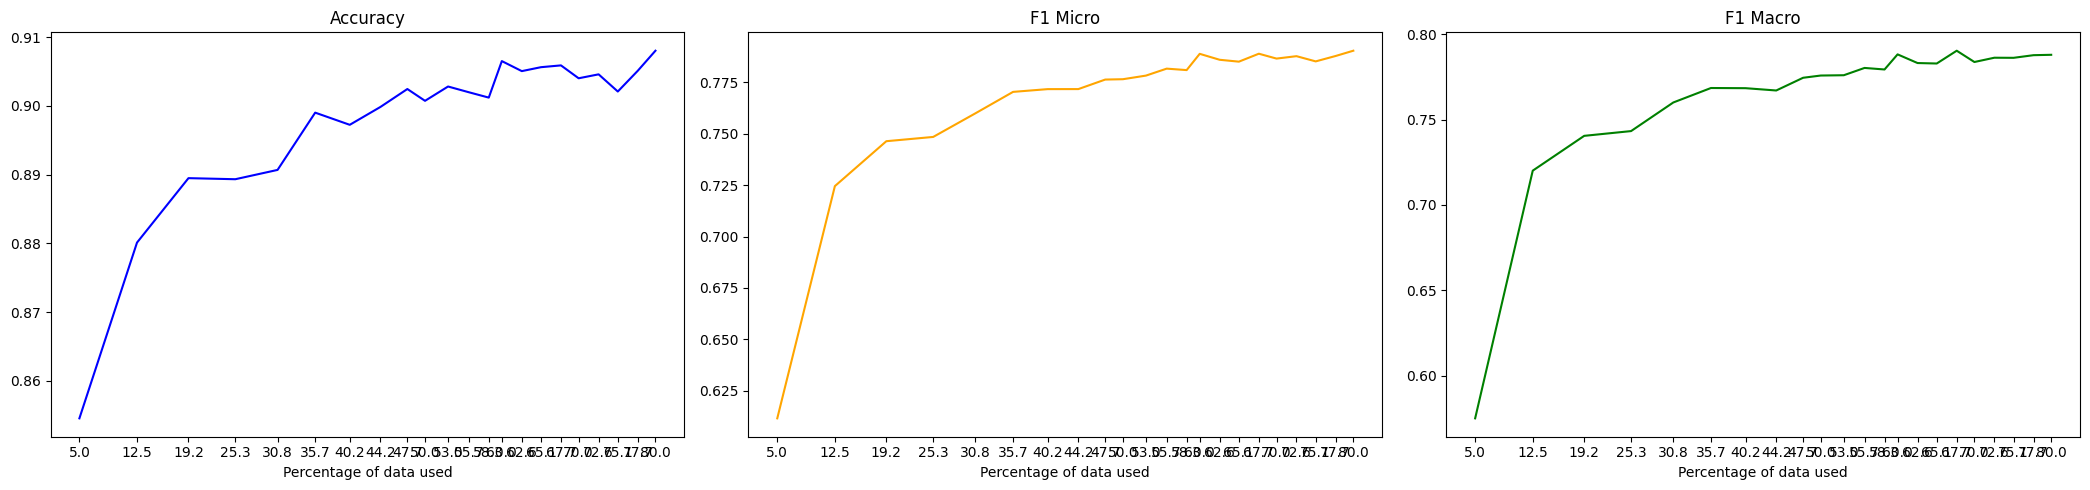

In [22]:
active_learning(seeds[4], 4)